# German Traffic Sign Classifier using a LeNet based Convolutional Network

## Pipeline Approach

In this project, I'm building pipelines to classify the traffic signs from the [German Traffic Sign Benchmarks](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

I'm using the scikit-learn's pipeline framework in order to train the model with various combinations of transformations and estimators.

The starting model is a convolutional network based on the [LeNet](http://yann.lecun.com/exdb/lenet/) architecture by Yann LeCun.  LeNet was originally designed for handwritten and machine-printed character recognition. 

The project is explained in the following sections.

- Data Exploratory Analysis
- Model Implementation
- Pipeline Implementation
- Preprocessing
- Model Improvement
- Testing and Results

# Data Exploratory Analysis

The traffic sign images were taken from the [German Traffic Sign Benchmarks](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).  

- http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip
- http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip
- http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_GT.zip

```
> mkdir data

> # use wget or curl 
> wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip
> unzip GTSRB_Final_Training_Images.zip
> mv GTSRB/Final_Training data/

> wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip
> unzip GTSRB_Final_Test_Images.zip
> mv GTSRB/Final_Test/ data/

> wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_GT.zip
> unzip GTSRB_Final_Test_GT.zip
> mv GT-final_test.csv data/Final_Test/Images/
```

## Training Data Folder Structure

The training images are organized in folders by category.  Each folder is meant for one category (i.e. stop sign) and has a label file (.csv) which is actually semi-colon delimited (not comma delimited).

```
data
 + Final_Training
    + Images
        + 00000
            + 00000_00000.ppm
            + 00000_00001.ppm
            ...    
            + GT-00000.csv
        + 00001
            + 00000_00000.ppm
            + 00000_00001.ppm
            ...    
            + GT-00001.csv
        ...
```

All images are stored in the PPM format ([Portable Pixmap, P6](http://en.wikipedia.org/wiki/Netpbm_format)).  You'll need to install both `matplotlib` and `pillow` to handle such image format.  If you use one of the evironments yml files in this repository, this will be taken care of.

## Import Required Libraries

In [1]:
import glob
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from pipeline import NeuralNetwork, make_adam, Session, build_pipeline

matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Loading Training Data

All train image paths are combined into one dataframe for convenience.

In [2]:
TRAIN_IMAGE_DIR = '/datasets/tmp/cg181fcp/data/Final_Training/Images'

dfs = []
for train_file in glob.glob(os.path.join(TRAIN_IMAGE_DIR, '*/GT-*.csv')):
    folder = train_file.split('/')[-2]
    df = pd.read_csv(train_file, sep=';')
    df['Filename'] = df['Filename'].apply(lambda x: os.path.join(TRAIN_IMAGE_DIR, folder, x))
    dfs.append(df)

In [3]:
train_df = pd.concat(dfs, ignore_index=True)
train_df.head()

Filename  Width  Height  Roi.X1  \
0  /datasets/tmp/cg181fcp/data/Final_Training/Ima...     32      26       6   
1  /datasets/tmp/cg181fcp/data/Final_Training/Ima...     32      26       6   
2  /datasets/tmp/cg181fcp/data/Final_Training/Ima...     31      25       5   
3  /datasets/tmp/cg181fcp/data/Final_Training/Ima...     33      26       5   
4  /datasets/tmp/cg181fcp/data/Final_Training/Ima...     34      28       5   

   Roi.Y1  Roi.X2  Roi.Y2  ClassId  
0       5      27      21       30  
1       5      27      21       30  
2       5      26      20       30  
3       5      28      21       30  
4       5      29      23       30

**Annotation format**
- Filename: Filename of corresponding image
- Width: Width of the image
- Height: Height of the image
- ROI.x1: X-coordinate of top-left corner of traffic sign bounding box
- ROI.y1: Y-coordinate of top-left corner of traffic sign bounding box
- ROI.x2: X-coordinate of bottom-right corner of traffic sign bounding box
- ROI.y2: Y-coordinate of bottom-right corner of traffic sign bounding box
- ClassId: Assigned class label

The following points are worth mentioning:
- Image sizes are not fixed
- Sign sizes are not fixed
- Sign's center location is not fixed

Later on, I'll examine sample images to further clarify those points.

## Class Distribution

There are 43 traffic sign classes in 39,209 training images.

In [4]:
N_CLASSES = np.unique(train_df['ClassId']).size  # keep this for later

print("Number of training images : {:>5}".format(train_df.shape[0]))
print("Number of classes         : {:>5}".format(N_CLASSES))

Number of training images : 39209
Number of classes         :    43


The distribution of classes are very skewed.

In [5]:
def show_class_distribution(classIDs, title):
    """
    Plot the traffic sign class distribution
    """
    plt.figure(figsize=(15, 5))
    plt.title('Class ID distribution for {}'.format(title))
    plt.hist(classIDs, bins=N_CLASSES)
    plt.show()

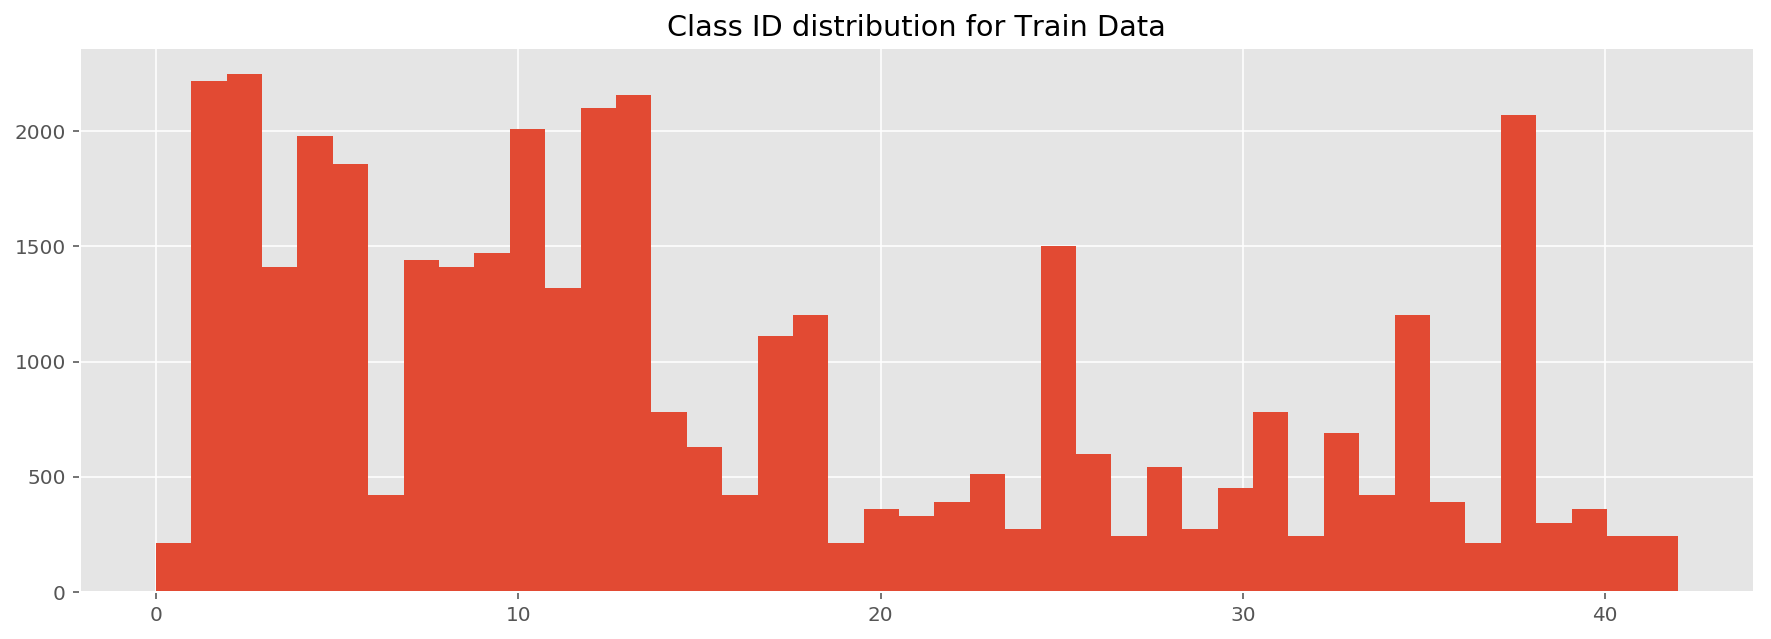

In [6]:
show_class_distribution(train_df['ClassId'], 'Train Data')

The name of each sign are stored in sign_names.csv file.  We can use it see the distribution per sign names.

In [7]:
sign_name_df = pd.read_csv('sign_names.csv', index_col='ClassId')
sign_name_df.head()

SignName
ClassId                      
0        Speed limit (20km/h)
1        Speed limit (30km/h)
2        Speed limit (50km/h)
3        Speed limit (60km/h)
4        Speed limit (70km/h)

In [8]:
sign_name_df['Occurence'] = [sum(train_df['ClassId']==c) for c in range(N_CLASSES)]
sign_name_df.sort_values('Occurence', ascending=False)

SignName  Occurence
ClassId                                                              
2                                     Speed limit (50km/h)       2250
1                                     Speed limit (30km/h)       2220
13                                                   Yield       2160
12                                           Priority road       2100
38                                              Keep right       2070
10            No passing for vehicles over 3.5 metric tons       2010
4                                     Speed limit (70km/h)       1980
5                                     Speed limit (80km/h)       1860
25                                               Road work       1500
9                                               No passing       1470
7                                    Speed limit (100km/h)       1440
3                                     Speed limit (60km/h)       1410
8                                    Speed limit (120km/h)       1410
11                   Right-of-way at the next intersection       1320
35                                              Ahead only       1200
18                                         General caution       1200
17                                                No entry       1110
31                                   Wild animals crossing        780
14                                                    Stop        780
33                                        Turn right ahead        689
15                                             No vehicles        630
26                                         Traffic signals        600
28                                       Children crossing        540
23                                           Slippery road        510
30                                      Beware of ice/snow        450
16                Vehicles over 3.5 metric tons prohibited        420
34                                         Turn left ahead        420
6                              End of speed limit (80km/h)        420
36                                    Go straight or right        390
22                                              Bumpy road        390
40                                    Roundabout mandatory        360
20                            Dangerous curve to the right        360
21                                            Double curve        330
39                                               Keep left        300
29                                       Bicycles crossing        270
24                               Road narrows on the right        270
41                                       End of no passing        240
42       End of no passing by vehicles over 3.5 metric ...        240
32                     End of all speed and passing limits        240
27                                             Pedestrians        240
37                                     Go straight or left        210
19                             Dangerous curve to the left        210
0                                     Speed limit (20km/h)        210

The following constant is defined for later use.

In [9]:
SIGN_NAMES = sign_name_df.SignName.values
SIGN_NAMES[2]

'Speed limit (50km/h)'

## Sample Images

Let's examine some random images:

In [10]:
def load_image(image_file):
    """
    Read image file into numpy array (RGB)
    """
    return plt.imread(image_file)

In [11]:
def get_samples(image_data, num_samples, class_id=None):
    """
    Randomly select image filenames and their class IDs
    """
    if class_id is not None:
        image_data = image_data[image_data['ClassId']==class_id]
    indices = np.random.choice(image_data.shape[0], size=num_samples, replace=False)
    return image_data.iloc[indices][['Filename', 'ClassId']].values

In [12]:
def show_images(image_data, cols=5, sign_names=None, show_shape=False, func=None):
    """
    Given a list of image file paths, load images and show them.
    """
    num_images = len(image_data)
    rows = num_images//cols
    plt.figure(figsize=(cols*3,rows*2.5))
    for i, (image_file, label) in enumerate(image_data):
        image = load_image(image_file)
        if func is not None:
            image = func(image)
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        if sign_names is not None:
            plt.text(0, 0, '{}: {}'.format(label, sign_names[label]), color='k',backgroundcolor='c', fontsize=8)        
        if show_shape:
            plt.text(0, image.shape[0], '{}'.format(image.shape), color='k',backgroundcolor='y', fontsize=8)        
        plt.xticks([])
        plt.yticks([])
    plt.show()

The below are 20 random sample images from the train set.

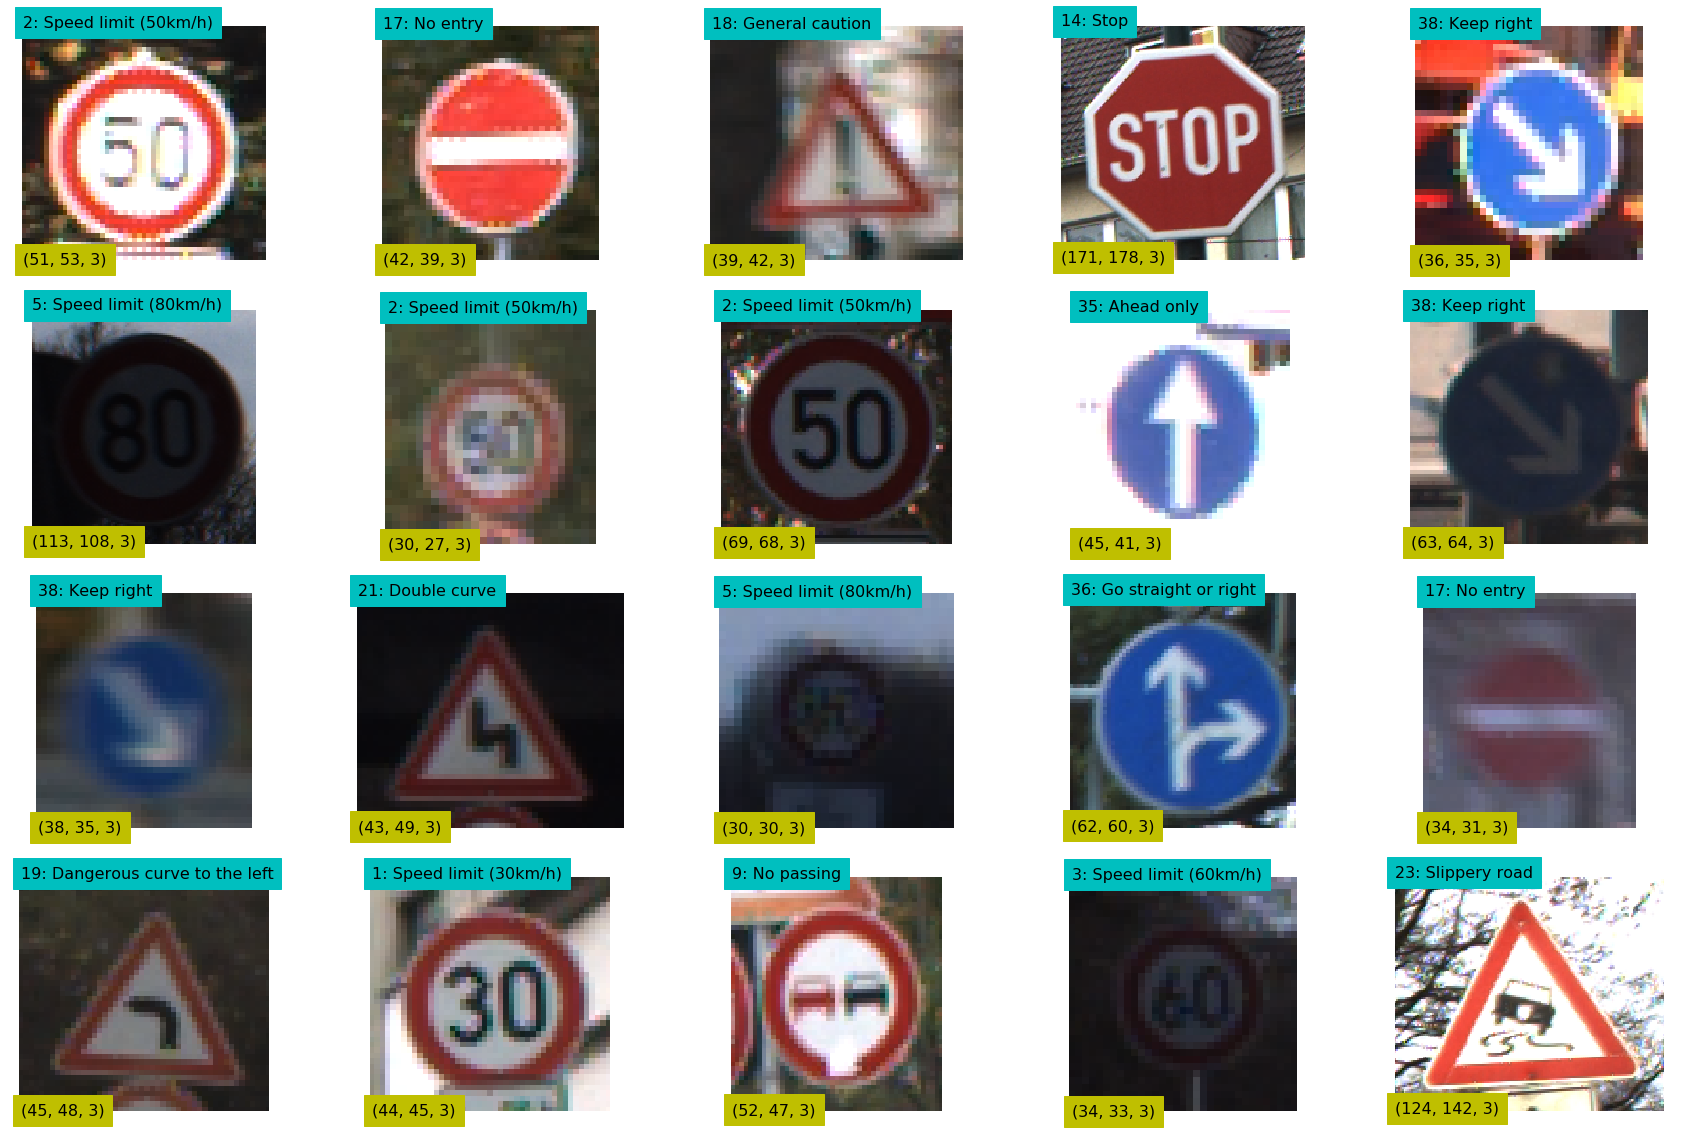

In [13]:
sample_data = get_samples(train_df, 20)
show_images(sample_data, sign_names=SIGN_NAMES, show_shape=True)

Speed limit (50km/h)


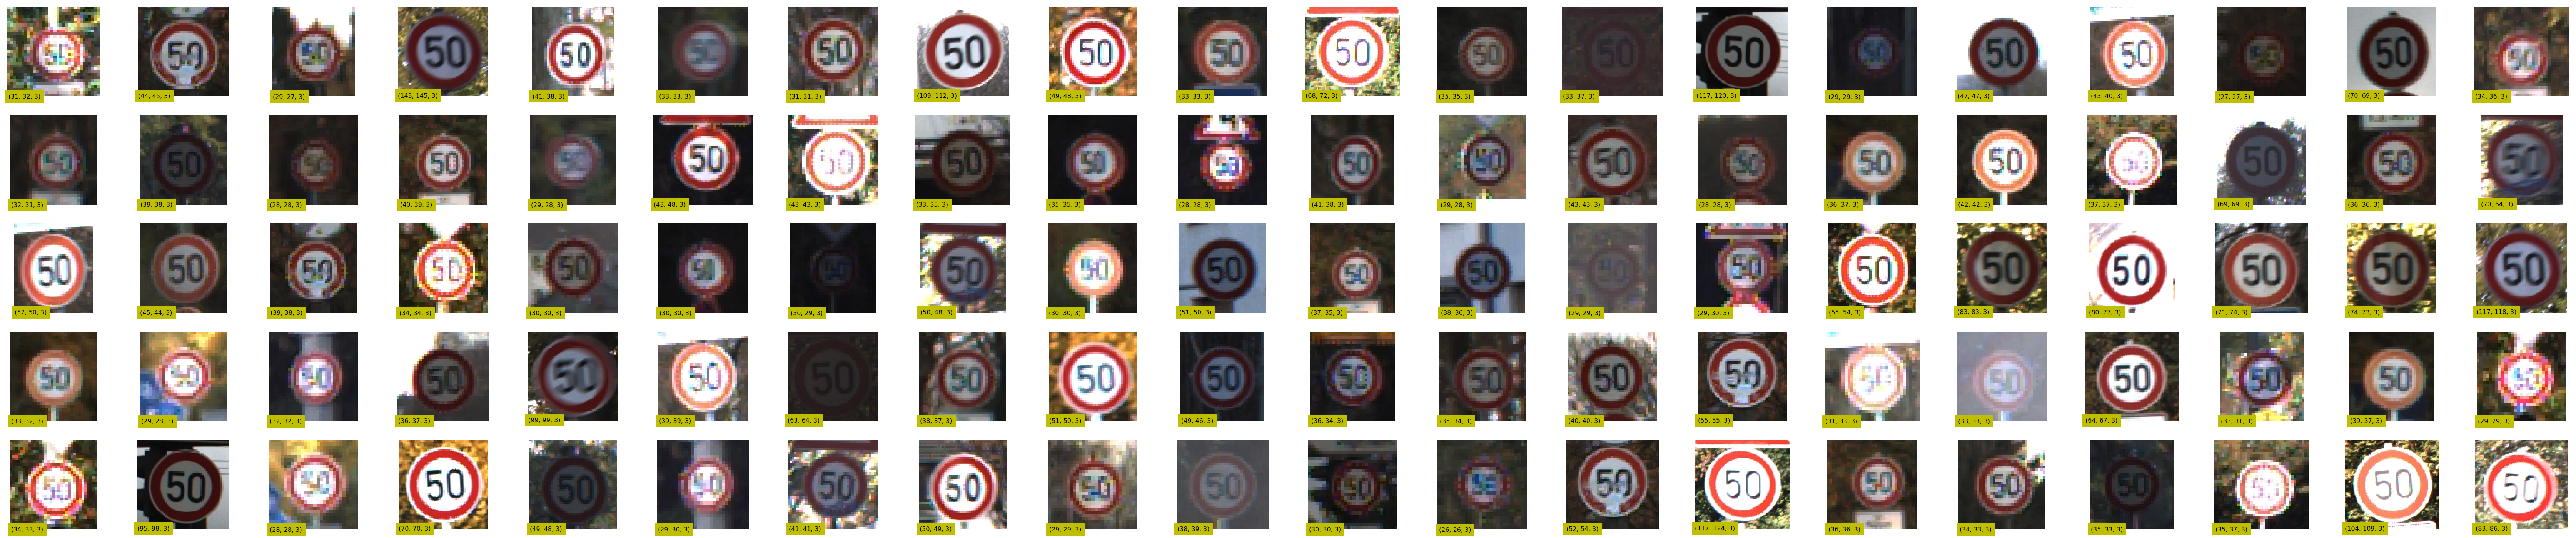

In [14]:
print(SIGN_NAMES[2])
show_images(get_samples(train_df, 100, class_id=2), cols=20, show_shape=True)

Speed limit (20km/h)


KeyboardInterrupt: 

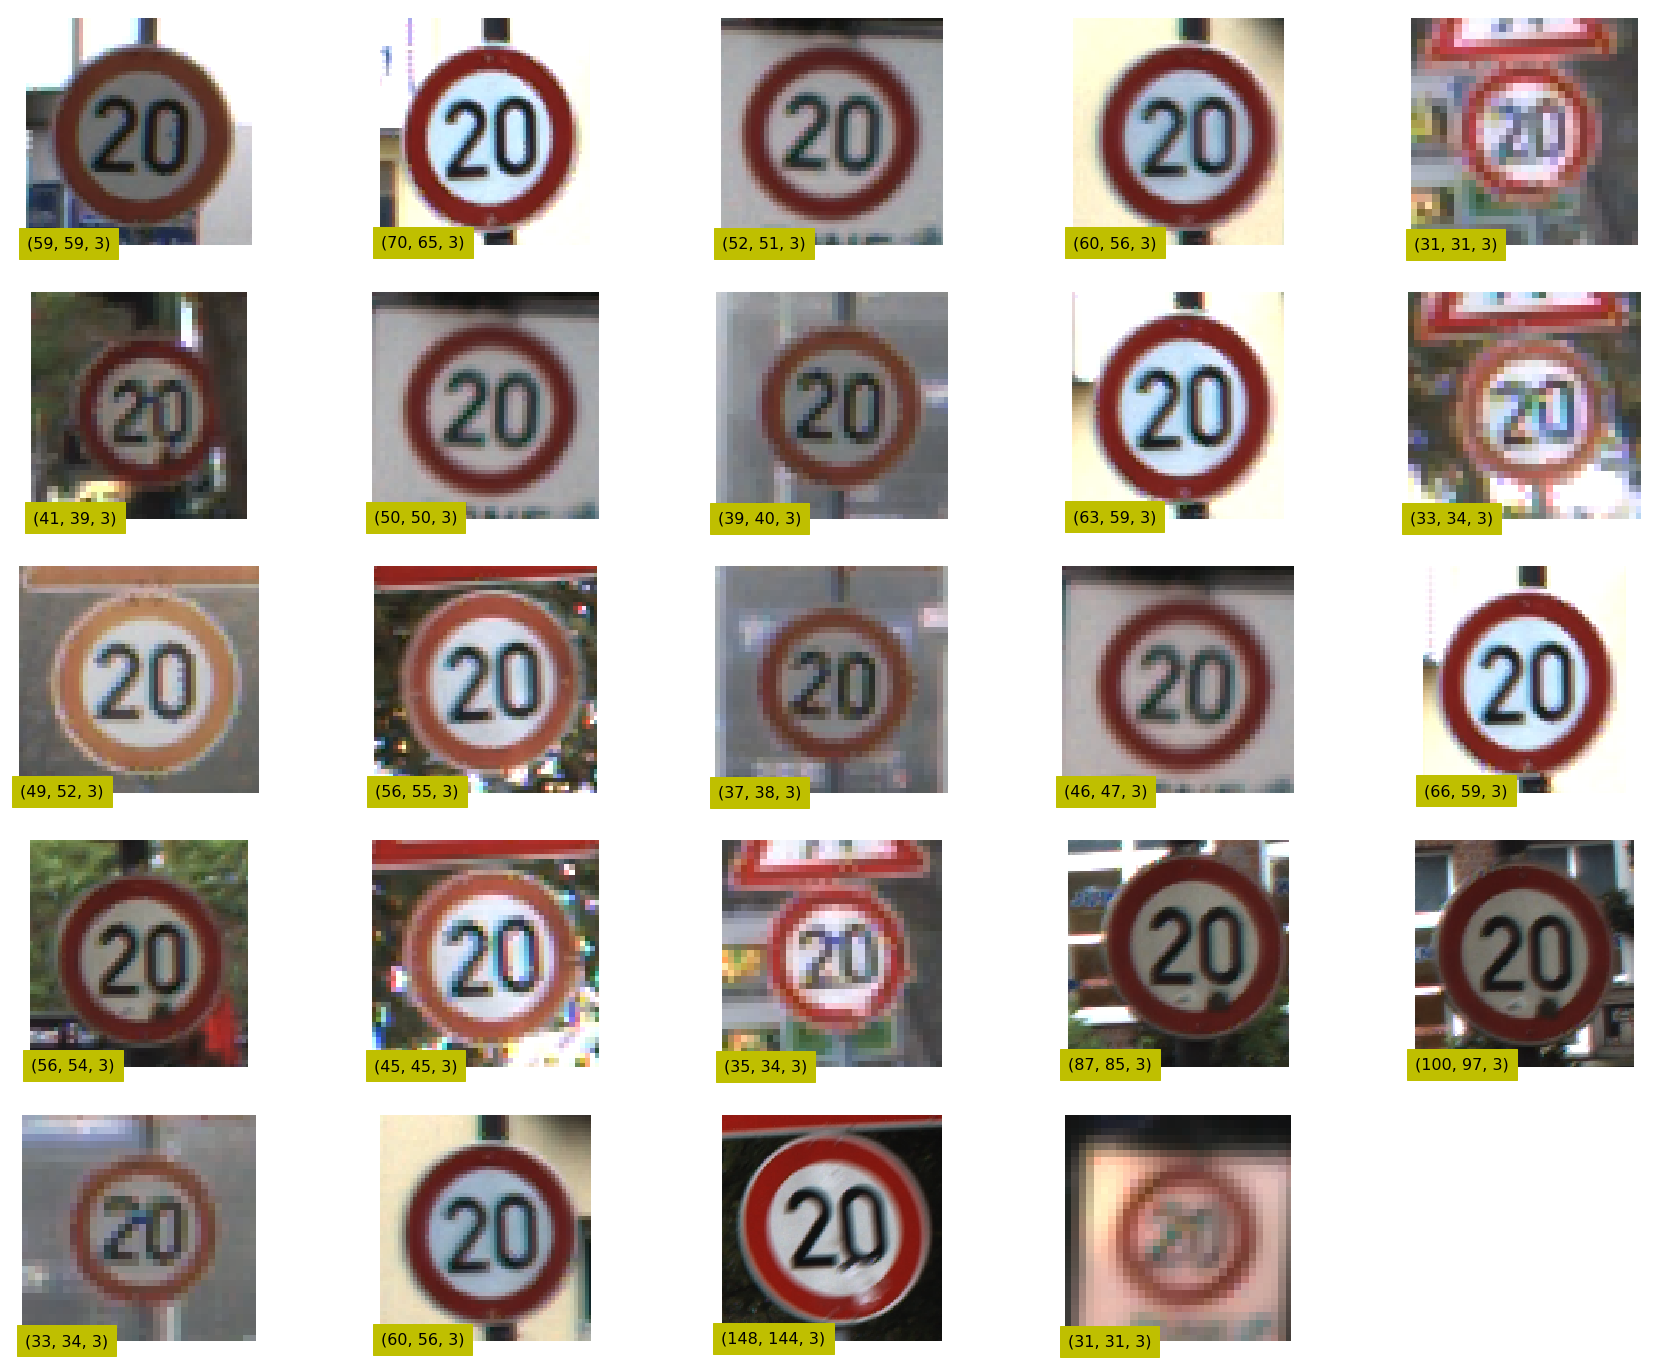

In [15]:
for i in range(43):
    print(SIGN_NAMES[i])
    show_images(get_samples(train_df, 100, class_id=i), show_shape=True)

Looking at the sample images, the following image characteristics are confirmed:

- The images comes in different sizes  
- The darkness / brightness of those images are fairly random
- The images may be slightly rotated
- The images may not be facing straight
- The images may not be exactly centered
  
The first point will be handled in the image pre-processing, and the remaining points will be handled in the image augmentation.

## Train and Validation Data set

Train and validation data set are created from the training data.

In [16]:
X = train_df['Filename'].values
y = train_df['ClassId'].values

print('X data', len(X))

X data 39209


In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=8000, random_state=0)

print('X_train:', len(X_train))
print('X_valid:', len(X_valid))

X_train: 31209
X_valid: 8000


#  Model Implementation

## Model Architecture

The model is based on [LeNet](http://yann.lecun.com/exdb/lenet/) by Yann LeCun.  It is a convolutional neural network designed to recognize visual patterns directly from pixel images with minimal preprocessing.  It can handle hand-written characters very well. 

![LeNet](images/lenet.png)

Source: http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf

- The inputs are 32x32 (Black-White 1 channel) images
- LeNet uses 2x2 sub-sampling (valid padding, max pooling) in convolutional layers (no dropout)
- LeNet uses a sigmoid squashing function - a scaled hyperbolic tangent: $Atanh(Sa)$ where A=1.7159 and S=2/3
- LeNet has one 7x12 bitmap for each class, which is a label.  There are 10 classes (the digits '0' - '9')
- 7x12 = 84 which is why the output is 84
- The output is compared with all the labels (bitmaps) to calculate the error
- The class with the smallest error is an estimated digit value

Our model is adapted from the LeNet as follows.  

- The inputs are 32x32 (RGB - 3 channels) images
- The activation function is ReLU except for the output layer which uses Softmax
- The output has 43 classes

|Layer                       | Shape    |
|----------------------------|:--------:|
|Input                       | 32x32x3  |
|Convolution (valid, 5x5x6)  | 28x28x6  |
|Max Pooling (valid, 2x2)    | 14x14x6  |
|Activation  (ReLU)          | 14x14x6  |
|Convolution (valid, 5x5x16) | 10x10x16 |
|Max Pooling (valid, 2x2)    | 5x5x16   |
|Activation  (ReLU)          | 5x5x16   |
|Flatten                     | 400      |
|Dense                       | 120      |
|Activation  (ReLU)          | 120      |
|Dense                       | 43       |
|Activation  (Softmax)       | 43       |

## Model Implementation

The NeuralNetwork class is defined to provide common operations in neural network using Tensorflow.  See the network.py for details.

The first network (based on LeNet) is defined as follows:

In [18]:
INPUT_SHAPE = (32, 32, 3)

def make_network1(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 6])
            .max_pool()
            .relu()
            .conv([5, 5, 16])
            .max_pool()
            .relu()
            .flatten()
            .dense(120)
            .relu()
            .dense(N_CLASSES))

## Pipeline Implementation

We are using the scikit-learn's pipeline framework to handle various pipeline scenarios.  See pipeline.py for details.

Once made, a pipeline can be trained and evaluated using the function below:

In [19]:
def train_evaluate(pipeline, epochs=5, samples_per_epoch=50000, train=(X_train, y_train), test=(X_valid, y_valid)):
    """
    Repeat the training for the epochs and evaluate the performance
    """
    X, y = train
    learning_curve = []
    for i in range(epochs):
        indices = np.random.choice(len(X), size=samples_per_epoch)
        pipeline.fit(X[indices], y[indices])
        scores = [pipeline.score(*train), pipeline.score(*test)]
        learning_curve.append([i, *scores])
        print("Epoch: {:>3} Train Score: {:.3f} Evaluation Score: {:.3f}".format(i, *scores))
    return np.array(learning_curve).T # (epochs, train scores, eval scores)

### The First Performance

Let's train a network using the first network.  This performance is our initial benchmark.

In [20]:
def resize_image(image, shape=INPUT_SHAPE[:2]):
    return cv2.resize(image, shape)

loader = lambda image_file: resize_image(load_image(image_file))

In [20]:
with Session() as session:
    functions = [loader]
    pipeline = build_pipeline(functions, session, make_network1(), make_adam(1.0e-3))
    train_evaluate(pipeline)
    session.save('checkpoint/network_1.ckpt')


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



TypeError: src data type = 17 is not supported

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network1())
    session.load('checkpoint/network_1.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

**Observation**:

This proves the network is working properly.  The performance is pretty good for the barebone network.

I can see a bit of overfitting.  This is likely because the network is exposed to the same images over and over since I'm using 5 epochs (50K samples per epoch).  At this moment, it is good to see the network is able to overfit and not showing high biases.  The network can handle these images and able to learn from the data.

# Preprocessing

## Image Augmentation

As the training set has very skewed distribution, if I simply increases the epochs or samples per epoch, the network will overfit to the training set.  Hence, we should generate more training data using image augmentation.

In [21]:
def random_brightness(image, ratio):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    brightness = np.float64(hsv[:, :, 2])
    brightness = brightness * (1.0 + np.random.uniform(-ratio, ratio))
    brightness[brightness>255] = 255
    brightness[brightness<0] = 0
    hsv[:, :, 2] = brightness
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def random_rotation(image, angle):
    """
    Randomly rotate the image
    """
    if angle == 0:
        return image
    angle = np.random.uniform(-angle, angle)
    rows, cols = image.shape[:2]
    size = cols, rows
    center = cols/2, rows/2
    scale = 1.0
    rotation = cv2.getRotationMatrix2D(center, angle, scale)
    return cv2.warpAffine(image, rotation, size)


def random_translation(image, translation):
    """
    Randomly move the image
    """
    if translation == 0:
        return 0
    rows, cols = image.shape[:2]
    size = cols, rows
    x = np.random.uniform(-translation, translation)
    y = np.random.uniform(-translation, translation)
    trans = np.float32([[1,0,x],[0,1,y]])
    return cv2.warpAffine(image, trans, size)


def random_shear(image, shear):
    """
    Randomly distort the image
    """
    if shear == 0:
        return image
    rows, cols = image.shape[:2]
    size = cols, rows
    left, right, top, bottom = shear, cols - shear, shear, rows - shear
    dx = np.random.uniform(-shear, shear)
    dy = np.random.uniform(-shear, shear)
    p1 = np.float32([[left   , top],[right   , top   ],[left, bottom]])
    p2 = np.float32([[left+dx, top],[right+dx, top+dy],[left, bottom+dy]])
    move = cv2.getAffineTransform(p1,p2)
    return cv2.warpAffine(image, move, size)
    
    
def augment_image(image, brightness, angle, translation, shear):
    image = random_brightness(image, brightness)
    image = random_rotation(image, angle)
    image = random_translation(image, translation)
    image = random_shear(image, shear)
    return image

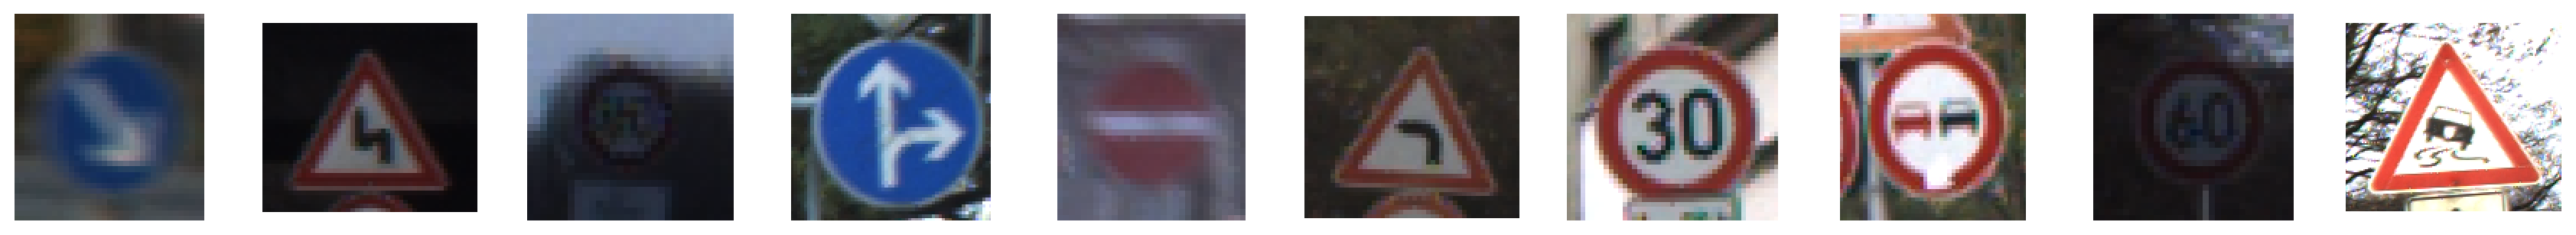

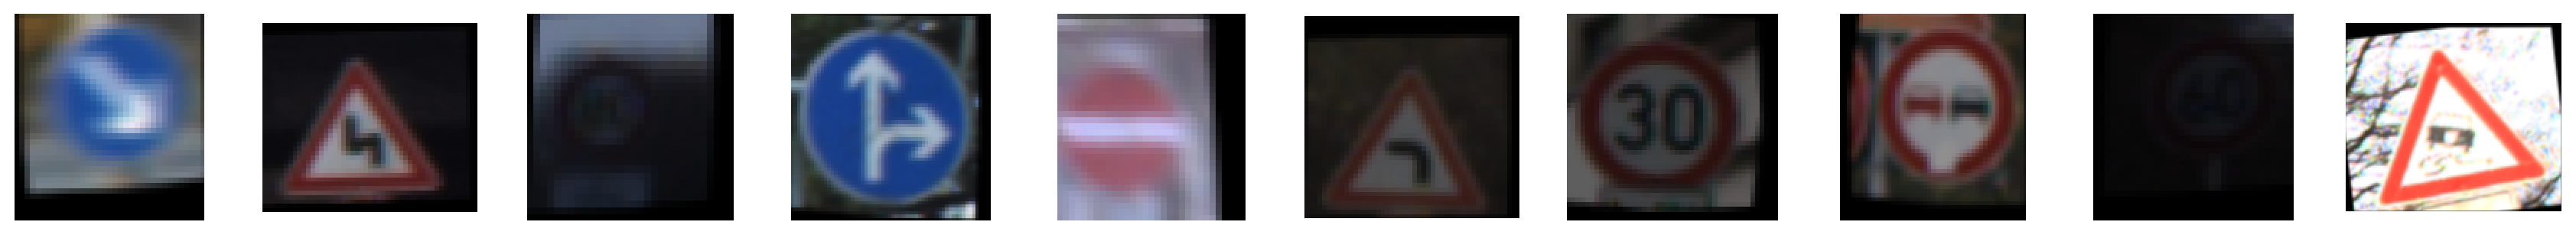

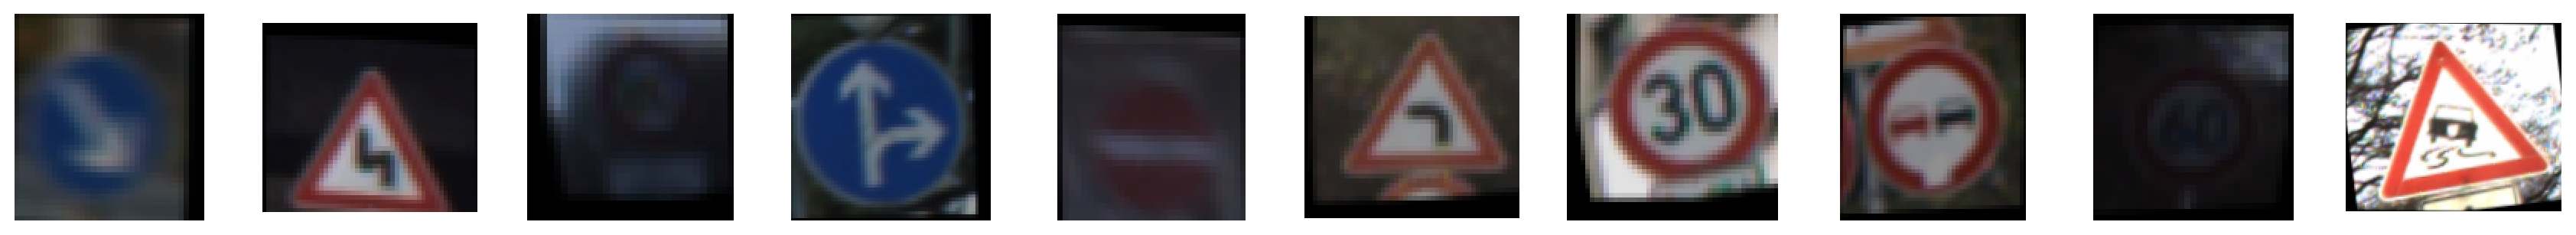

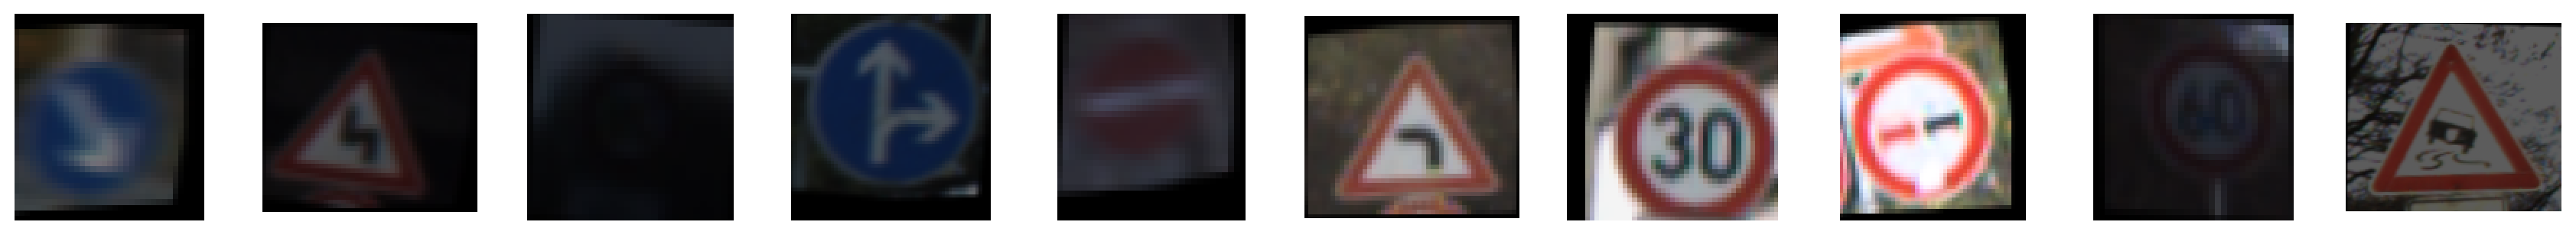

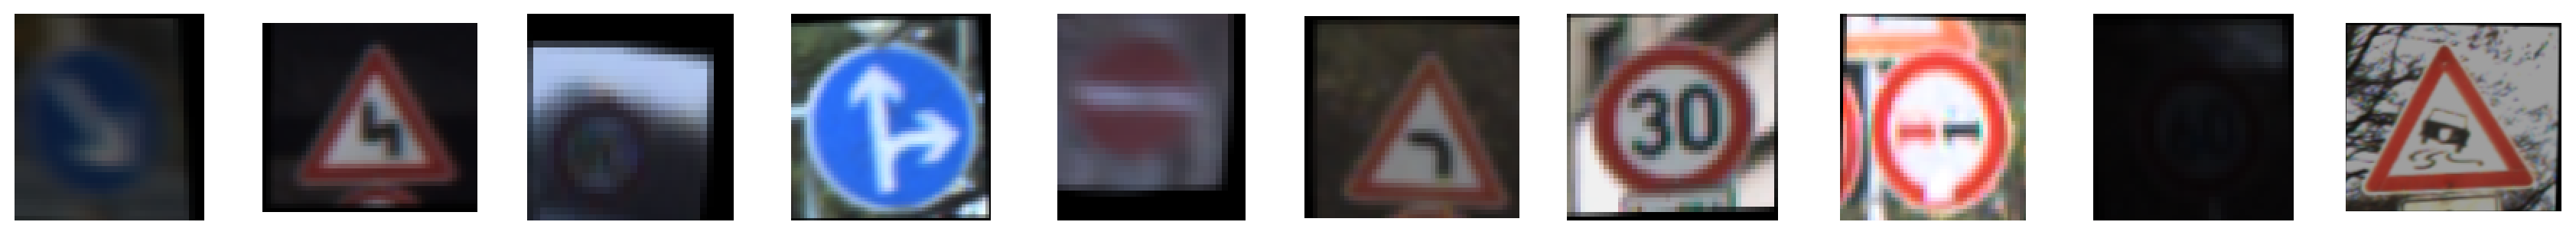

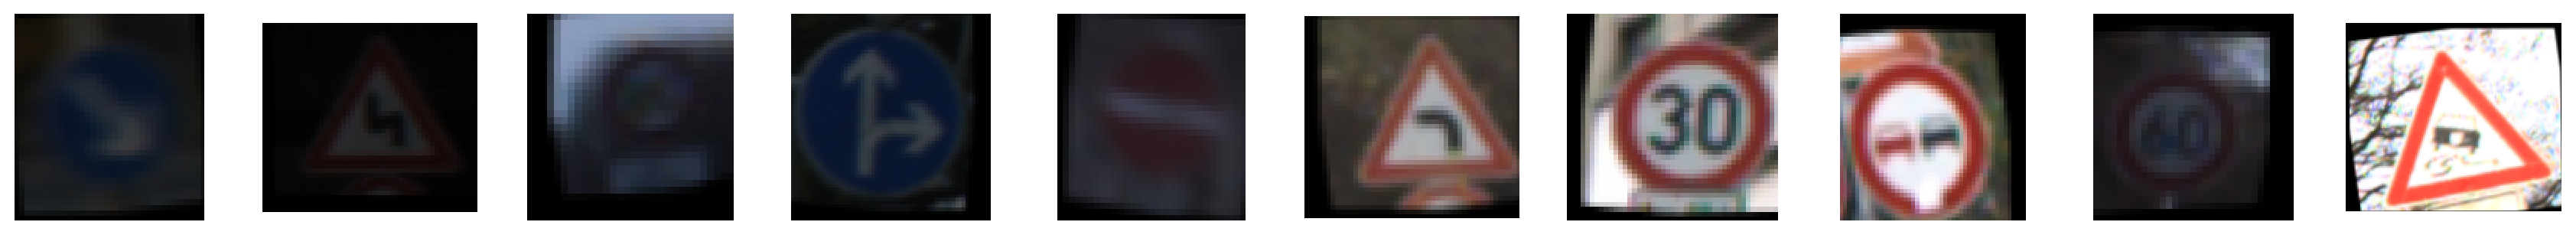

In [22]:
augmenter = lambda x: augment_image(x, brightness=0.7, angle=10, translation=5, shear=2)

show_images(sample_data[10:], cols=10) # original
for _ in range(5):
    show_images(sample_data[10:], cols=10, func=augmenter)
    
normalizer = lambda x: (x - x.mean())/x.std()
preprocessors = [loader, augmenter, normalizer]

In [23]:
#with Session() as session:
 #   functions = [loader, augmenter]
  #  pipeline = build_pipeline(functions, session, make_network1(), make_adam(1.0e-3))
   # train_evaluate(pipeline)

**Obervation**:

The hyper-perameters like brightness, rotation, translation, shear parameters are manually tuned by looking at the randomly altered images.  If the alteration is too great, it is not realistic.  The same way that horizontal flip is not included, too big change like rotating 90 degree should not be used.

The performance with the augmentation is much worse than without it.  There are two possible reasons:

1. the network is not robust to these changes (it was memorizing than generalizing)
2. the training requires more epochs (it takes more time to train with larger data)

Let's see how other preprocessing can improve the performance first.  I hope the normalization and other technique will make the learning easier for the network.  Once that's done, I will use much bigger epochs to properly measure the performance.

## Data Normalization

The below will test various normalization technique to see which one has the best performance.

In [23]:
normalizers = [('x - 127.5',              lambda x: x - 127.5), 
               ('x/127.5 - 1.0',          lambda x: x/127.5 - 1.0), 
               ('x/255.0 - 0.5',          lambda x: x/255.0 - 0.5),
               ('x - x.mean()',           lambda x: x - x.mean()),
               ('(x - x.mean())/x.std()', lambda x: (x - x.mean())/x.std())]
                
for name, normalizer in normalizers:
    print('Normalizer: {}'.format(name))
    with Session() as session:
        functions = [loader, augmenter, normalizer]
        pipeline = build_pipeline(functions, session, make_network1(), make_adam(1.0e-3))
        train_evaluate(pipeline)
    print()

Normalizer: x - 127.5
Epoch:   0 Train Score: 0.291 Evaluation Score: 0.290
Epoch:   1 Train Score: 0.492 Evaluation Score: 0.486
Epoch:   2 Train Score: 0.578 Evaluation Score: 0.565
Epoch:   3 Train Score: 0.705 Evaluation Score: 0.701
Epoch:   4 Train Score: 0.700 Evaluation Score: 0.698

Normalizer: x/127.5 - 1.0
Epoch:   0 Train Score: 0.517 Evaluation Score: 0.514
Epoch:   1 Train Score: 0.678 Evaluation Score: 0.667
Epoch:   2 Train Score: 0.767 Evaluation Score: 0.763
Epoch:   3 Train Score: 0.818 Evaluation Score: 0.817
Epoch:   4 Train Score: 0.847 Evaluation Score: 0.837

Normalizer: x/255.0 - 0.5
Epoch:   0 Train Score: 0.561 Evaluation Score: 0.550
Epoch:   1 Train Score: 0.660 Evaluation Score: 0.654
Epoch:   2 Train Score: 0.746 Evaluation Score: 0.739
Epoch:   3 Train Score: 0.789 Evaluation Score: 0.787
Epoch:   4 Train Score: 0.802 Evaluation Score: 0.804

Normalizer: x - x.mean()
Epoch:   0 Train Score: 0.535 Evaluation Score: 0.535
Epoch:   1 Train Score: 0.707 Eval

**Observaton**:

The performance with any of the normalizations is better than without them.  This clearly shows the importance of the normalizations.  In this experiment, the normalization with `(x-x.mean())/x.std()` produced the best performance.  The performance actually varies randomly at every run.  So, it is not easy to say which one is better than what.  In any case, `(x-x.mean())/x.std()` wins by far.

There are more techniques like using an average image of all training data, etc, which I may try later on.  But for now, I will use the best performing normalization for the rest of the experiment.

## Color Space

Now, we'll try difference color space to see if there is any performance gain.

Note: Gray scale has only one channel so it needs to be handled separately.

**Color Code Reference**:

- http://docs.opencv.org/3.2.0/de/d25/imgproc_color_conversions.html
- https://en.wikipedia.org/wiki/CIE_1931_color_space

In [25]:
# for Gray scale, we need to add the 3rd dimension back (1 channel) as it's expected by the network
converters = [('Gray', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)[:, :, np.newaxis]),
              ('HSV', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2HSV)),
              ('HLS', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2HLS)),
              ('Lab', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2Lab)),
              ('Luv', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2Luv)),
              ('XYZ', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2XYZ)),
              ('Yrb', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YCrCb)),
              ('YUV', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YUV))]

GRAY_INPUT_SHAPE = (*INPUT_SHAPE[:2], 1)

for name, converter in converters:
    print('Color Space: {}'.format(name))
    with Session() as session:
        functions = [loader, augmenter, converter, normalizer]
        if name == 'Gray':
            network = make_network1(input_shape=GRAY_INPUT_SHAPE) # there is only one channel in gray scale
        else:
            network = make_network1()
        pipeline = build_pipeline(functions, session, network, make_adam(1.0e-3))
        train_evaluate(pipeline)
    print()

Color Space: Gray
Epoch:   0 Train Score: 0.692 Evaluation Score: 0.687
Epoch:   1 Train Score: 0.811 Evaluation Score: 0.806
Epoch:   2 Train Score: 0.845 Evaluation Score: 0.841
Epoch:   3 Train Score: 0.874 Evaluation Score: 0.866
Epoch:   4 Train Score: 0.889 Evaluation Score: 0.882

Color Space: HSV
Epoch:   0 Train Score: 0.516 Evaluation Score: 0.509
Epoch:   1 Train Score: 0.632 Evaluation Score: 0.624
Epoch:   2 Train Score: 0.702 Evaluation Score: 0.690
Epoch:   3 Train Score: 0.746 Evaluation Score: 0.750
Epoch:   4 Train Score: 0.781 Evaluation Score: 0.776

Color Space: HLS
Epoch:   0 Train Score: 0.494 Evaluation Score: 0.484
Epoch:   1 Train Score: 0.614 Evaluation Score: 0.615
Epoch:   2 Train Score: 0.714 Evaluation Score: 0.716
Epoch:   3 Train Score: 0.766 Evaluation Score: 0.763
Epoch:   4 Train Score: 0.815 Evaluation Score: 0.801

Color Space: Lab
Epoch:   0 Train Score: 0.577 Evaluation Score: 0.579
Epoch:   1 Train Score: 0.695 Evaluation Score: 0.690
Epoch:   2

**Observaton**:

RGB (no conversion) is the best which surprised me.  I was expecting the gray scale to be more efficient as the traffic signs are mostly about shapes not colors.  The gray scale would have reduced the dimensionality from 3 color channels to 1, which would make the learning faster/easier.  Apparently, that is not the case.  

Also, I was thinking that the colors in traffic signs are more saturated than that of backgrounds (i.e., trees), and the color space like HSV and HLS might contribute to superior performance.  This was not the case.  Also, now that I saw the result, I realized that I should not assume anything about the background colors.

On a separate note, I noticed that whenever I ran this cell, the result seems slightly different.  For example, gray scale or XYZ sometimes shows better performance than RGB (no conversion).  This could be due to the randomness of image augmentation.  But most of the times, RGB (no conversion) is the best.  If I needed to analyse this further, I'd need to check the histogram of different channels and the performance for each color space.  

But that's the kind of things the network should automatically figure out (i.e., automatic feature engineering).  So, I should not mess with color space at least for now.  It makes the pipeline simpler, too.

I'm done with preprocessing part.

# Model Improvement

I want to try the following to see if I can improve the performance while not causing any overfit.

- more filters in conv layers
- more neurons in dense layers
- more conv layers 
- more dense layers
- different activation like `elu` instead of `relu`
- dropout

The below is to plot the learning curve.

In [24]:
def show_learning_curve(learning_curve):
    epochs, train, valid = learning_curve
    plt.figure(figsize=(10, 10))
    plt.plot(epochs, train, label='train')
    plt.plot(epochs, valid, label='test')
    plt.title('Learning Curve')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.xticks(epochs)
    plt.legend(loc='center right')

These functions are for plotting and printing the confusion matrix.

In [25]:
def plot_confusion_matrix(cm):
    cm = [row/sum(row)   for row in cm]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Oranges)
    fig.colorbar(cax)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class IDs')
    plt.ylabel('True Class IDs')
    plt.show()
    

def print_confusion_matrix(cm, sign_names=SIGN_NAMES):
    results = [(i, SIGN_NAMES[i], row[i]/sum(row)*100) for i, row in enumerate(cm)]
    accuracies = []
    for result in sorted(results, key=lambda x: -x[2]):
        print('{:>2} {:<50} {:6.2f}% {:>4}'.format(*result, sum(y_train==result[0])))
        accuracies.append(result[2])
    print('-'*50)
    print('Accuracy: Mean: {:.3f} Std: {:.3f}'.format(np.mean(accuracies), np.std(accuracies)))

# stop here!!!!!!!!!!!

## Alexnet

Epoch:   0 Train Score: 0.732 Evaluation Score: 0.730
Epoch:   1 Train Score: 0.860 Evaluation Score: 0.863
Epoch:   2 Train Score: 0.887 Evaluation Score: 0.882
Epoch:   3 Train Score: 0.927 Evaluation Score: 0.923
Epoch:   4 Train Score: 0.930 Evaluation Score: 0.925
Epoch:   5 Train Score: 0.939 Evaluation Score: 0.933
Epoch:   6 Train Score: 0.951 Evaluation Score: 0.943
Epoch:   7 Train Score: 0.937 Evaluation Score: 0.931
Epoch:   8 Train Score: 0.938 Evaluation Score: 0.932
Epoch:   9 Train Score: 0.962 Evaluation Score: 0.954
Epoch:  10 Train Score: 0.962 Evaluation Score: 0.955
Epoch:  11 Train Score: 0.964 Evaluation Score: 0.959
Epoch:  12 Train Score: 0.959 Evaluation Score: 0.956
Epoch:  13 Train Score: 0.962 Evaluation Score: 0.953
Epoch:  14 Train Score: 0.973 Evaluation Score: 0.965
Epoch:  15 Train Score: 0.970 Evaluation Score: 0.964
Epoch:  16 Train Score: 0.974 Evaluation Score: 0.967
Epoch:  17 Train Score: 0.961 Evaluation Score: 0.957
Epoch:  18 Train Score: 0.97

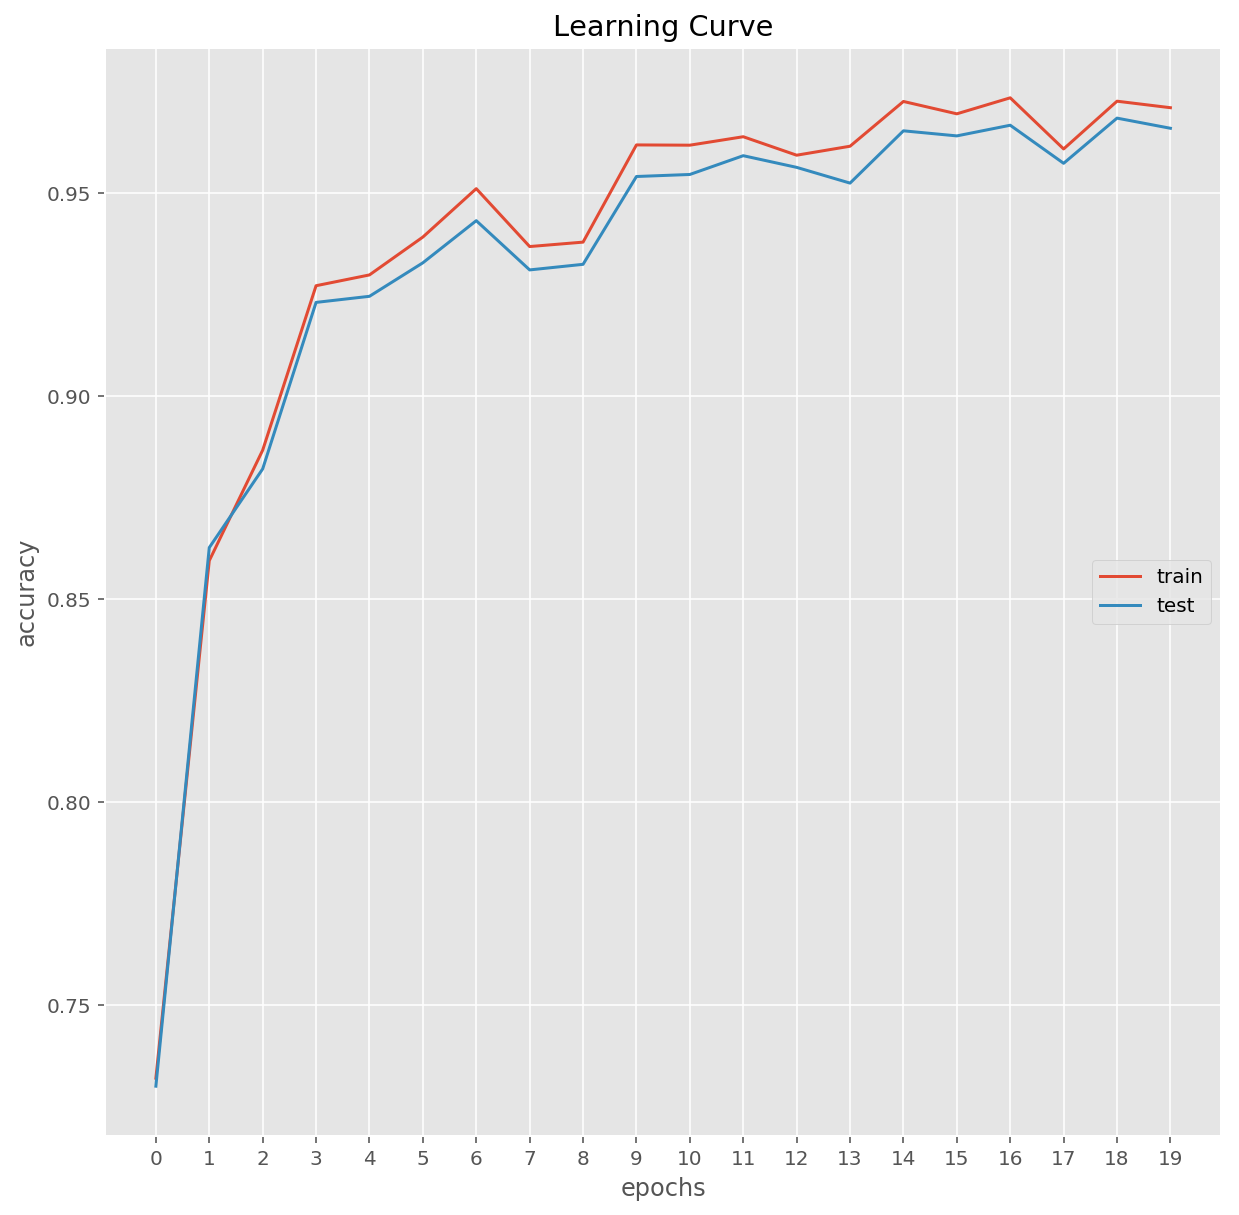

In [28]:
def make_alex(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([11, 11, 3],padding='SAME')  # <== doubled
            .max_pool()
            .local_response_normalize(radius = 2, alpha = 2e-05, beta = 0.75, bias = 1.0)
            .relu()
            
            .conv([5, 5,16])  # <== doubled
            .max_pool()
            .local_response_normalize(radius = 2, alpha = 2e-05, beta = 0.75, bias = 1.0)
            .relu()
            
            .conv([3, 3, 64],padding='SAME')
            .relu()
            .conv([3, 3, 64],padding='SAME')
            .relu()
            .conv([3, 3, 128],padding='SAME')
            .max_pool(strides=(1, 1, 1, 1))
            .relu()
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_alex(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network_alex.ckpt')
    
show_learning_curve(learning_curve)

## lower learning rete

Epoch:   0 Train Score: 0.535 Evaluation Score: 0.534
Epoch:   1 Train Score: 0.701 Evaluation Score: 0.695
Epoch:   2 Train Score: 0.784 Evaluation Score: 0.779
Epoch:   3 Train Score: 0.844 Evaluation Score: 0.840
Epoch:   4 Train Score: 0.888 Evaluation Score: 0.884
Epoch:   5 Train Score: 0.902 Evaluation Score: 0.898
Epoch:   6 Train Score: 0.926 Evaluation Score: 0.923
Epoch:   7 Train Score: 0.937 Evaluation Score: 0.928
Epoch:   8 Train Score: 0.943 Evaluation Score: 0.937
Epoch:   9 Train Score: 0.952 Evaluation Score: 0.949
Epoch:  10 Train Score: 0.955 Evaluation Score: 0.949
Epoch:  11 Train Score: 0.965 Evaluation Score: 0.958
Epoch:  12 Train Score: 0.953 Evaluation Score: 0.948
Epoch:  13 Train Score: 0.956 Evaluation Score: 0.950
Epoch:  14 Train Score: 0.971 Evaluation Score: 0.964
Epoch:  15 Train Score: 0.974 Evaluation Score: 0.970
Epoch:  16 Train Score: 0.970 Evaluation Score: 0.964
Epoch:  17 Train Score: 0.977 Evaluation Score: 0.969
Epoch:  18 Train Score: 0.97

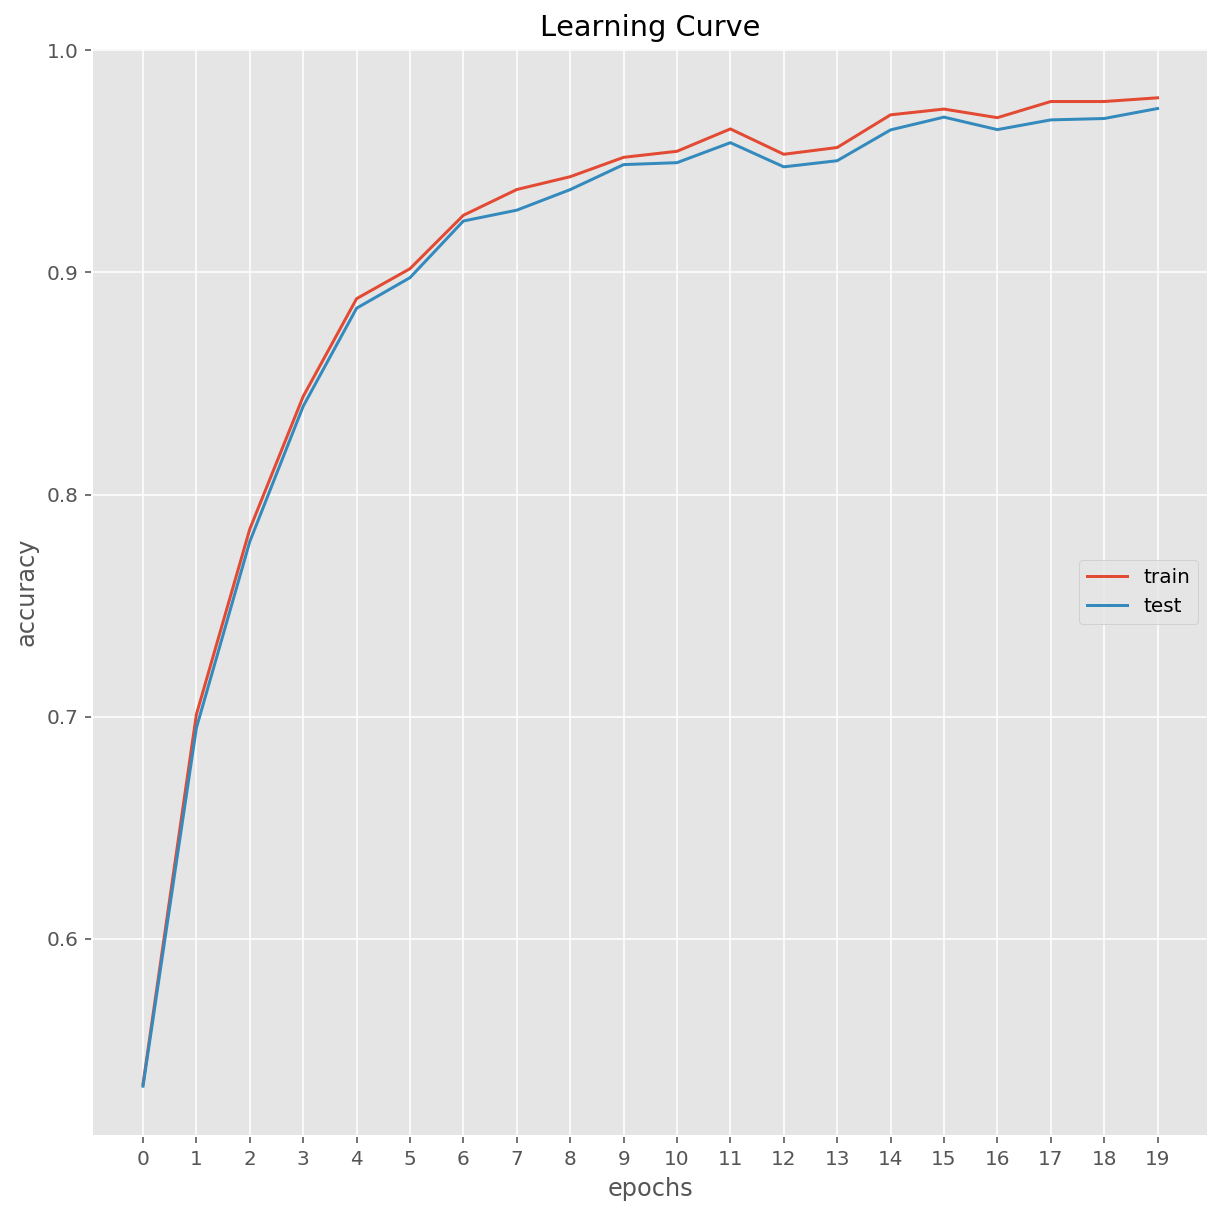

In [29]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_alex(), make_adam(0.2e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network_alex_lower_learning_rate.ckpt')
    
show_learning_curve(learning_curve)

## ResNet

In [28]:
def make_resnet(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([7, 7, 16],padding = 'SAME')  # <== doubled
            .max_pool()
            .relu()
            
            .resnet_block([3, 3])
            .relu()
            .resnet_block([3, 3])
            .relu()
            .resnet_block([3, 3])
            .relu()
            
            .conv([3, 3, 32],padding = 'SAME')
            .relu()
            
            .resnet_block([3, 3])
            .relu()
            .resnet_block([3, 3])
            .relu()
            .resnet_block([3, 3])
            .relu()
            
            .conv([3, 3, 64],padding = 'SAME')     
            .relu()
            
            .resnet_block([3, 3])
            .relu()
            .resnet_block([3, 3])
            .relu()
            .resnet_block([3, 3])
            .relu()
            .resnet_block([3, 3])
            .relu()
            .resnet_block([3, 3])
            .relu()
            
            .conv([3, 3, 128],padding = 'SAME')
            .relu()
            .resnet_block([3, 3])
            .relu()
            .resnet_block([3, 3])
            
            .avg_pool() 
            .relu()
                  
            .flatten()
            .dense(N_CLASSES))

Epoch:   0 Train Score: 0.066 Evaluation Score: 0.067
Epoch:   1 Train Score: 0.200 Evaluation Score: 0.194
Epoch:   2 Train Score: 0.361 Evaluation Score: 0.355
Epoch:   3 Train Score: 0.507 Evaluation Score: 0.499
Epoch:   4 Train Score: 0.631 Evaluation Score: 0.625
Epoch:   5 Train Score: 0.814 Evaluation Score: 0.810
Epoch:   6 Train Score: 0.901 Evaluation Score: 0.897
Epoch:   7 Train Score: 0.935 Evaluation Score: 0.932
Epoch:   8 Train Score: 0.911 Evaluation Score: 0.910
Epoch:   9 Train Score: 0.953 Evaluation Score: 0.951
Epoch:  10 Train Score: 0.959 Evaluation Score: 0.954
Epoch:  11 Train Score: 0.966 Evaluation Score: 0.958
Epoch:  12 Train Score: 0.965 Evaluation Score: 0.963
Epoch:  13 Train Score: 0.966 Evaluation Score: 0.960
Epoch:  14 Train Score: 0.968 Evaluation Score: 0.968
Epoch:  15 Train Score: 0.978 Evaluation Score: 0.977
Epoch:  16 Train Score: 0.970 Evaluation Score: 0.965
Epoch:  17 Train Score: 0.955 Evaluation Score: 0.953
Epoch:  18 Train Score: 0.96

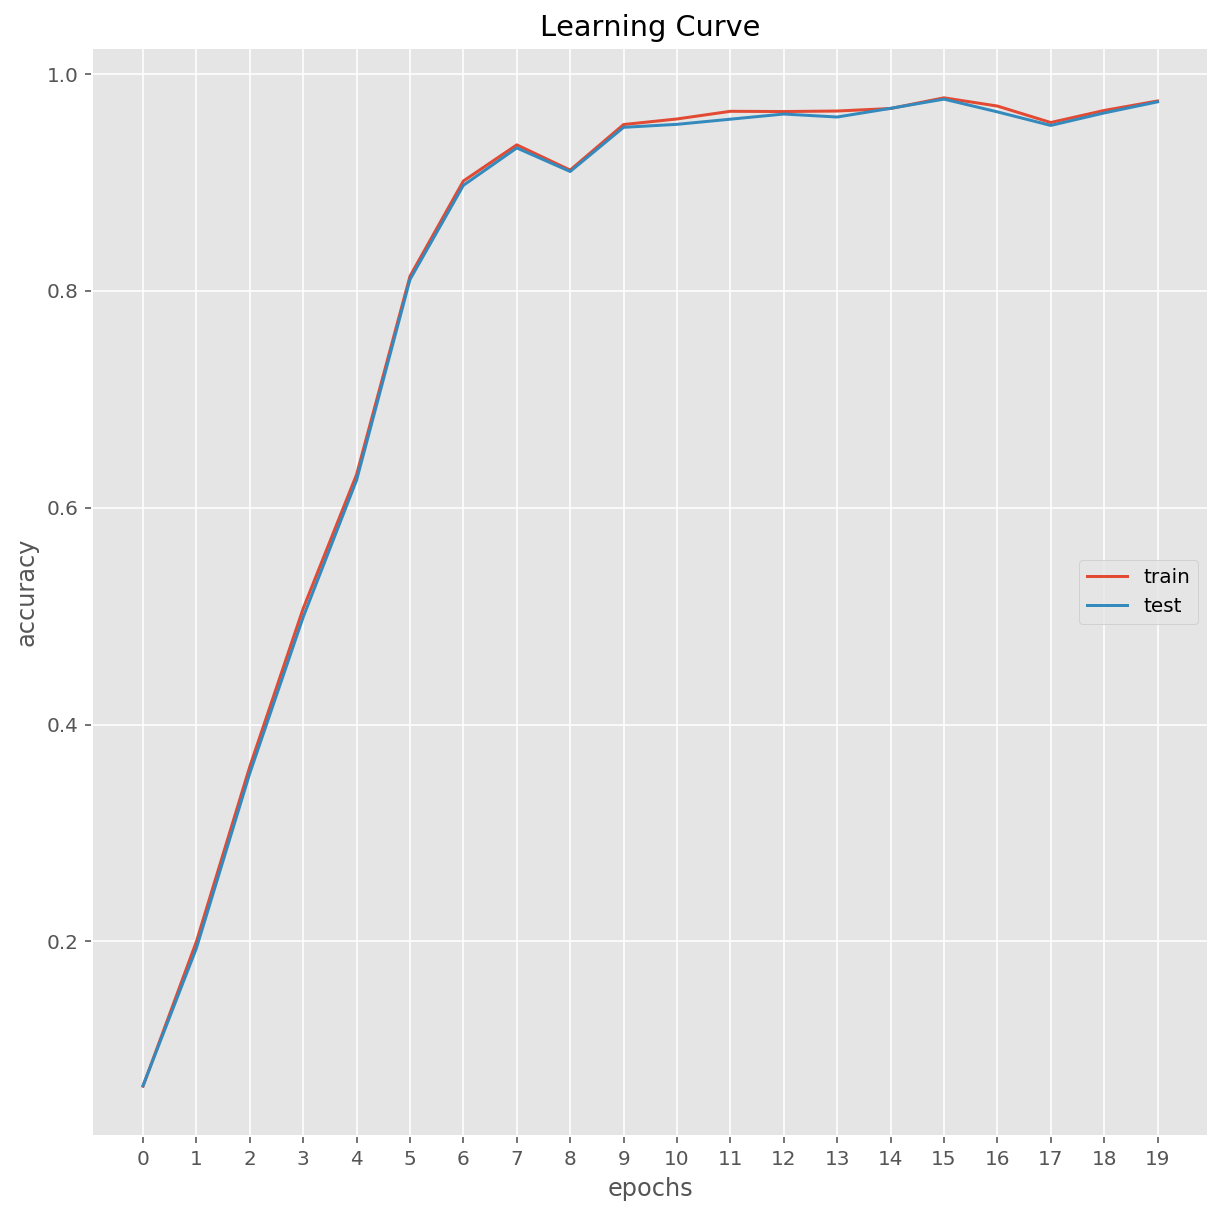

In [29]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_resnet(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network_resnet.ckpt')
    
show_learning_curve(learning_curve)

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_resnet(), make_adam(0.2e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network_resnet_more_epoch.ckpt')
    
show_learning_curve(learning_curve)

Epoch:   0 Train Score: 0.047 Evaluation Score: 0.046
Epoch:   1 Train Score: 0.079 Evaluation Score: 0.082
Epoch:   2 Train Score: 0.182 Evaluation Score: 0.183
Epoch:   3 Train Score: 0.273 Evaluation Score: 0.277
Epoch:   4 Train Score: 0.412 Evaluation Score: 0.410
Epoch:   5 Train Score: 0.515 Evaluation Score: 0.510
Epoch:   6 Train Score: 0.673 Evaluation Score: 0.664
Epoch:   7 Train Score: 0.794 Evaluation Score: 0.785
Epoch:   8 Train Score: 0.853 Evaluation Score: 0.853
Epoch:   9 Train Score: 0.897 Evaluation Score: 0.888
Epoch:  10 Train Score: 0.921 Evaluation Score: 0.916
Epoch:  11 Train Score: 0.937 Evaluation Score: 0.935
Epoch:  12 Train Score: 0.959 Evaluation Score: 0.960
Epoch:  13 Train Score: 0.954 Evaluation Score: 0.952
Epoch:  14 Train Score: 0.956 Evaluation Score: 0.955
Epoch:  15 Train Score: 0.972 Evaluation Score: 0.968
Epoch:  16 Train Score: 0.967 Evaluation Score: 0.963
Epoch:  17 Train Score: 0.968 Evaluation Score: 0.967
Epoch:  18 Train Score: 0.98

## lower learning rate

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Epoch:   0 Train Score: 0.322 Evaluation Score: 0.330
Epoch:   1 Train Score: 0.440 Evaluation Score: 0.437
Epoch:   2 Train Score: 0.570 Evaluation Score: 0.568
Epoch:   3 Train Score: 0.662 Evaluation Score: 0.655
Epoch:   4 Train Score: 0.769 Evaluation Score: 0.764
Epoch:   5 Train Score: 0.795 Evaluation Score: 0.792
Epoch:   6 Train Score: 0.846 Evaluation Score: 0.844
Epoch:   7 Train Score: 0.862 Evaluation Score: 0.857
Epoch:   8 Train Score: 0.864 Evaluation Score: 0.867
Epoch:   9 Train Score: 0.900 Evaluation Score: 0.890
Epoch:  10 Train Score: 0.921 Evaluation Score: 0.921
Epoch:  11 Train Score: 0.903 Evaluation Score: 0.905
Epoch:  12 Train Score: 0.911 Evaluation Score: 0.912
Epoch:  13 Train Score: 0.933 Evaluation Score: 0.926
Epoch:  14 Train Score: 0.945 Evaluation Score: 0.934
E

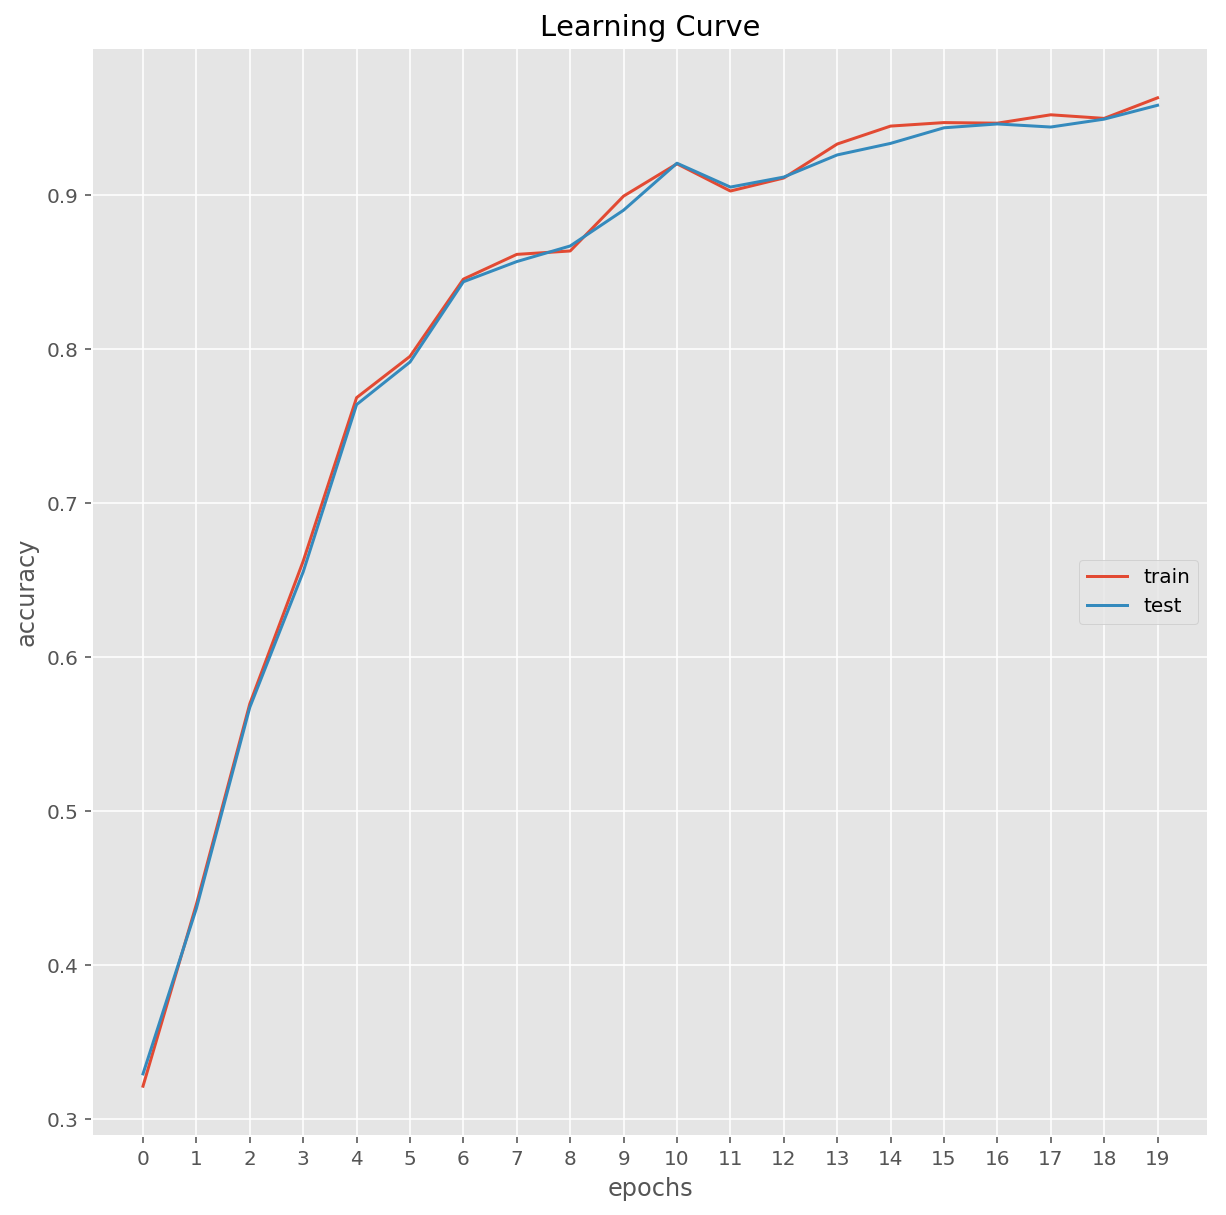

In [28]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_resnet(), make_adam(0.2e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network_resnet_lower_learning_rate.ckpt')
    
show_learning_curve(learning_curve)

## simplified VGG // My model 3

In [26]:
def make_vgg(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([3, 3, 16],padding = 'SAME')  # <== doubled
            .relu()
            .conv([3, 3, 16],padding = 'SAME')
            .max_pool()
            .relu()
            .conv([3, 3,32],padding = 'SAME')  # <== doubled
            .relu()
            .conv([3, 3,32],padding = 'SAME')
            .max_pool()
            .relu()
            .conv([3, 3, 64],padding='SAME')
            .relu()
            .conv([3, 3, 64],padding='SAME')
            .relu()
            .conv([3, 3, 64],padding='SAME')
            .max_pool()
            .relu()
            .conv([3, 3, 128],padding='SAME')
            .relu()
            .conv([3, 3, 128],padding='SAME')
            .relu()
            .conv([3, 3, 128],padding='SAME')
            .max_pool()
            .relu()
            .flatten()
            .dense(480) # <== doubled
            .relu()
            .dense(N_CLASSES))

Epoch:   0 Train Score: 0.804 Evaluation Score: 0.802
Epoch:   1 Train Score: 0.939 Evaluation Score: 0.938
Epoch:   2 Train Score: 0.954 Evaluation Score: 0.948
Epoch:   3 Train Score: 0.974 Evaluation Score: 0.972
Epoch:   4 Train Score: 0.974 Evaluation Score: 0.972
Epoch:   5 Train Score: 0.976 Evaluation Score: 0.972
Epoch:   6 Train Score: 0.977 Evaluation Score: 0.977
Epoch:   7 Train Score: 0.983 Evaluation Score: 0.981
Epoch:   8 Train Score: 0.986 Evaluation Score: 0.985
Epoch:   9 Train Score: 0.963 Evaluation Score: 0.960
Epoch:  10 Train Score: 0.986 Evaluation Score: 0.983
Epoch:  11 Train Score: 0.985 Evaluation Score: 0.984
Epoch:  12 Train Score: 0.987 Evaluation Score: 0.987
Epoch:  13 Train Score: 0.981 Evaluation Score: 0.975
Epoch:  14 Train Score: 0.986 Evaluation Score: 0.984
Epoch:  15 Train Score: 0.989 Evaluation Score: 0.990
Epoch:  16 Train Score: 0.947 Evaluation Score: 0.946
Epoch:  17 Train Score: 0.988 Evaluation Score: 0.985
Epoch:  18 Train Score: 0.98

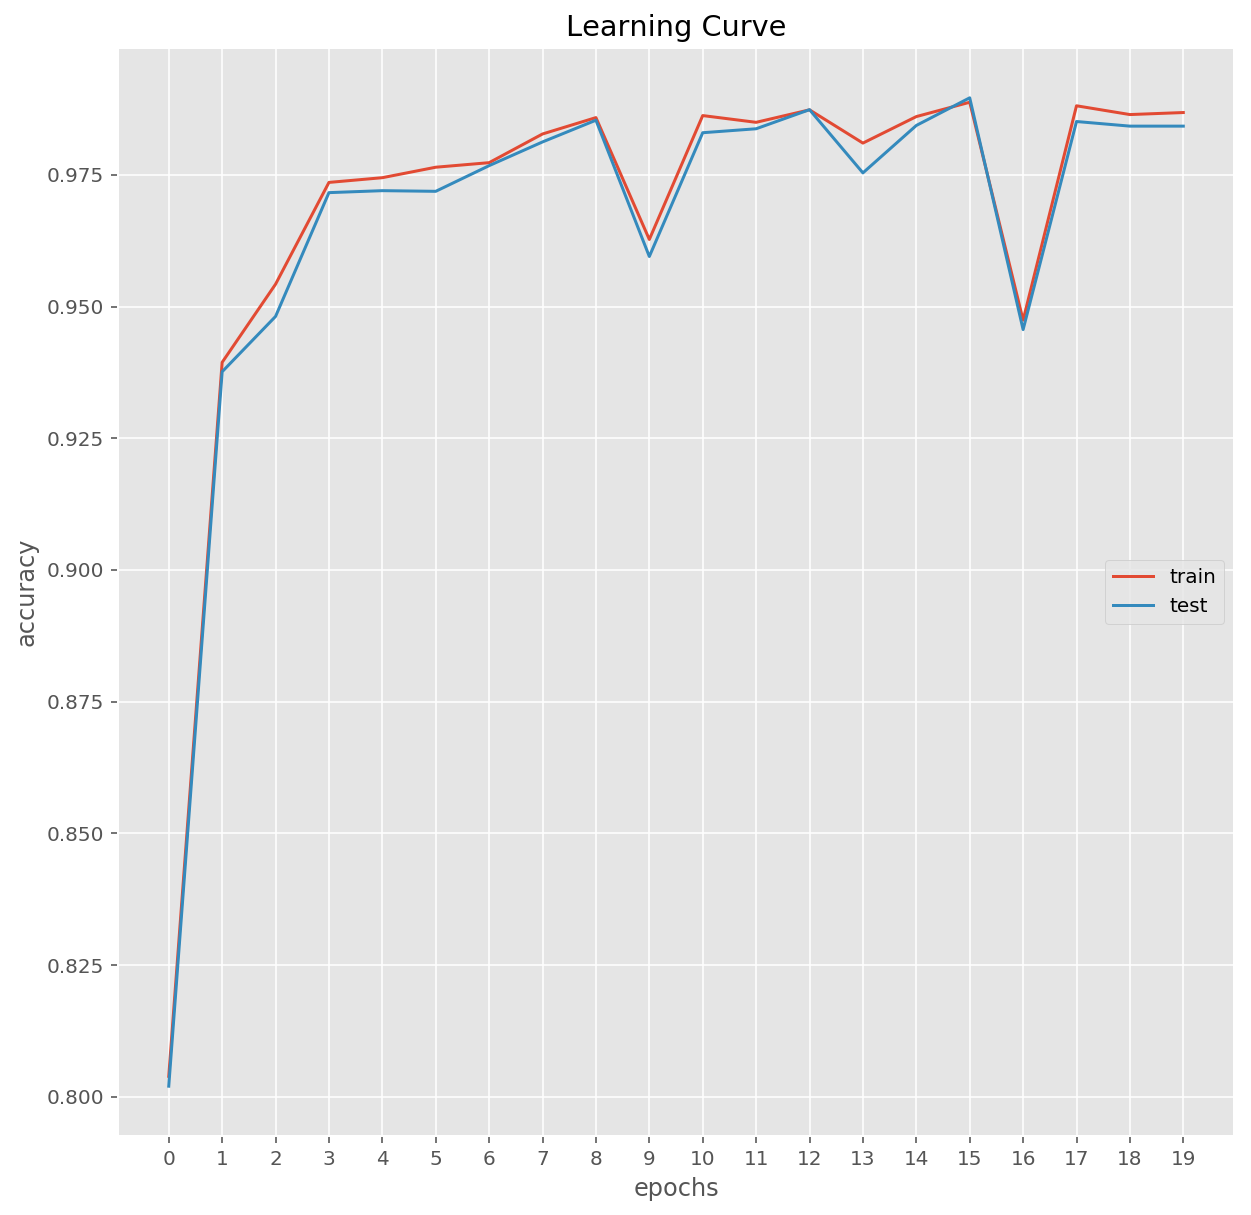

In [43]:

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_vgg(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network_vgg.ckpt')
    
show_learning_curve(learning_curve)

## lower learning rate

Epoch:   0 Train Score: 0.617 Evaluation Score: 0.607
Epoch:   1 Train Score: 0.810 Evaluation Score: 0.810
Epoch:   2 Train Score: 0.895 Evaluation Score: 0.893
Epoch:   3 Train Score: 0.943 Evaluation Score: 0.940
Epoch:   4 Train Score: 0.967 Evaluation Score: 0.967
Epoch:   5 Train Score: 0.960 Evaluation Score: 0.959
Epoch:   6 Train Score: 0.963 Evaluation Score: 0.958
Epoch:   7 Train Score: 0.974 Evaluation Score: 0.976
Epoch:   8 Train Score: 0.979 Evaluation Score: 0.976
Epoch:   9 Train Score: 0.982 Evaluation Score: 0.981
Epoch:  10 Train Score: 0.974 Evaluation Score: 0.973
Epoch:  11 Train Score: 0.984 Evaluation Score: 0.980
Epoch:  12 Train Score: 0.989 Evaluation Score: 0.985
Epoch:  13 Train Score: 0.990 Evaluation Score: 0.988
Epoch:  14 Train Score: 0.990 Evaluation Score: 0.988
Epoch:  15 Train Score: 0.985 Evaluation Score: 0.981
Epoch:  16 Train Score: 0.993 Evaluation Score: 0.991
Epoch:  17 Train Score: 0.987 Evaluation Score: 0.984
Epoch:  18 Train Score: 0.99

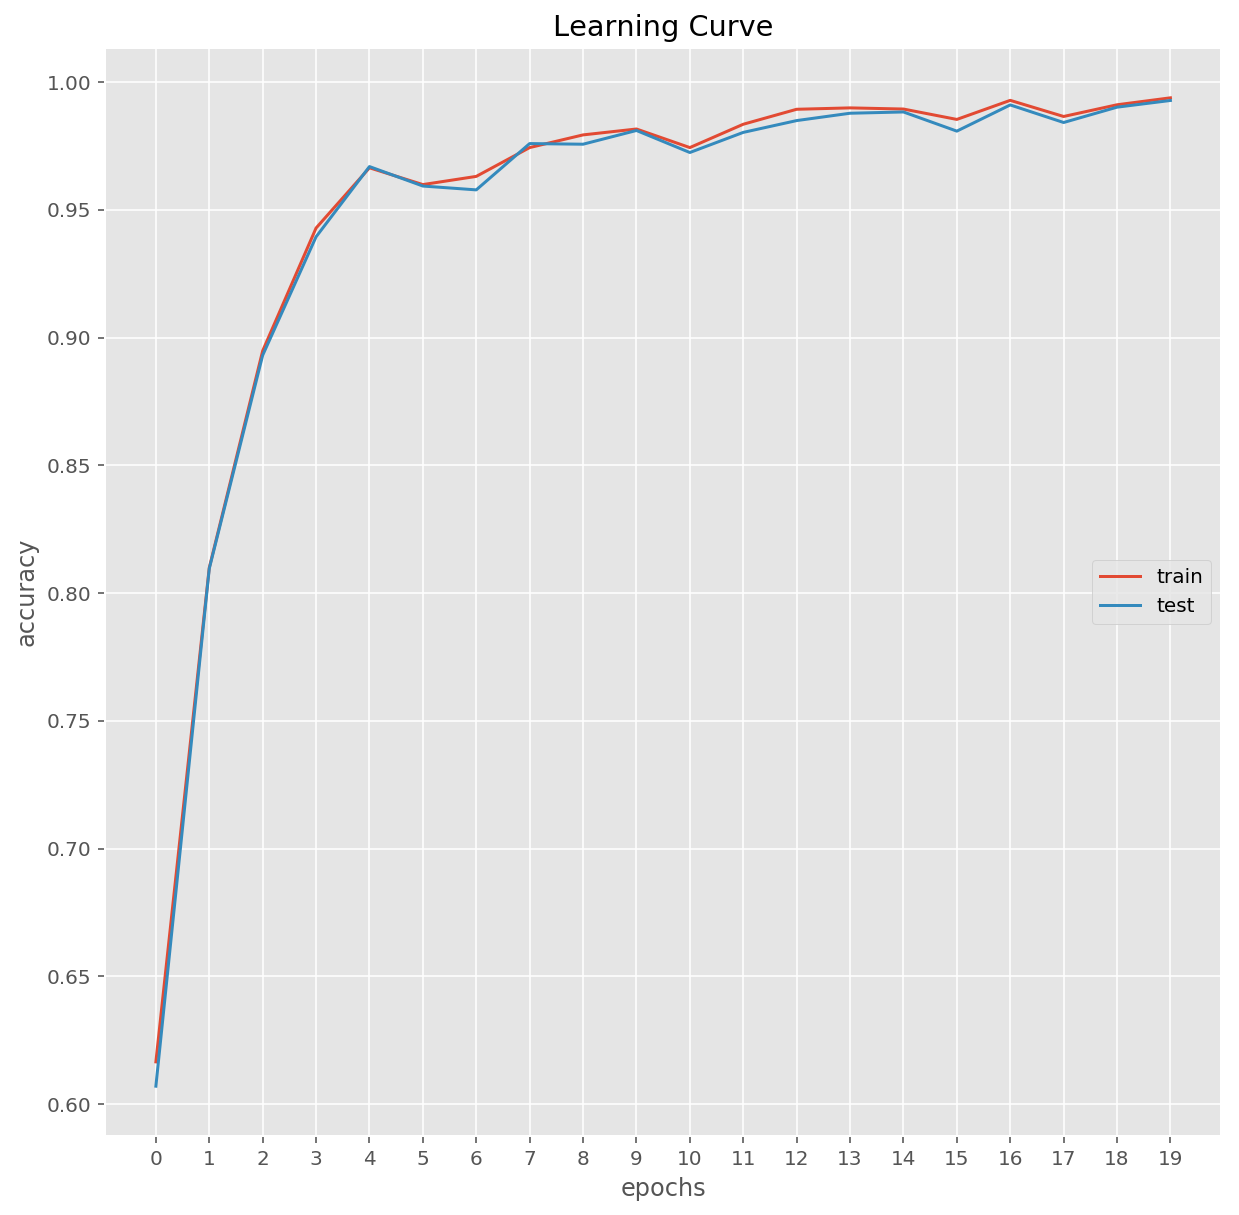

In [44]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_vgg(), make_adam(0.2e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network_vgg_lower_learning_rate.ckpt')
    
show_learning_curve(learning_curve)

## my model

In [27]:
def make_my(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            
            .conv([3, 3, 16],padding = 'SAME')  # <== doubled
            .relu()
            .conv([3, 3, 16],padding = 'SAME')
            .max_pool()
            .relu()
            
            .conv([3, 3,32],padding = 'SAME')  # <== doubled
            .relu()
            .conv([3, 3,32],padding = 'SAME')
            .max_pool()
            .relu()
            
            .conv([3, 3, 64],padding = 'SAME')
            .relu()
            .resnet_block([3, 3])
            .relu()
            .resnet_block([3, 3])
            .relu()
            .resnet_block([3, 3])
            .max_pool()
            .relu()
            
            .conv([3, 3, 128],padding='SAME')
            .relu()
            .conv([3, 3, 128],padding='SAME')
            .relu()
            .conv([3, 3, 128],padding='SAME')
            .max_pool()
            .relu()
            
            .conv([3, 3, 1256],padding='SAME')
            .relu()
            .conv([3, 3, 256],padding='SAME')
            .relu()
            .conv([3, 3, 256],padding='SAME')
            .max_pool()
            .relu()
            
            .dropout(keep_prob=0.8)
            .flatten()
            .dense(480) # <== doubled
            .relu()
            .dense(N_CLASSES))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Epoch:   0 Train Score: 0.126 Evaluation Score: 0.127
Epoch:   1 Train Score: 0.307 Evaluation Score: 0.308
Epoch:   2 Train Score: 0.444 Evaluation Score: 0.439
Epoch:   3 Train Score: 0.614 Evaluation Score: 0.617
Epoch:   4 Train Score: 0.769 Evaluation Score: 0.765
Epoch:   5 Train Score: 0.863 Evaluation Score: 0.856
Epoch:   6 Train Score: 0.882 Evaluation Score: 0.873
Epoch:   7 Train Score: 0.927 Evaluation Score: 0.928
Epoch:   8 Train Score: 0.926 Evaluation Score: 0.928
Epoch:   9 Train Score: 0.944 Evaluation Score: 0.944
Epoch:  10 Train Score: 0.962 Evaluation Score: 0.957
Epoch:  11 Train Score: 0.961 Evaluation Score: 0.956
Epoch:  12 Train Score: 0.971 Evaluation Score: 0.966
Epoch:  13 Train Score: 0.975 Evaluation Score: 0.973
Epoch:  14 Train Score: 0.975 Evaluation Score: 0.975
E

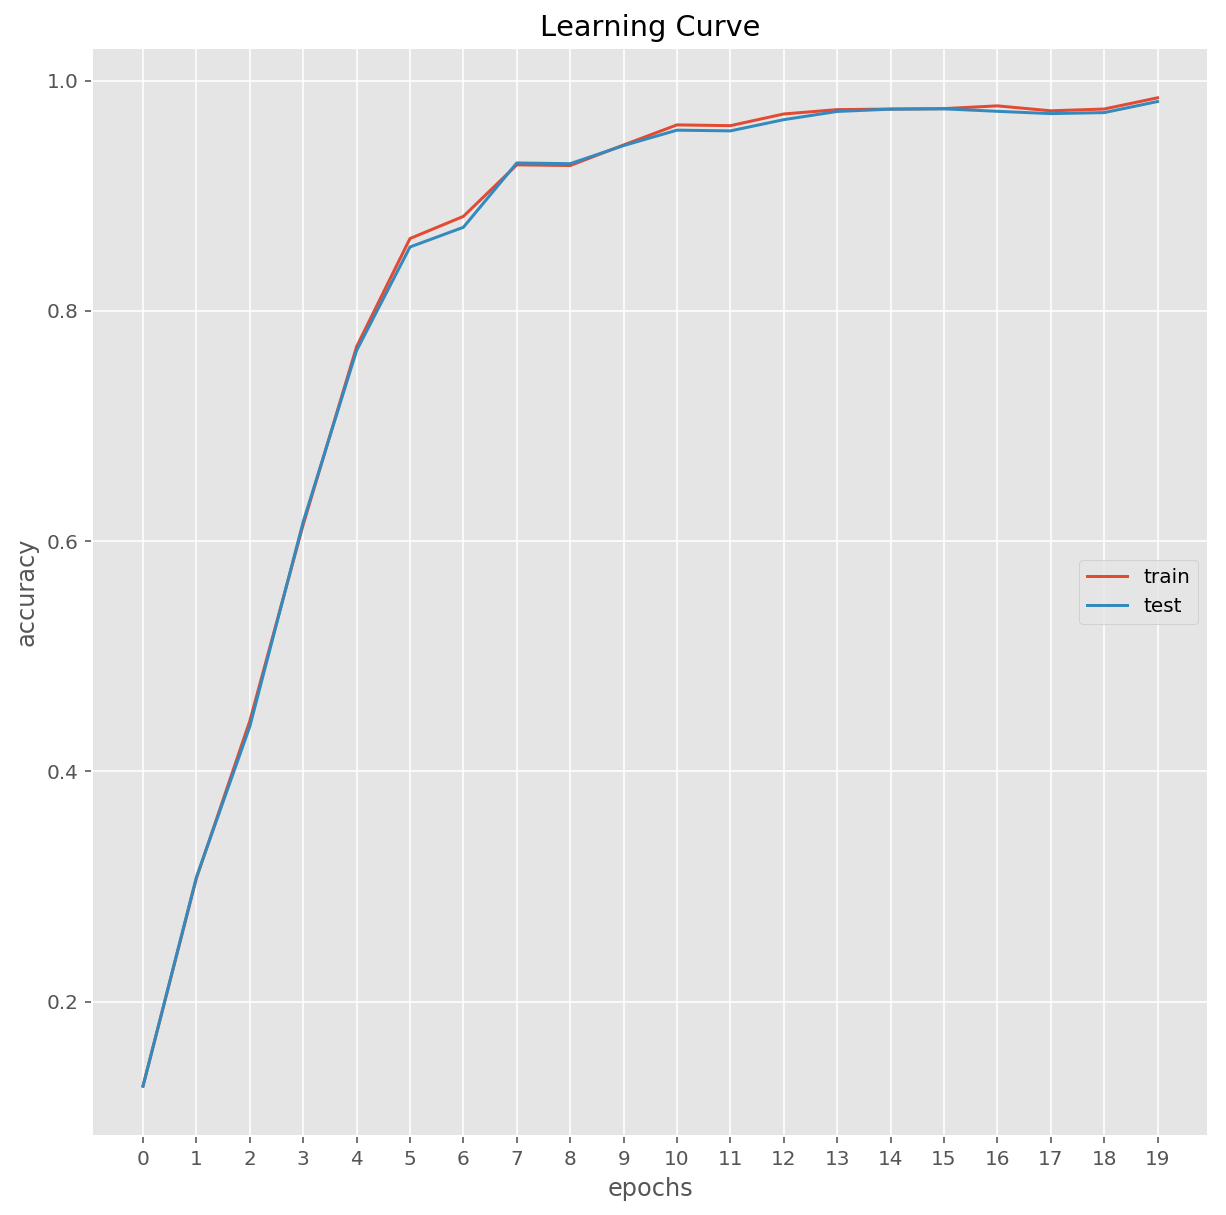

In [27]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_my(), make_adam(0.2e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network_my_lower_learning_rate.ckpt')
    
show_learning_curve(learning_curve)

## more epoch

In [28]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_my(), make_adam(0.2e-3))
    learning_curve = train_evaluate(pipeline, epochs=50)
    session.save('checkpoint/network_my_lower_learning_rate_more_epoch.ckpt')
    
show_learning_curve(learning_curve)

Epoch:   0 Train Score: 0.110 Evaluation Score: 0.111
Epoch:   1 Train Score: 0.259 Evaluation Score: 0.254
Epoch:   2 Train Score: 0.440 Evaluation Score: 0.442
Epoch:   3 Train Score: 0.594 Evaluation Score: 0.589
Epoch:   4 Train Score: 0.769 Evaluation Score: 0.770
Epoch:   5 Train Score: 0.868 Evaluation Score: 0.868
Epoch:   6 Train Score: 0.902 Evaluation Score: 0.902
Epoch:   7 Train Score: 0.933 Evaluation Score: 0.932
Epoch:   8 Train Score: 0.950 Evaluation Score: 0.952
Epoch:   9 Train Score: 0.949 Evaluation Score: 0.952
Epoch:  10 Train Score: 0.969 Evaluation Score: 0.970
Epoch:  11 Train Score: 0.963 Evaluation Score: 0.959
Epoch:  12 Train Score: 0.977 Evaluation Score: 0.976
Epoch:  13 Train Score: 0.980 Evaluation Score: 0.979
Epoch:  14 Train Score: 0.975 Evaluation Score: 0.970
Epoch:  15 Train Score: 0.979 Evaluation Score: 0.975
Epoch:  16 Train Score: 0.970 Evaluation Score: 0.969
Epoch:  17 Train Score: 0.975 Evaluation Score: 0.973
Epoch:  18 Train Score: 0.98

ResourceExhaustedError: checkpoint/checkpoint.tmp77fc42f9fa3146699862976205efd21e; Disk quota exceeded

## My model 2

In [29]:

def make_my2(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            
            .conv([5, 5, 16])  # <== doubled
            .local_response_normalize(radius = 2, alpha = 2e-05, beta = 0.75, bias = 1.0)
            .max_pool()
            .relu()
            .conv([5, 5,32])  # <== doubled
            .local_response_normalize(radius = 2, alpha = 2e-05, beta = 0.75, bias = 1.0)
            .max_pool()
            .relu()
            
            .conv([3, 3, 64],padding='SAME')
            .relu()
            .conv([3, 3, 64],padding='SAME')
            .relu()
            .conv([3, 3, 64],padding='SAME')
            .max_pool()
            .relu()
            
            .conv([3, 3, 128],padding='SAME')
            .relu()
            .conv([3, 3, 128],padding='SAME')
            .relu()
            .conv([3, 3, 128],padding='SAME')
            .max_pool()
            .relu()
            
            .dropout(keep_prob=0.8)
            .flatten()
            .dense(480) # <== doubled
            .relu()
            .dense(N_CLASSES))

Epoch:   0 Train Score: 0.575 Evaluation Score: 0.574
Epoch:   1 Train Score: 0.761 Evaluation Score: 0.758
Epoch:   2 Train Score: 0.856 Evaluation Score: 0.855
Epoch:   3 Train Score: 0.868 Evaluation Score: 0.864
Epoch:   4 Train Score: 0.920 Evaluation Score: 0.916
Epoch:   5 Train Score: 0.931 Evaluation Score: 0.928
Epoch:   6 Train Score: 0.950 Evaluation Score: 0.945
Epoch:   7 Train Score: 0.954 Evaluation Score: 0.953
Epoch:   8 Train Score: 0.954 Evaluation Score: 0.953
Epoch:   9 Train Score: 0.958 Evaluation Score: 0.959
Epoch:  10 Train Score: 0.972 Evaluation Score: 0.972
Epoch:  11 Train Score: 0.972 Evaluation Score: 0.972
Epoch:  12 Train Score: 0.971 Evaluation Score: 0.969
Epoch:  13 Train Score: 0.976 Evaluation Score: 0.973
Epoch:  14 Train Score: 0.974 Evaluation Score: 0.972
Epoch:  15 Train Score: 0.970 Evaluation Score: 0.968
Epoch:  16 Train Score: 0.971 Evaluation Score: 0.969
Epoch:  17 Train Score: 0.979 Evaluation Score: 0.975
Epoch:  18 Train Score: 0.98

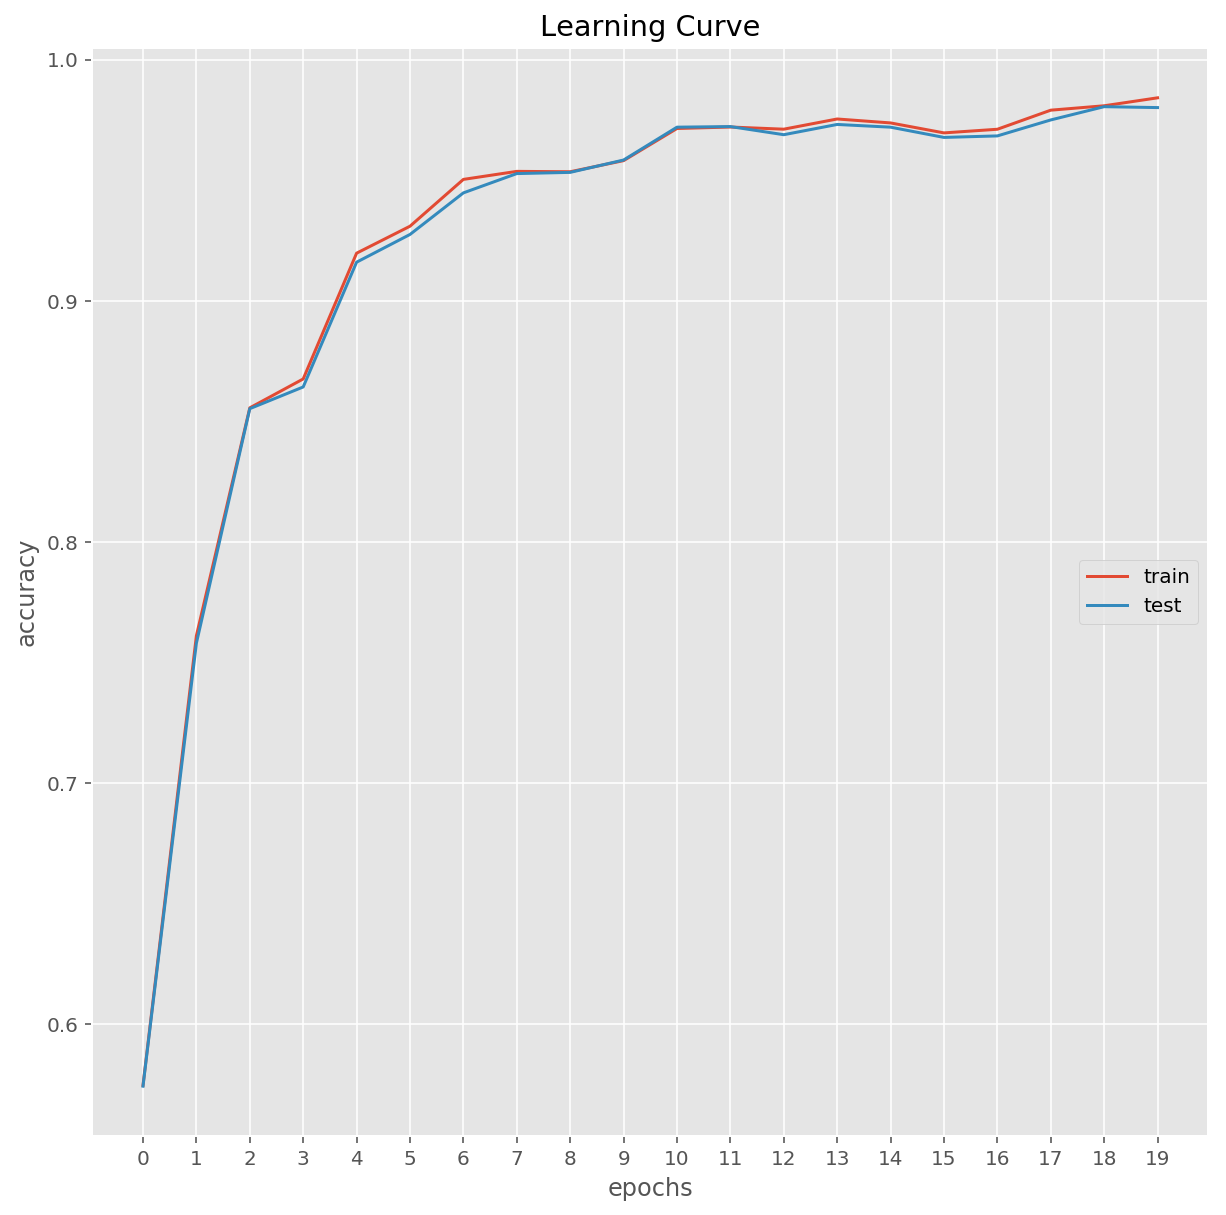

In [32]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_my2(), make_adam(0.2e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network_my2_lower_learning_rate_more_epoch.ckpt')
    
show_learning_curve(learning_curve)2

Epoch:   0 Train Score: 0.591 Evaluation Score: 0.597
Epoch:   1 Train Score: 0.758 Evaluation Score: 0.752
Epoch:   2 Train Score: 0.852 Evaluation Score: 0.848
Epoch:   3 Train Score: 0.889 Evaluation Score: 0.882
Epoch:   4 Train Score: 0.913 Evaluation Score: 0.910
Epoch:   5 Train Score: 0.929 Evaluation Score: 0.930
Epoch:   6 Train Score: 0.944 Evaluation Score: 0.943
Epoch:   7 Train Score: 0.939 Evaluation Score: 0.936
Epoch:   8 Train Score: 0.959 Evaluation Score: 0.959
Epoch:   9 Train Score: 0.966 Evaluation Score: 0.960
Epoch:  10 Train Score: 0.967 Evaluation Score: 0.966
Epoch:  11 Train Score: 0.970 Evaluation Score: 0.968
Epoch:  12 Train Score: 0.972 Evaluation Score: 0.970
Epoch:  13 Train Score: 0.969 Evaluation Score: 0.968
Epoch:  14 Train Score: 0.975 Evaluation Score: 0.972
Epoch:  15 Train Score: 0.984 Evaluation Score: 0.982
Epoch:  16 Train Score: 0.978 Evaluation Score: 0.975
Epoch:  17 Train Score: 0.983 Evaluation Score: 0.979
Epoch:  18 Train Score: 0.98

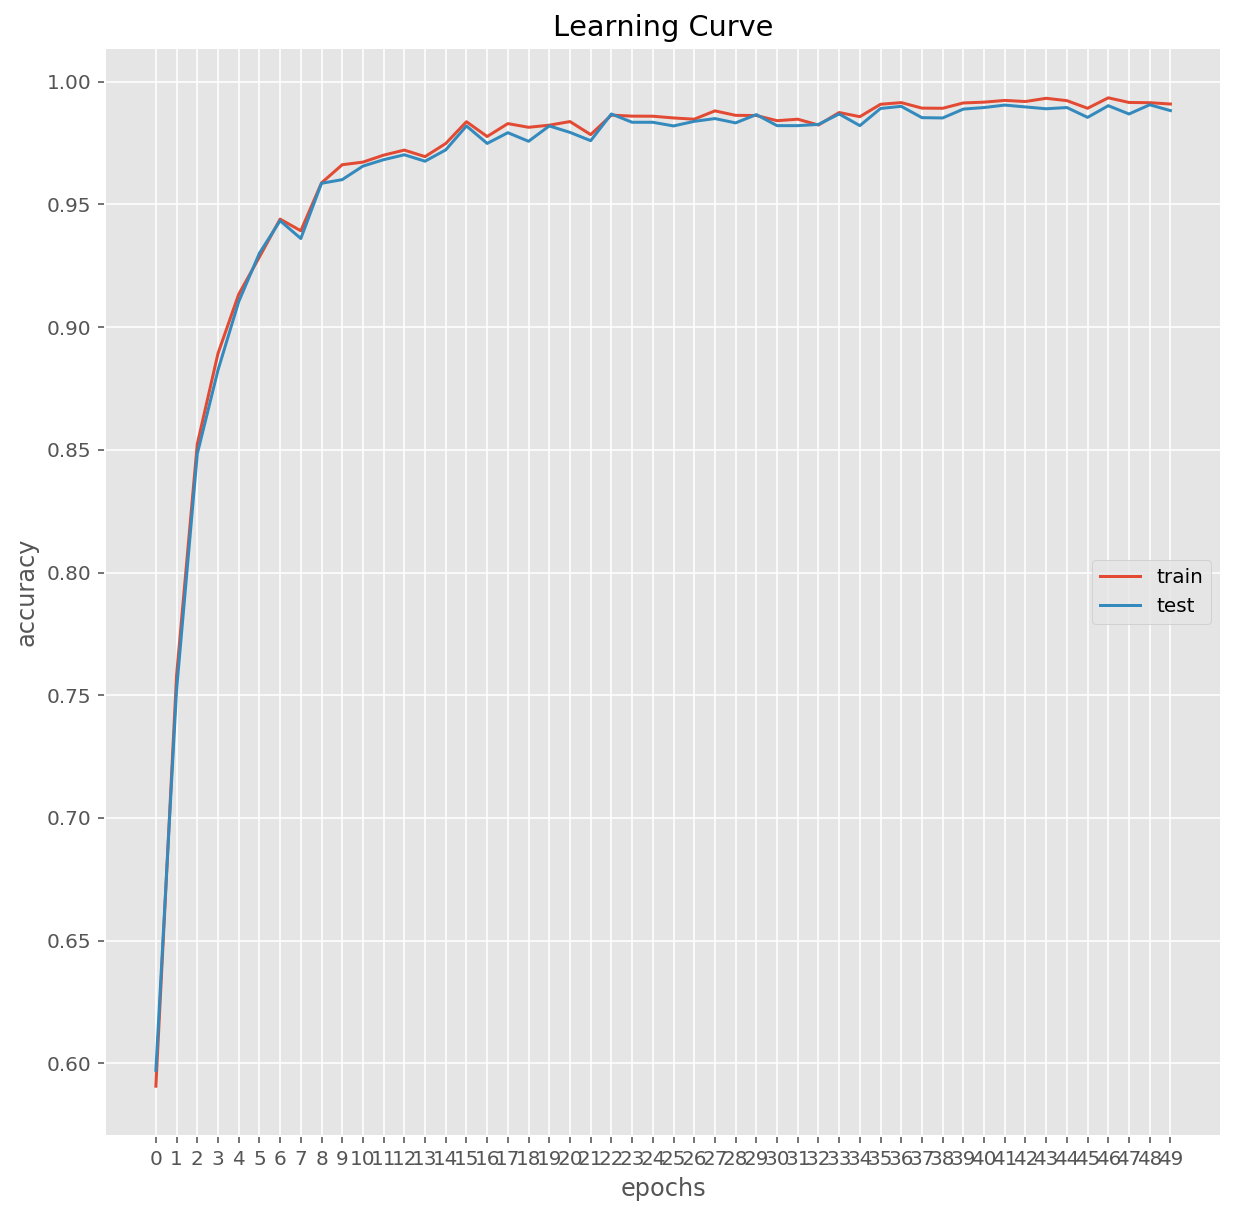

In [30]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_my2(), make_adam(0.2e-3))
    learning_curve = train_evaluate(pipeline, epochs=50)
    session.save('checkpoint/network_my2_much_more_epoch.ckpt')
    
show_learning_curve(learning_curve)

## real VGG

In [28]:
def make_my3(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([3, 3, 16],padding = 'SAME')  # <== doubled
            .relu()  
            .conv([3, 3, 16],padding = 'SAME')
            .max_pool()
            .relu()
            
            .conv([3, 3,32],padding = 'SAME')  # <== doubled
            .relu()
            .conv([3, 3,32],padding = 'SAME')
            .max_pool()
            .relu()
            
            .conv([3, 3, 64],padding='SAME')
            .relu()
            .conv([3, 3, 64],padding='SAME')
            .relu()
            .conv([3, 3, 64],padding='SAME')
            .max_pool()
            .relu()
            
            .conv([3, 3, 128],padding='SAME')
            .relu()
            .conv([3, 3, 128],padding='SAME')
            .relu()
            .conv([3, 3, 128],padding='SAME')
            .max_pool()
            .relu()
            
            .conv([3, 3, 256],padding='SAME')
            .relu()
            .conv([3, 3, 256],padding='SAME')
            .relu()
            .conv([3, 3, 256],padding='SAME')
            .max_pool()
            .relu()
            .flatten()
            .dense(480) # <== doubled
            .relu()
            .dense(N_CLASSES))

Epoch:   0 Train Score: 0.482 Evaluation Score: 0.471
Epoch:   1 Train Score: 0.696 Evaluation Score: 0.695
Epoch:   2 Train Score: 0.823 Evaluation Score: 0.824
Epoch:   3 Train Score: 0.880 Evaluation Score: 0.880
Epoch:   4 Train Score: 0.921 Evaluation Score: 0.915
Epoch:   5 Train Score: 0.941 Evaluation Score: 0.938
Epoch:   6 Train Score: 0.969 Evaluation Score: 0.968
Epoch:   7 Train Score: 0.966 Evaluation Score: 0.964
Epoch:   8 Train Score: 0.964 Evaluation Score: 0.960
Epoch:   9 Train Score: 0.965 Evaluation Score: 0.965
Epoch:  10 Train Score: 0.975 Evaluation Score: 0.970
Epoch:  11 Train Score: 0.979 Evaluation Score: 0.978
Epoch:  12 Train Score: 0.981 Evaluation Score: 0.979
Epoch:  13 Train Score: 0.979 Evaluation Score: 0.978
Epoch:  14 Train Score: 0.983 Evaluation Score: 0.981
Epoch:  15 Train Score: 0.985 Evaluation Score: 0.982
Epoch:  16 Train Score: 0.981 Evaluation Score: 0.982
Epoch:  17 Train Score: 0.991 Evaluation Score: 0.988
Epoch:  18 Train Score: 0.98

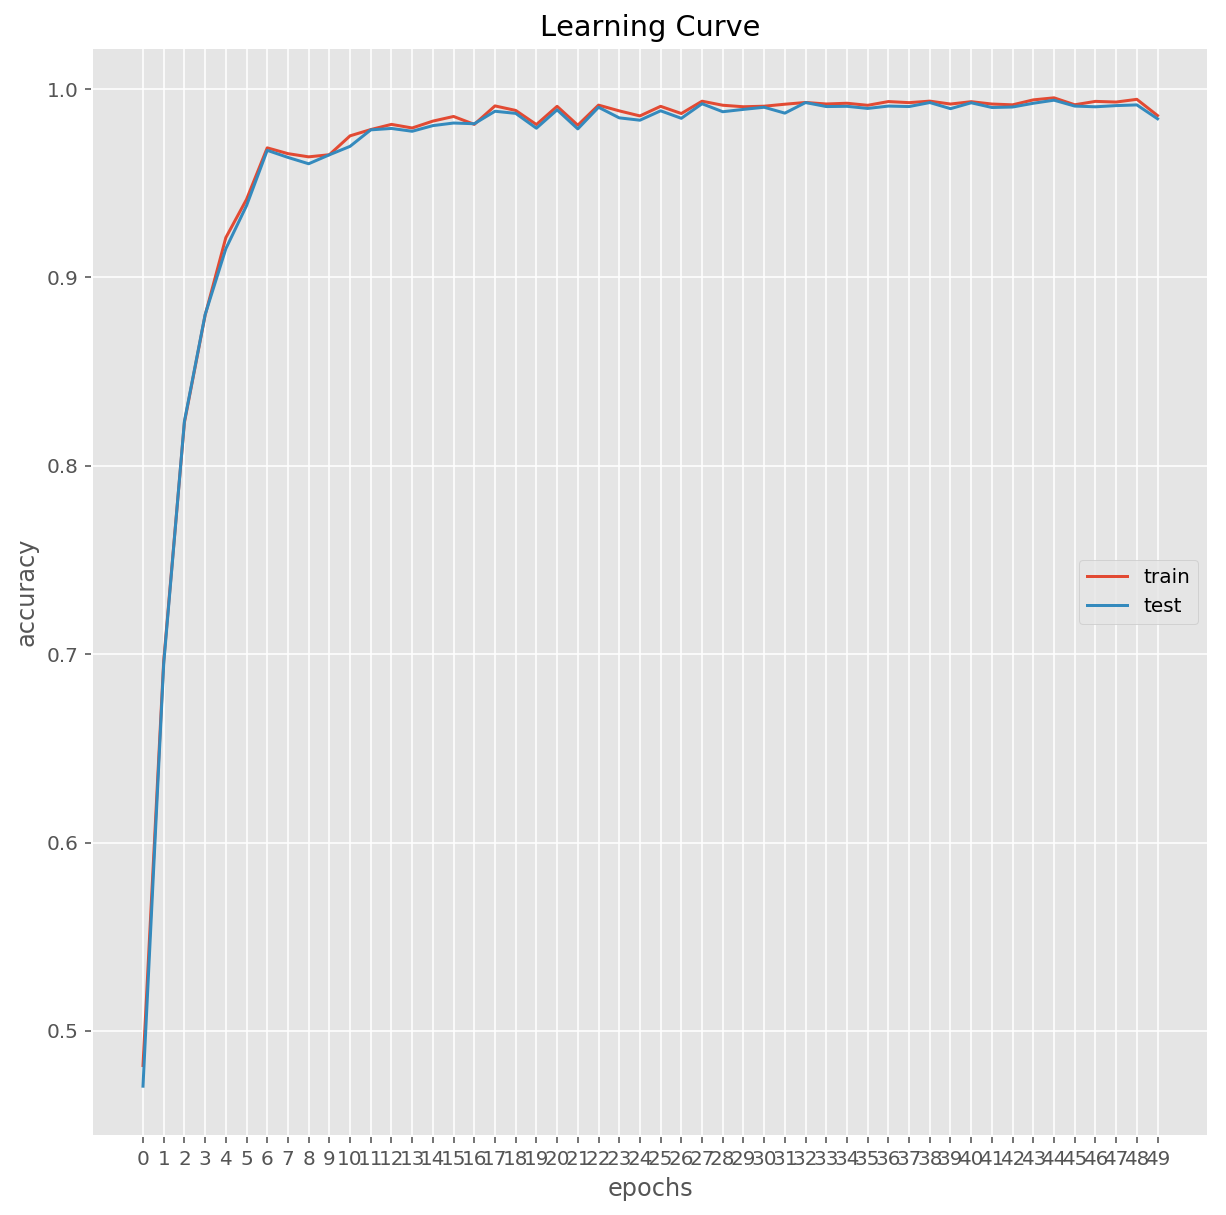

In [29]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_my3(), make_adam(0.2e-3))
    learning_curve = train_evaluate(pipeline, epochs=50)
    session.save('checkpoint/network_my3.ckpt')
    
show_learning_curve(learning_curve)

In [28]:
def make_my4(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([3, 3, 16],padding = 'SAME')  # <== doubled
            .relu()  
            .conv([3, 3, 16],padding = 'SAME')
            .local_response_normalize(radius = 2, alpha = 2e-05, beta = 0.75, bias = 1.0)
            .max_pool()
            .relu()
            
            .conv([3, 3,32],padding = 'SAME')  # <== doubled
            .relu()
            .conv([3, 3,32],padding = 'SAME')
            .local_response_normalize(radius = 2, alpha = 2e-05, beta = 0.75, bias = 1.0)
            .max_pool()
            .relu()
            
            .conv([3, 3, 64],padding='SAME')
            .relu()
            .conv([3, 3, 64],padding='SAME')
            .relu()
            .conv([3, 3, 64],padding='SAME')
            .max_pool()
            .relu()
            
            .conv([3, 3, 128],padding='SAME')
            .relu()
            .conv([3, 3, 128],padding='SAME')
            .relu()
            .conv([3, 3, 128],padding='SAME')
            .max_pool()
            .relu()
            
            .conv([3, 3, 256],padding='SAME')
            .relu()
            .conv([3, 3, 256],padding='SAME')
            .relu()
            .conv([3, 3, 256],padding='SAME')
            .max_pool()
            .relu()
            
            .flatten()
            .dense(480) # <== doubled
            .relu()
            .dense(480) # <== doubled
            .relu()
            .dense(N_CLASSES))

Epoch:   0 Train Score: 0.390 Evaluation Score: 0.391
Epoch:   1 Train Score: 0.582 Evaluation Score: 0.586
Epoch:   2 Train Score: 0.763 Evaluation Score: 0.761
Epoch:   3 Train Score: 0.807 Evaluation Score: 0.800
Epoch:   4 Train Score: 0.898 Evaluation Score: 0.896
Epoch:   5 Train Score: 0.930 Evaluation Score: 0.927
Epoch:   6 Train Score: 0.950 Evaluation Score: 0.952
Epoch:   7 Train Score: 0.953 Evaluation Score: 0.952
Epoch:   8 Train Score: 0.951 Evaluation Score: 0.947
Epoch:   9 Train Score: 0.964 Evaluation Score: 0.963
Epoch:  10 Train Score: 0.977 Evaluation Score: 0.971
Epoch:  11 Train Score: 0.974 Evaluation Score: 0.972
Epoch:  12 Train Score: 0.972 Evaluation Score: 0.969
Epoch:  13 Train Score: 0.984 Evaluation Score: 0.980
Epoch:  14 Train Score: 0.978 Evaluation Score: 0.976
Epoch:  15 Train Score: 0.988 Evaluation Score: 0.985
Epoch:  16 Train Score: 0.986 Evaluation Score: 0.984
Epoch:  17 Train Score: 0.979 Evaluation Score: 0.979
Epoch:  18 Train Score: 0.98

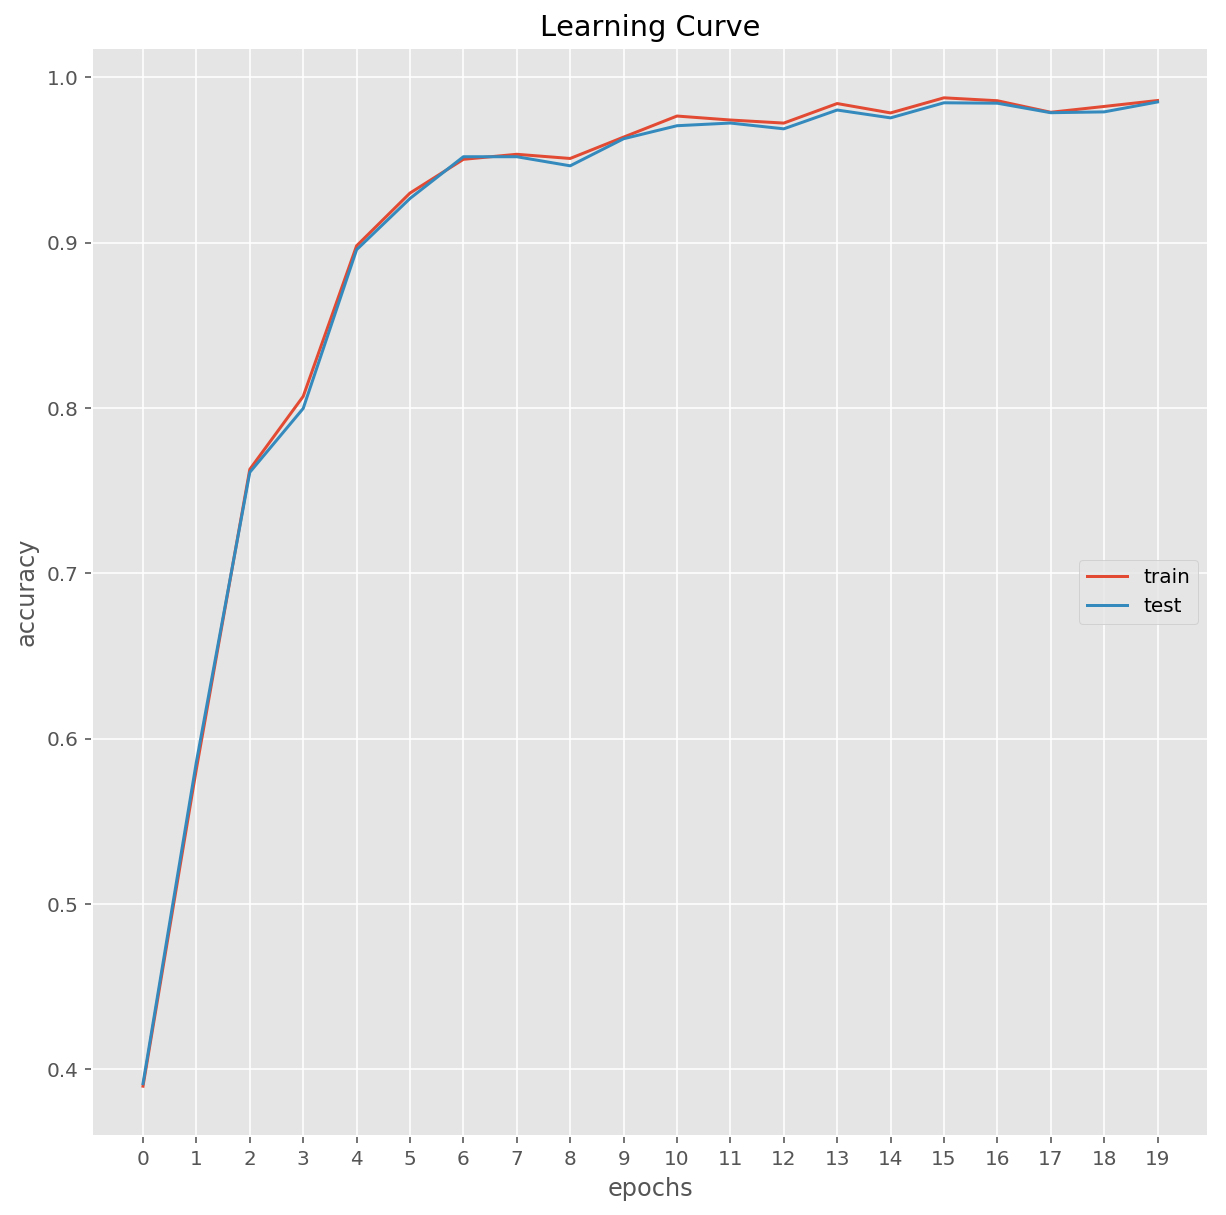

In [29]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_my4(), make_adam(0.2e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network_my4_less_epoch.ckpt')
    
show_learning_curve(learning_curve)

## my  model 5

In [26]:
def make_my5(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([3, 3, 16],padding = 'SAME')  # <== doubled
            .relu()  
            .conv([3, 3, 16],padding = 'SAME')
            .local_response_normalize(radius = 2, alpha = 2e-05, beta = 0.75, bias = 1.0)
            .max_pool()
            .relu()
            
            .conv([3, 3,32],padding = 'SAME')  # <== doubled
            .relu()
            .conv([3, 3,32],padding = 'SAME')
            .local_response_normalize(radius = 2, alpha = 2e-05, beta = 0.75, bias = 1.0)
            .max_pool()
            .relu()
            
            .conv([3, 3, 64],padding='SAME')
            .relu()
            .conv([3, 3, 64],padding='SAME')
            .relu()
            .conv([3, 3, 64],padding='SAME')
            .max_pool()
            .relu()
            
            .conv([3, 3, 128],padding='SAME')
            .relu()
            .conv([3, 3, 128],padding='SAME')
            .relu()
            .conv([3, 3, 128],padding='SAME')
            .max_pool()
            .relu()
            
            .conv([3, 3, 256],padding='SAME')
            .relu()
            .conv([3, 3, 256],padding='SAME')
            .relu()
            .conv([3, 3, 256],padding='SAME')
            .max_pool()
            .relu()
            
            .dropout(keep_prob=0.8) 
            .flatten()
            .dense(480) # <== doubled
            .relu()
            .dense(480) # <== doubled
            .relu()
            .dense(N_CLASSES))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Epoch:   0 Train Score: 0.386 Evaluation Score: 0.381
Epoch:   1 Train Score: 0.521 Evaluation Score: 0.519
Epoch:   2 Train Score: 0.733 Evaluation Score: 0.723
Epoch:   3 Train Score: 0.859 Evaluation Score: 0.859
Epoch:   4 Train Score: 0.914 Evaluation Score: 0.909
Epoch:   5 Train Score: 0.933 Evaluation Score: 0.931
Epoch:   6 Train Score: 0.962 Evaluation Score: 0.953
Epoch:   7 Train Score: 0.954 Evaluation Score: 0.954
Epoch:   8 Train Score: 0.968 Evaluation Score: 0.965
Epoch:   9 Train Score: 0.969 Evaluation Score: 0.967
Epoch:  10 Train Score: 0.978 Evaluation Score: 0.974
Epoch:  11 Train Score: 0.975 Evaluation Score: 0.974
Epoch:  12 Train Score: 0.977 Evaluation Score: 0.976
Epoch:  13 Train Score: 0.974 Evaluation Score: 0.972
Epoch:  14 Train Score: 0.983 Evaluation Score: 0.981
E

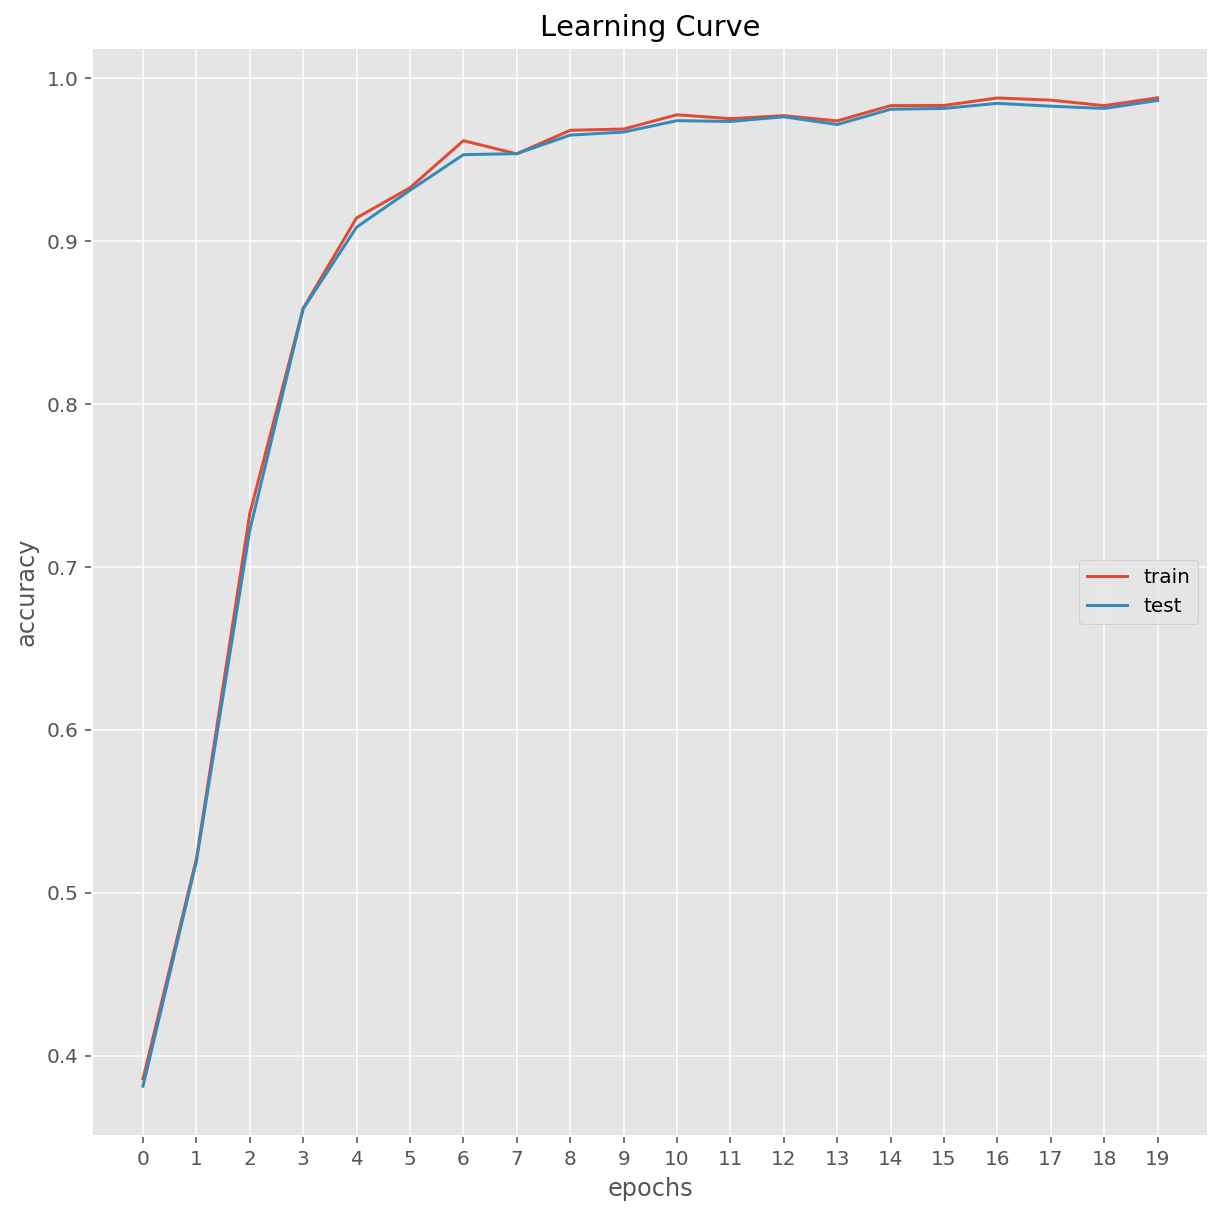

In [27]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_my5(), make_adam(0.2e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network_my5_less_epoch.ckpt')
    
show_learning_curve(learning_curve)

## my model 6

In [26]:
def make_my6(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([3, 3, 16],padding = 'SAME')  # <== doubled
            .relu()
            .conv([3, 3, 16],padding = 'SAME')
            .max_pool()
            .relu()
            
            .single_block([3,3])
            .relu()
            .single_block([3,3])
            .relu()
            .single_block([3,3])
            .relu()
            
            .conv([3, 3,32],padding = 'SAME')  # <== doubled
            .relu()
            .conv([3, 3,32],padding = 'SAME')
            .max_pool()
            .relu()
            
            .conv([3, 3, 64],padding='SAME')
            .relu()
            .conv([3, 3, 64],padding='SAME')
            .relu()
            .conv([3, 3, 64],padding='SAME')
            .max_pool()
            .relu()
            
            .conv([3, 3, 128],padding='SAME')
            .relu()
            .conv([3, 3, 128],padding='SAME')
            .relu()
            .conv([3, 3, 128],padding='SAME')
            .max_pool()
            .relu()
            
            .dropout(keep_prob=0.7) 
            .flatten()
            .dense(480) # <== doubled
            .relu()
            .dense(N_CLASSES))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Epoch:   0 Train Score: 0.547 Evaluation Score: 0.541
Epoch:   1 Train Score: 0.754 Evaluation Score: 0.749
Epoch:   3 Train Score: 0.876 Evaluation Score: 0.877
Epoch:   4 Train Score: 0.949 Evaluation Score: 0.944
Epoch:   5 Train Score: 0.953 Evaluation Score: 0.952
Epoch:   6 Train Score: 0.971 Evaluation Score: 0.971
Epoch:   7 Train Score: 0.964 Evaluation Score: 0.965
Epoch:   8 Train Score: 0.979 Evaluation Score: 0.978
Epoch:   9 Train Score: 0.979 Evaluation Score: 0.977
Epoch:  10 Train Score: 0.980 Evaluation Score: 0.978
Epoch:  11 Train Score: 0.985 Evaluation Score: 0.983
Epoch:  12 Train Score: 0.982 Evaluation Score: 0.978
Epoch:  13 Train Score: 0.982 Evaluation Score: 0.979
Epoch:  14 Train Score: 0.987 Evaluation Score: 0.981
Epoch:  15 Train Score: 0.986 Evaluation Score: 0.984
E

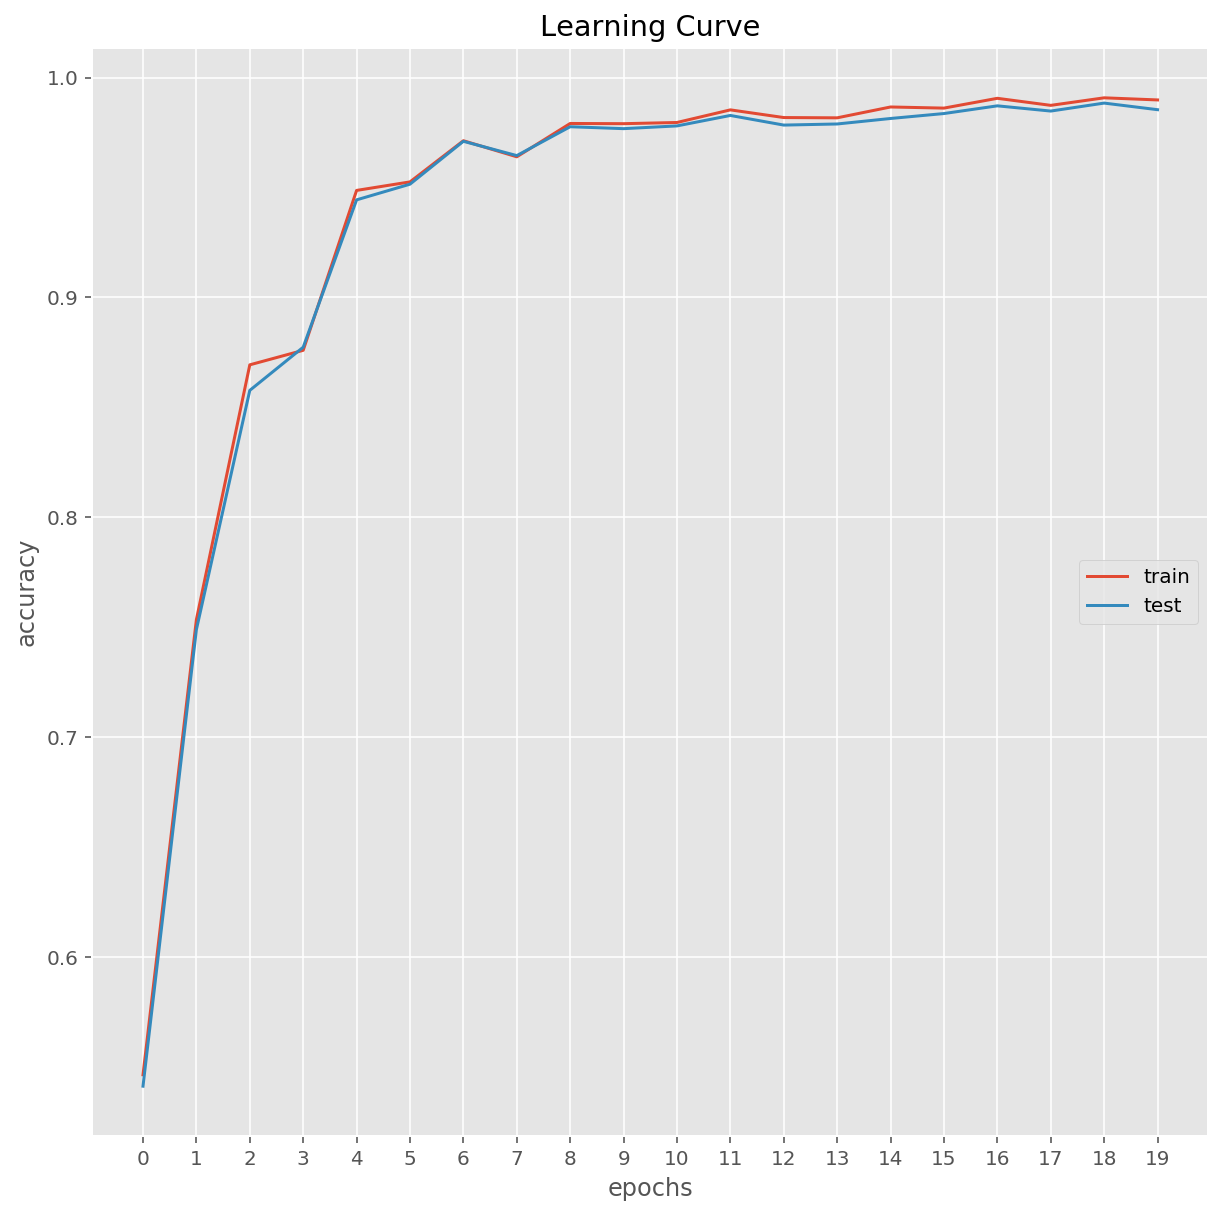

In [27]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_my6(), make_adam(0.2e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network_my6.ckpt')
    
show_learning_curve(learning_curve)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Epoch:   0 Train Score: 0.683 Evaluation Score: 0.685
Epoch:   1 Train Score: 0.855 Evaluation Score: 0.855
Epoch:   2 Train Score: 0.929 Evaluation Score: 0.926
Epoch:   3 Train Score: 0.950 Evaluation Score: 0.944
Epoch:   4 Train Score: 0.959 Evaluation Score: 0.955
Epoch:   5 Train Score: 0.973 Evaluation Score: 0.970
Epoch:   6 Train Score: 0.980 Evaluation Score: 0.980
Epoch:   7 Train Score: 0.981 Evaluation Score: 0.978
Epoch:   8 Train Score: 0.986 Evaluation Score: 0.984
Epoch:   9 Train Score: 0.987 Evaluation Score: 0.985
Epoch:  10 Train Score: 0.989 Evaluation Score: 0.989
Epoch:  11 Train Score: 0.991 Evaluation Score: 0.990
Epoch:  12 Train Score: 0.991 Evaluation Score: 0.987
Epoch:  13 Train Score: 0.992 Evaluation Score: 0.990
Epoch:  14 Train Score: 0.988 Evaluation Score: 0.985
E

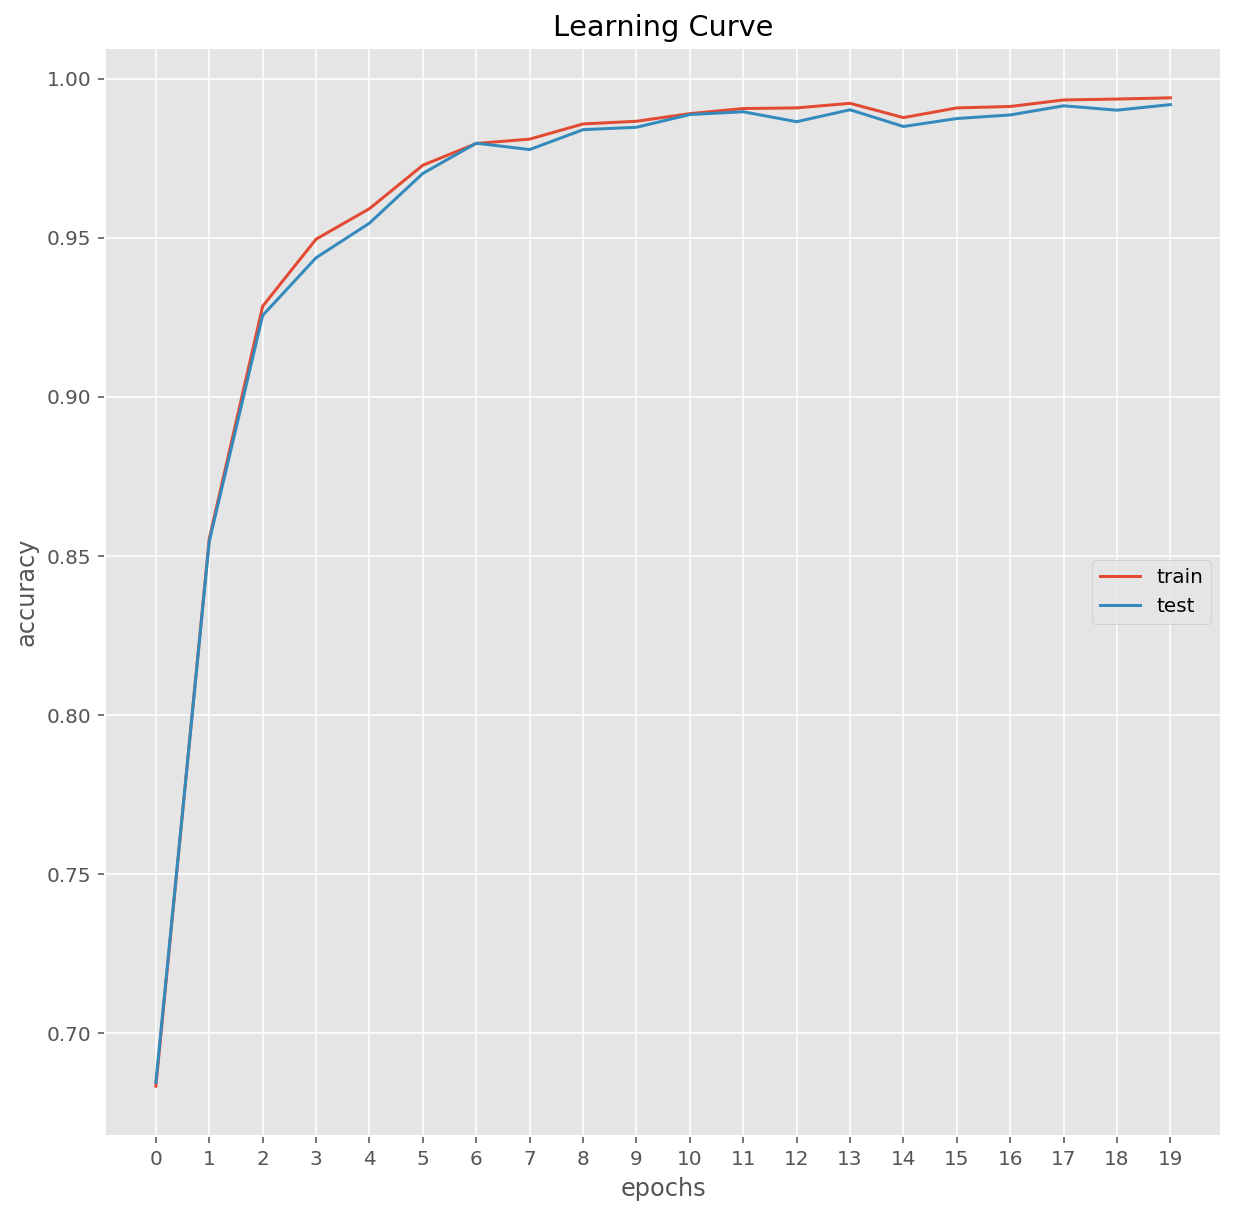

In [26]:
def make_my7(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24]) # <== doubled
            .max_pool()
            .relu()
            
            .single_block([3,3])
            .relu()
            .single_block([3,3])
            .relu()
            .single_block([3,3])
            .relu()
            
            .conv([5, 5, 64]) # <== doubled
            .max_pool()
            .relu()
            .dropout(keep_prob=0.8) 
            .flatten()
            .dense(480)  # <== doubled
            .relu()
            .dense(N_CLASSES))
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_my7(), make_adam(0.2e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network_my7.ckpt')
    
show_learning_curve(learning_curve)

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_my7())
    session.load('checkpoint/network_my7.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

In [ ]:
def make_my8(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([3, 3, 16],padding = 'SAME')  # <== doubled
            .relu()
            .conv([3, 3, 16],padding = 'SAME')
            .max_pool()
            .relu()
            
            .single_block([3,3])
            .relu()
            .single_block([3,3])
            .relu()
            .single_block([3,3])
            .relu()
            
            .conv([3, 3,32],padding = 'SAME')  # <== doubled
            .relu()
            .conv([3, 3,32],padding = 'SAME')
            .max_pool()
            .relu()
            
            .conv([3, 3, 64],padding='SAME')
            .relu()
            .conv([3, 3, 64],padding='SAME')
            .relu()
            .conv([3, 3, 64],padding='SAME')
            .max_pool()
            .relu()
            
            .conv([3, 3, 128],padding='SAME')
            .relu()
            .conv([3, 3, 128],padding='SAME')
            .relu()
            .conv([3, 3, 128],padding='SAME')
            .max_pool()
            .relu()
            .flatten()
            .dense(480) # <== doubled
            .relu()
            .dense(N_CLASSES))
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_my8(), make_adam(0.2e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network_my8.ckpt')
    
show_learning_curve(learning_curve)

Epoch:   0 Train Score: 0.587 Evaluation Score: 0.592
Epoch:   1 Train Score: 0.776 Evaluation Score: 0.775
Epoch:   2 Train Score: 0.898 Evaluation Score: 0.894
Epoch:   3 Train Score: 0.919 Evaluation Score: 0.919
Epoch:   4 Train Score: 0.960 Evaluation Score: 0.957
Epoch:   5 Train Score: 0.965 Evaluation Score: 0.963
Epoch:   6 Train Score: 0.953 Evaluation Score: 0.953
Epoch:   7 Train Score: 0.980 Evaluation Score: 0.975
Epoch:   8 Train Score: 0.982 Evaluation Score: 0.978
Epoch:   9 Train Score: 0.982 Evaluation Score: 0.979
Epoch:  10 Train Score: 0.975 Evaluation Score: 0.970
Epoch:  11 Train Score: 0.986 Evaluation Score: 0.983
Epoch:  12 Train Score: 0.988 Evaluation Score: 0.987
Epoch:  13 Train Score: 0.988 Evaluation Score: 0.986
Epoch:  14 Train Score: 0.986 Evaluation Score: 0.984
Epoch:  15 Train Score: 0.987 Evaluation Score: 0.985
Epoch:  16 Train Score: 0.988 Evaluation Score: 0.986
Epoch:  17 Train Score: 0.986 Evaluation Score: 0.986


## Network 2

Doubling all filters in the convolutional layers and neurons in the dense layers.

Epoch:   0 Train Score: 0.836 Evaluation Score: 0.832
Epoch:   1 Train Score: 0.925 Evaluation Score: 0.922
Epoch:   2 Train Score: 0.942 Evaluation Score: 0.940
Epoch:   3 Train Score: 0.952 Evaluation Score: 0.945
Epoch:   4 Train Score: 0.965 Evaluation Score: 0.966


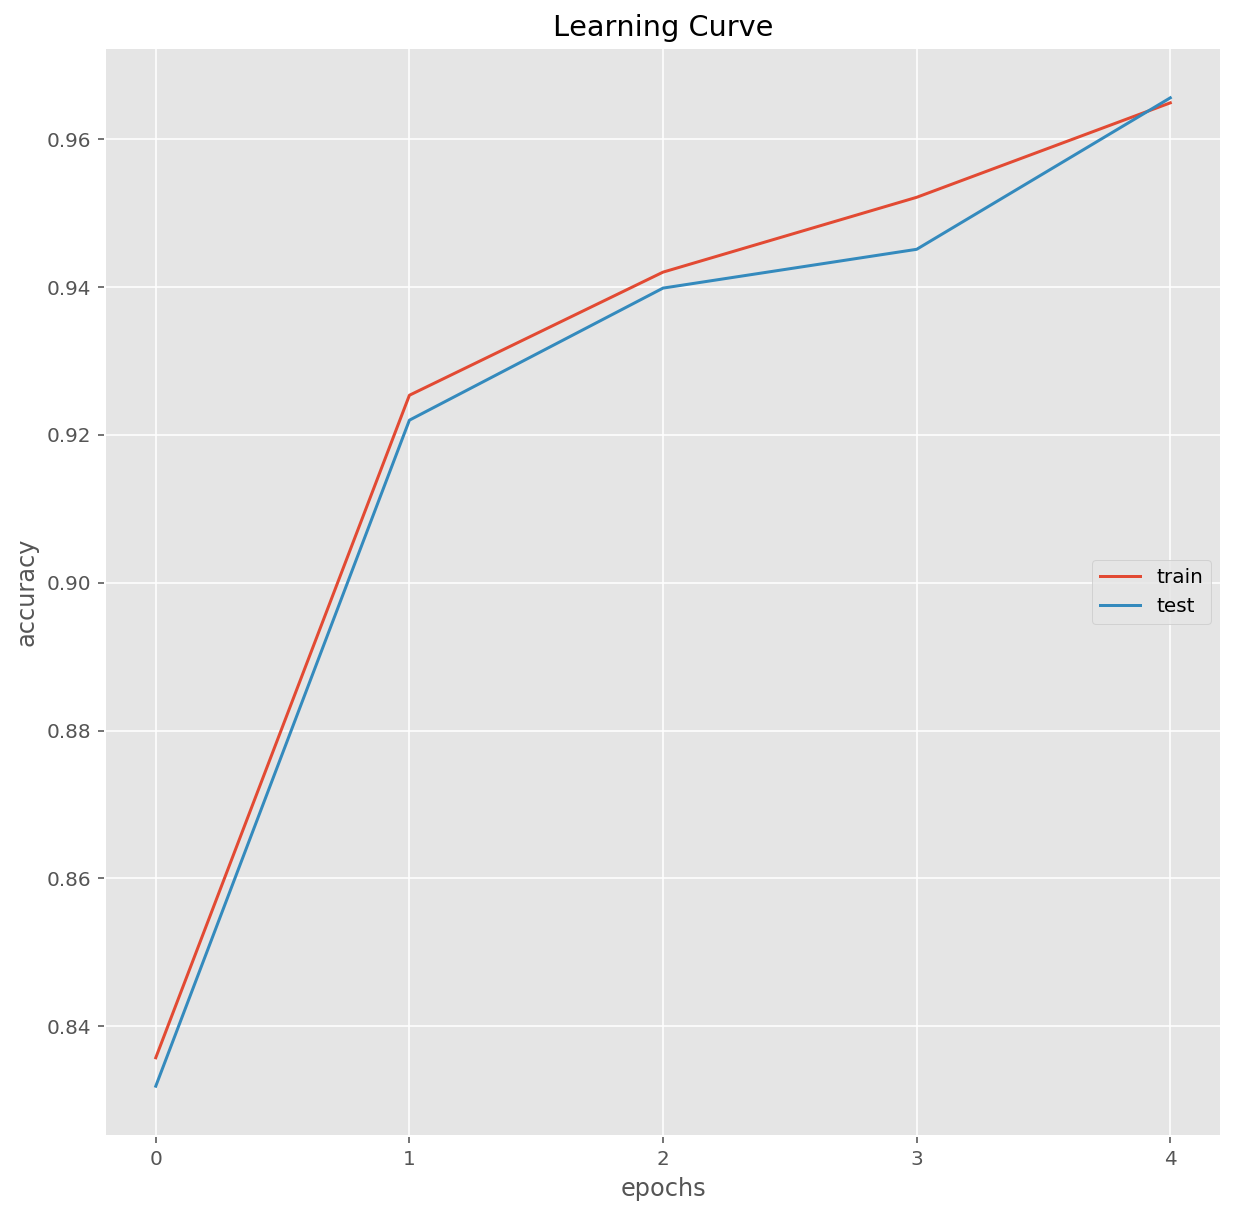

In [37]:
def make_network2(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 12])  # <== doubled
            .max_pool()
            .relu()
            .conv([5, 5, 32])  # <== doubled
            .max_pool()
            .relu()
            .flatten()
            .dense(240) # <== doubled
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network2(), make_adam(1.0e-3))
    learning_curve = train_evaluate(pipeline)
    session.save('checkpoint/network2.ckpt')
    
show_learning_curve(learning_curve)

INFO:tensorflow:Restoring parameters from checkpoint/network2.ckpt


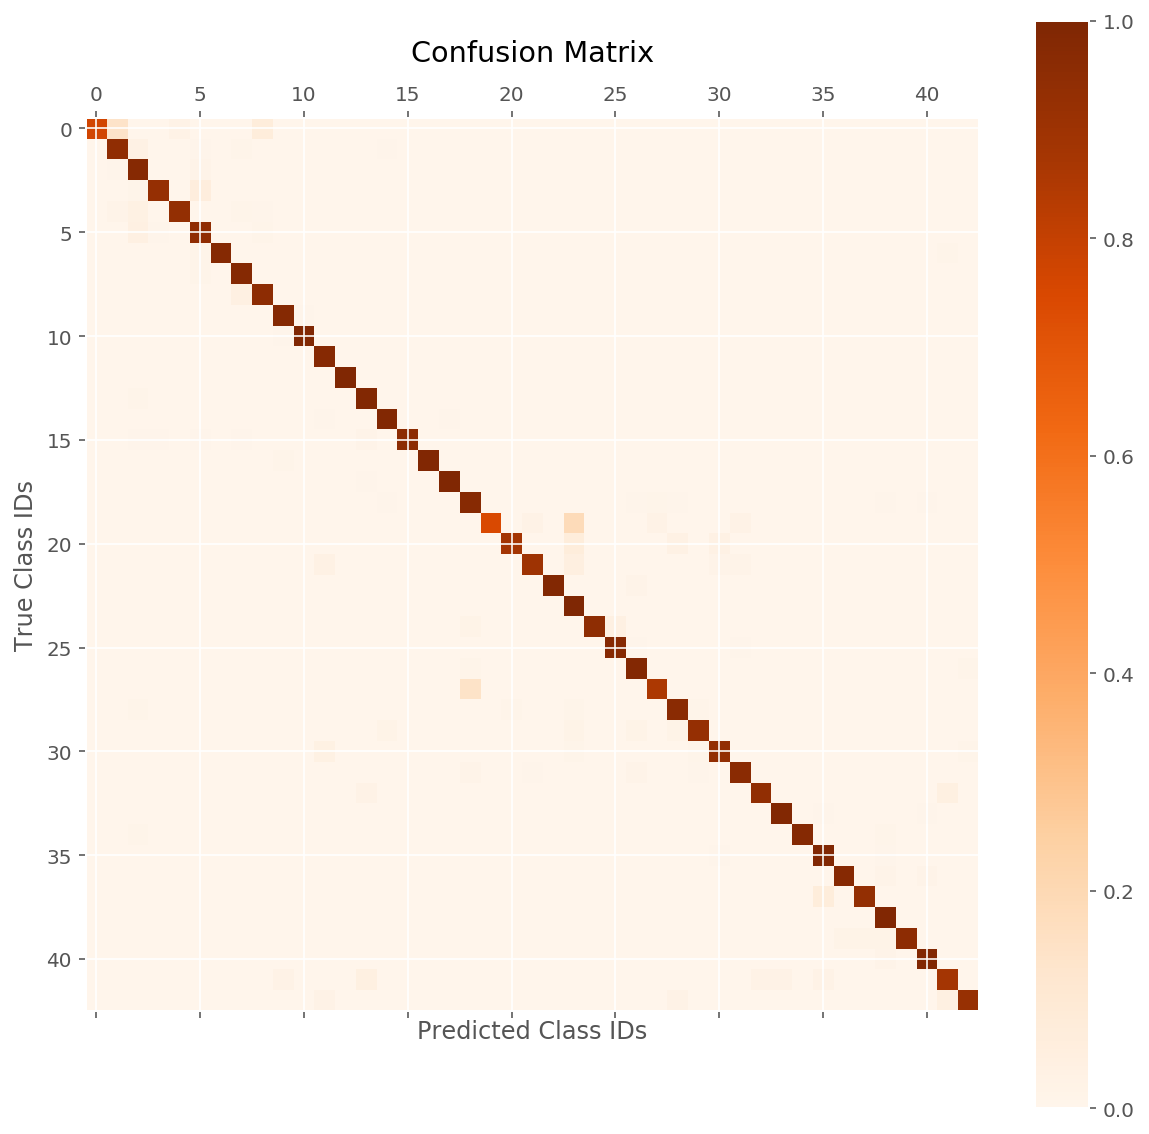

23 Slippery road                                      100.00%  406
17 No entry                                            99.56%  884
12 Priority road                                       99.53% 1672
10 No passing for vehicles over 3.5 metric tons        99.27% 1600
35 Ahead only                                          99.18%  955
38 Keep right                                          99.05% 1648
16 Vehicles over 3.5 metric tons prohibited            98.84%  334
22 Bumpy road                                          98.75%  310
14 Stop                                                98.74%  621
13 Yield                                               98.64% 1719
40 Roundabout mandatory                                98.63%  287
33 Turn right ahead                                    98.58%  548
26 Traffic signals                                     98.36%  478
 9 No passing                                          98.00% 1170
 7 Speed limit (100km/h)                               97.96% 

In [38]:

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network2())
    session.load('checkpoint/network2.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

**Observation**:

The performance improved. The training accuracy is slightly higher than the validation accuracy.  It might be a sign of overfitting but I'll need to see by increasing the complexity of the network.

On a separate note, I could have tried changing layer by layer but changing all three did work so I'm ok with this.

The confusion matrix's mean accuracy is the sum of the mean accuracy for each class divided by the number of class.  It is lower than overall accuracy indicating the larger classes are performing better (or the smaller classes are performing worse).

## Network 3

Futher doubling all filters in the convolutional layers and neurons in the dense layers.

In [25]:
def make_network3(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24]) # <== doubled
            .max_pool()
            .relu()
            .conv([5, 5, 64]) # <== doubled
            .max_pool()
            .relu()
            .flatten()
            .dense(480)  # <== doubled
            .relu()
            .dense(N_CLASSES))

In [ ]:


with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline)
    session.save('checkpoint/network3.ckpt')
    
show_learning_curve(learning_curve)

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network3.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

**Observation**:

The performance is better.  It may be showing a slight overfitting.  But I don't think we need to apply any regularization at this stage.  I should rather try more epochs to see how far it can improve.

For almost all classes, the network is producing better than 90% accuracy, proving that increasing the network complexity is making it more robust.

## Network 3 with More Epochs

Epoch:   0 Train Score: 0.907 Evaluation Score: 0.897
Epoch:   1 Train Score: 0.938 Evaluation Score: 0.938
Epoch:   2 Train Score: 0.954 Evaluation Score: 0.950
Epoch:   3 Train Score: 0.948 Evaluation Score: 0.944
Epoch:   4 Train Score: 0.966 Evaluation Score: 0.965
Epoch:   5 Train Score: 0.970 Evaluation Score: 0.965
Epoch:   6 Train Score: 0.947 Evaluation Score: 0.946
Epoch:   7 Train Score: 0.974 Evaluation Score: 0.967
Epoch:   8 Train Score: 0.974 Evaluation Score: 0.970
Epoch:   9 Train Score: 0.979 Evaluation Score: 0.976
Epoch:  10 Train Score: 0.976 Evaluation Score: 0.976
Epoch:  11 Train Score: 0.979 Evaluation Score: 0.976
Epoch:  12 Train Score: 0.978 Evaluation Score: 0.972
Epoch:  13 Train Score: 0.975 Evaluation Score: 0.972
Epoch:  14 Train Score: 0.971 Evaluation Score: 0.971
Epoch:  15 Train Score: 0.977 Evaluation Score: 0.970
Epoch:  16 Train Score: 0.975 Evaluation Score: 0.970
Epoch:  17 Train Score: 0.987 Evaluation Score: 0.984
Epoch:  18 Train Score: 0.98

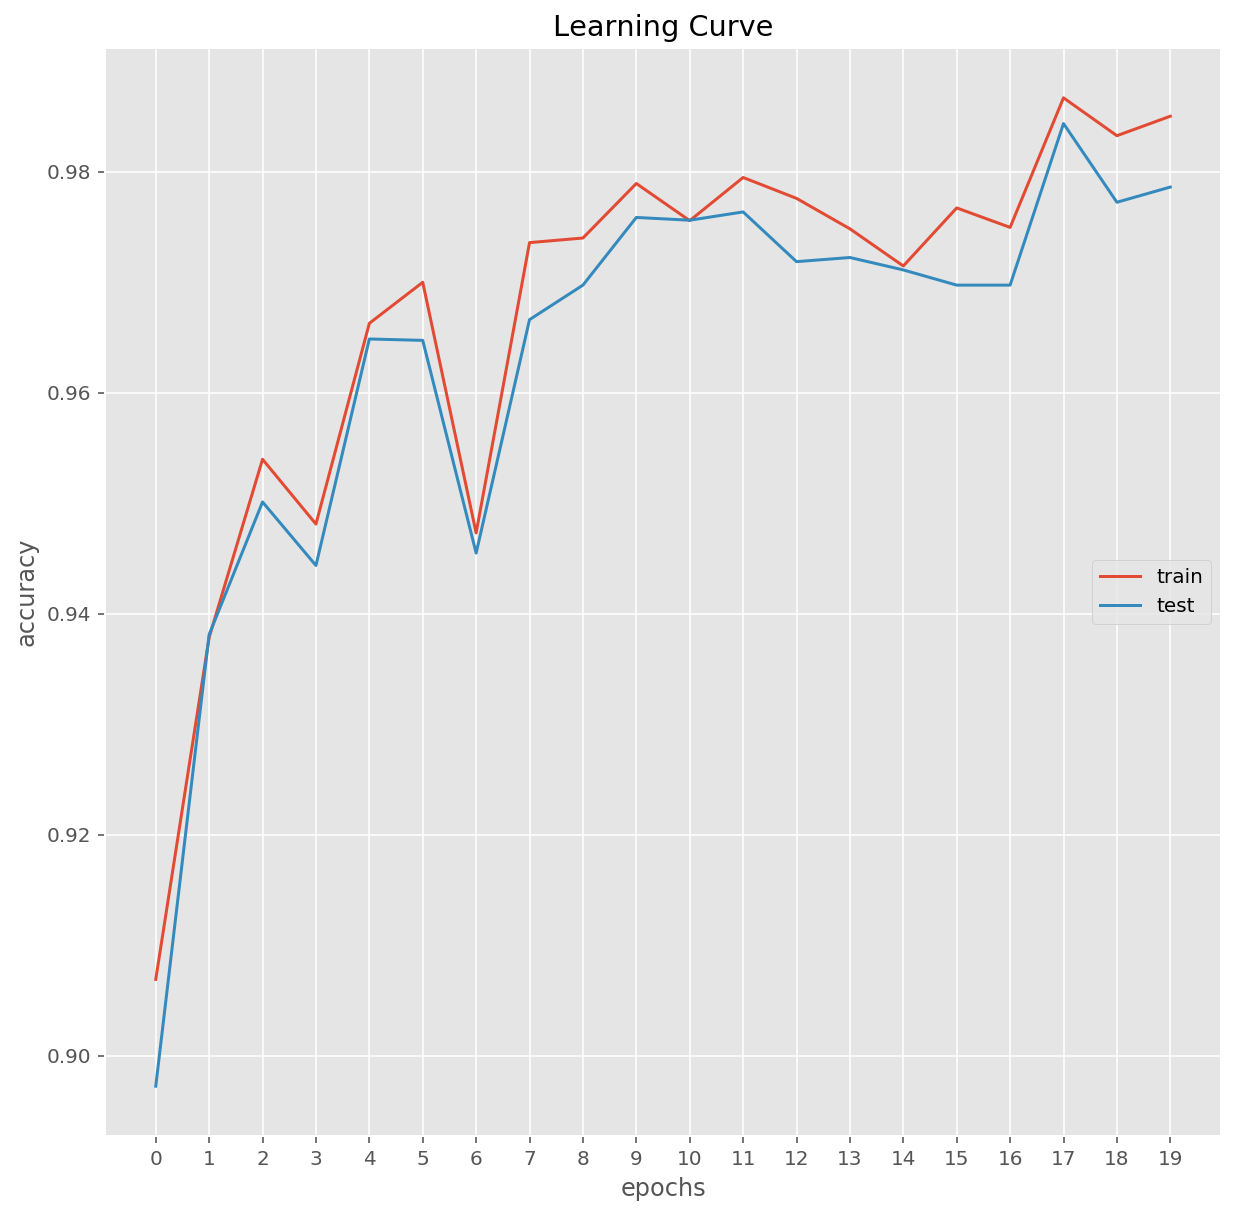

In [41]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(1.0e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network3_epochs-20.ckpt')
    
show_learning_curve(learning_curve)

INFO:tensorflow:Restoring parameters from checkpoint/network3_epochs-20.ckpt


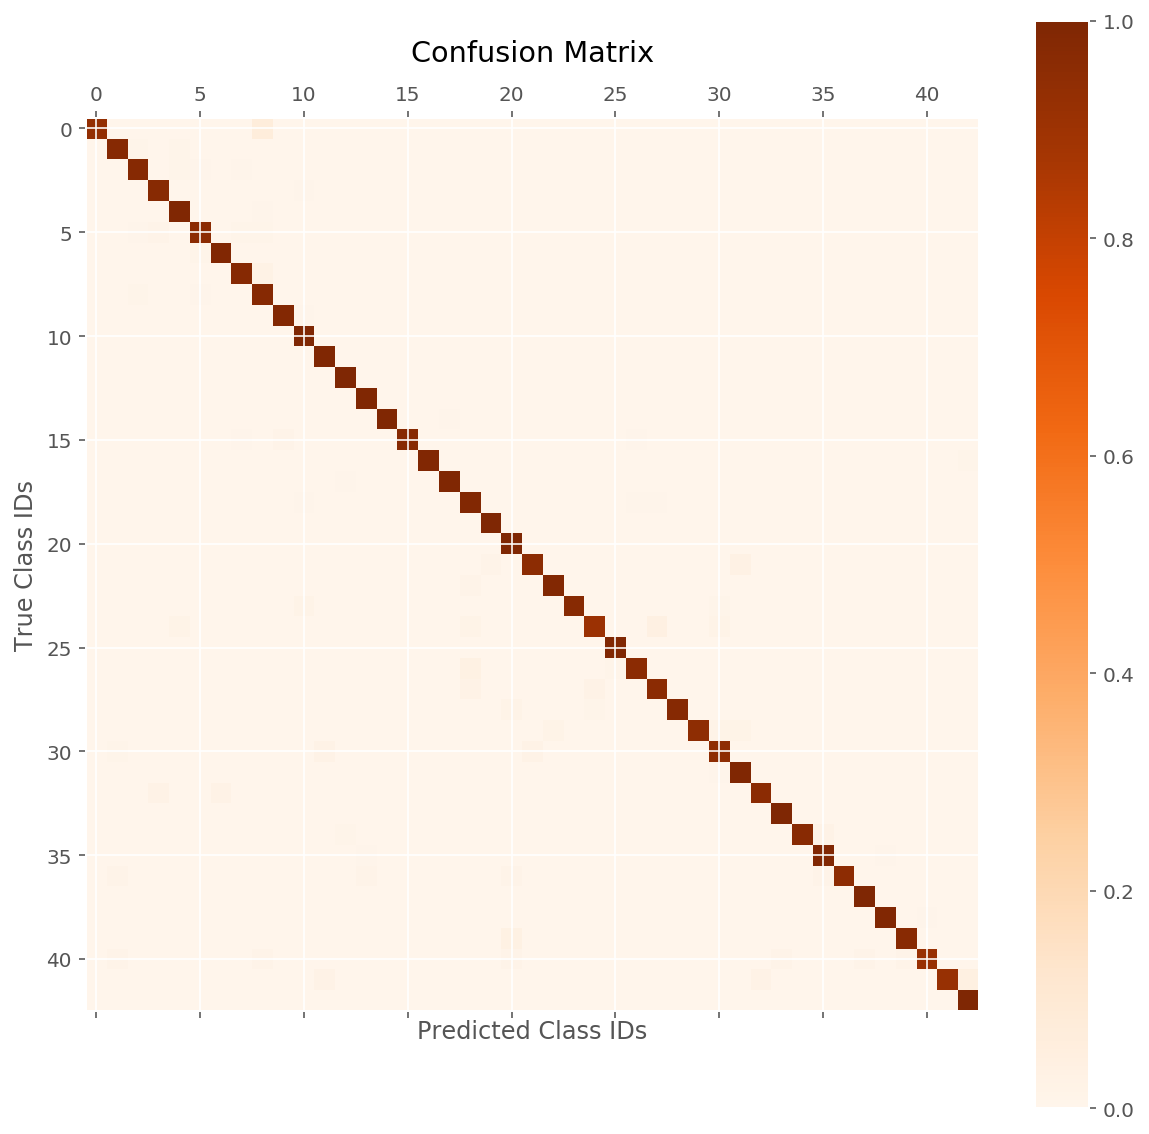

10 No passing for vehicles over 3.5 metric tons       100.00% 1600
19 Dangerous curve to the left                        100.00%  167
20 Dangerous curve to the right                       100.00%  287
33 Turn right ahead                                   100.00%  548
37 Go straight or left                                100.00%  167
42 End of no passing by vehicles over 3.5 metric tons 100.00%  191
12 Priority road                                       99.77% 1672
17 No entry                                            99.56%  884
14 Stop                                                99.37%  621
31 Wild animals crossing                               99.37%  621
25 Road work                                           99.35% 1194
13 Yield                                               99.32% 1719
 4 Speed limit (70km/h)                                99.26% 1576
11 Right-of-way at the next intersection               99.26% 1051
35 Ahead only                                          99.18% 

In [42]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network3_epochs-20.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

**Observation**:

The performance did improve but not in the last several epochs.  

100% accuracy is achieved for more classes.  Also, the bottom performer is improving as well.

In [ ]:
#Network 3 with even lower learning rate

In [35]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(0.2e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network3_epochs-20_much_lower_learning_rate.ckpt')
    

Epoch:   0 Train Score: 0.697 Evaluation Score: 0.690
Epoch:   1 Train Score: 0.846 Evaluation Score: 0.840
Epoch:   2 Train Score: 0.892 Evaluation Score: 0.895
Epoch:   3 Train Score: 0.924 Evaluation Score: 0.918
Epoch:   4 Train Score: 0.946 Evaluation Score: 0.941
Epoch:   5 Train Score: 0.956 Evaluation Score: 0.951
Epoch:   6 Train Score: 0.964 Evaluation Score: 0.959
Epoch:   7 Train Score: 0.977 Evaluation Score: 0.975
Epoch:   8 Train Score: 0.967 Evaluation Score: 0.963
Epoch:   9 Train Score: 0.979 Evaluation Score: 0.975
Epoch:  10 Train Score: 0.983 Evaluation Score: 0.980
Epoch:  11 Train Score: 0.983 Evaluation Score: 0.978
Epoch:  12 Train Score: 0.981 Evaluation Score: 0.977
Epoch:  13 Train Score: 0.986 Evaluation Score: 0.985
Epoch:  14 Train Score: 0.983 Evaluation Score: 0.981
Epoch:  15 Train Score: 0.989 Evaluation Score: 0.984
Epoch:  16 Train Score: 0.990 Evaluation Score: 0.985
Epoch:  17 Train Score: 0.991 Evaluation Score: 0.986
Epoch:  18 Train Score: 0.99

## Network 3 with drop out

In [ ]:
def make_network3_dropout(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24]) # <== doubled
            .max_pool()
            .relu()
            .conv([5, 5, 64]) # <== doubled
            .max_pool()
            .relu()
            .dropout(keep_prob=0.8) 
            .flatten()
            .dense(480)  # <== doubled
            .relu()
            .dense(N_CLASSES))
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3_dropout(), make_adam(0.2e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network3_epochs-20_with_dropout.ckpt')
    
show_learning_curve(learning_curve)

Epoch:   0 Train Score: 0.710 Evaluation Score: 0.705
Epoch:   1 Train Score: 0.848 Evaluation Score: 0.845
Epoch:   2 Train Score: 0.905 Evaluation Score: 0.902
Epoch:   3 Train Score: 0.934 Evaluation Score: 0.927


### Network 3 with More Epochs and Lower Learning Rate

Let's try a lower learning rate with epochs=20.

Epoch:   0 Train Score: 0.855 Evaluation Score: 0.847
Epoch:   1 Train Score: 0.917 Evaluation Score: 0.913
Epoch:   2 Train Score: 0.955 Evaluation Score: 0.950
Epoch:   3 Train Score: 0.956 Evaluation Score: 0.956
Epoch:   4 Train Score: 0.970 Evaluation Score: 0.962
Epoch:   5 Train Score: 0.963 Evaluation Score: 0.964
Epoch:   6 Train Score: 0.978 Evaluation Score: 0.977
Epoch:   7 Train Score: 0.977 Evaluation Score: 0.971
Epoch:   8 Train Score: 0.983 Evaluation Score: 0.979
Epoch:   9 Train Score: 0.984 Evaluation Score: 0.978
Epoch:  10 Train Score: 0.982 Evaluation Score: 0.978
Epoch:  11 Train Score: 0.982 Evaluation Score: 0.976
Epoch:  12 Train Score: 0.983 Evaluation Score: 0.979
Epoch:  13 Train Score: 0.988 Evaluation Score: 0.988
Epoch:  14 Train Score: 0.984 Evaluation Score: 0.983
Epoch:  15 Train Score: 0.987 Evaluation Score: 0.983
Epoch:  16 Train Score: 0.990 Evaluation Score: 0.987
Epoch:  17 Train Score: 0.989 Evaluation Score: 0.987
Epoch:  18 Train Score: 0.99

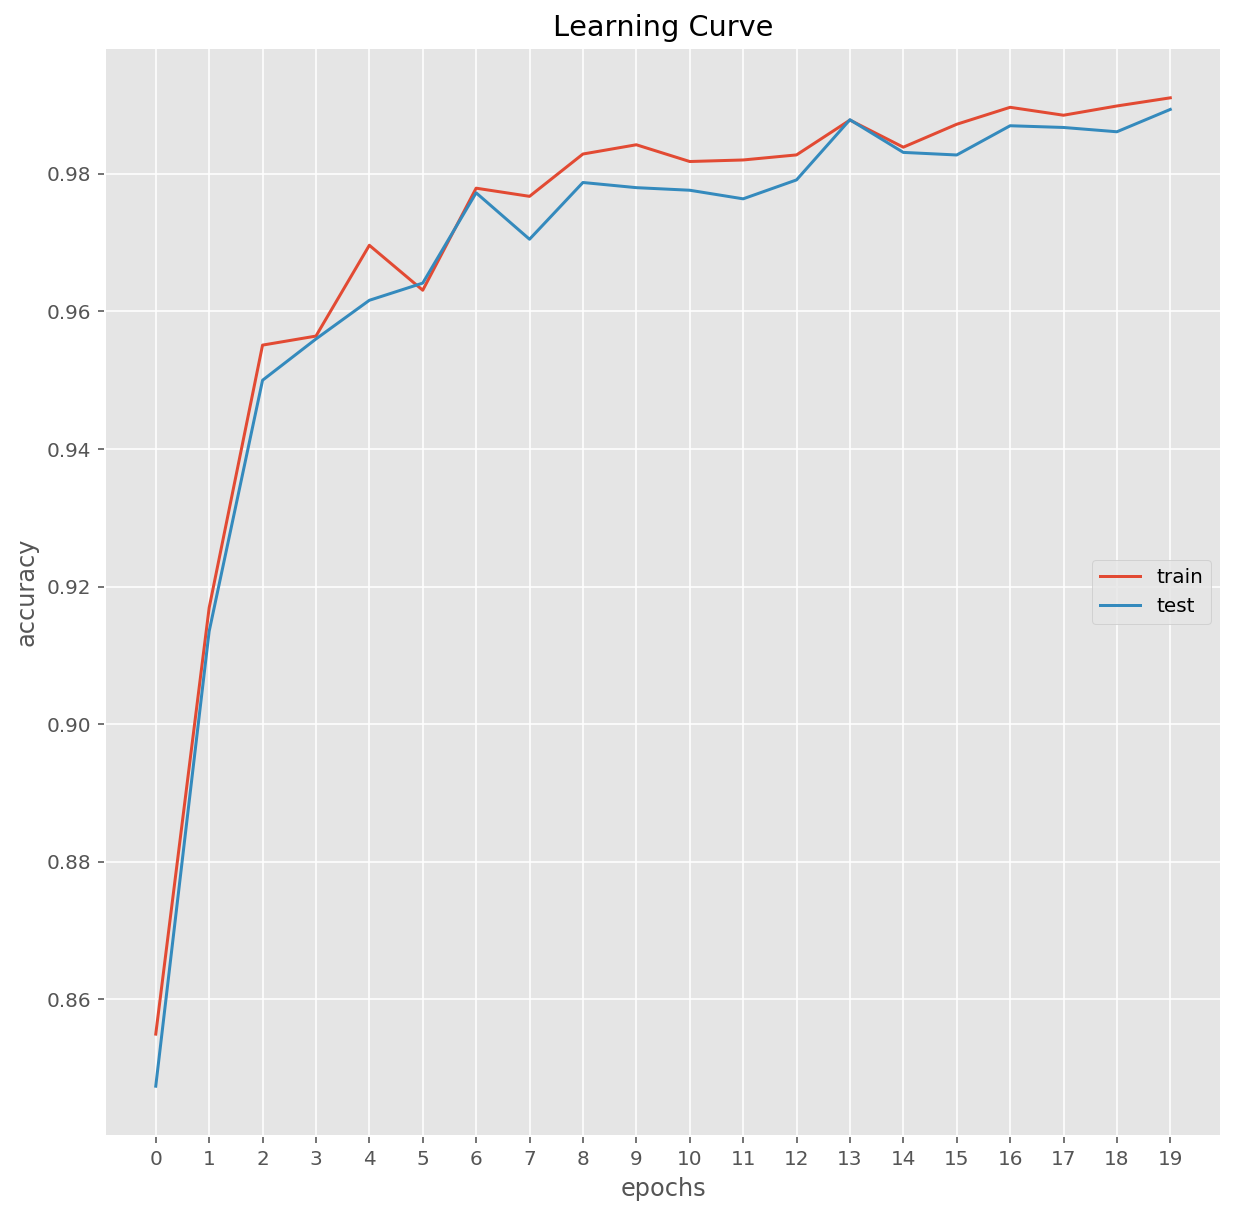

In [43]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(0.5e-3)) # <== lower learning rate
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network3_epochs-20_lr-0.5e-3.ckpt')
    
show_learning_curve(learning_curve)

INFO:tensorflow:Restoring parameters from checkpoint/network3_epochs-20_lr-0.5e-3.ckpt


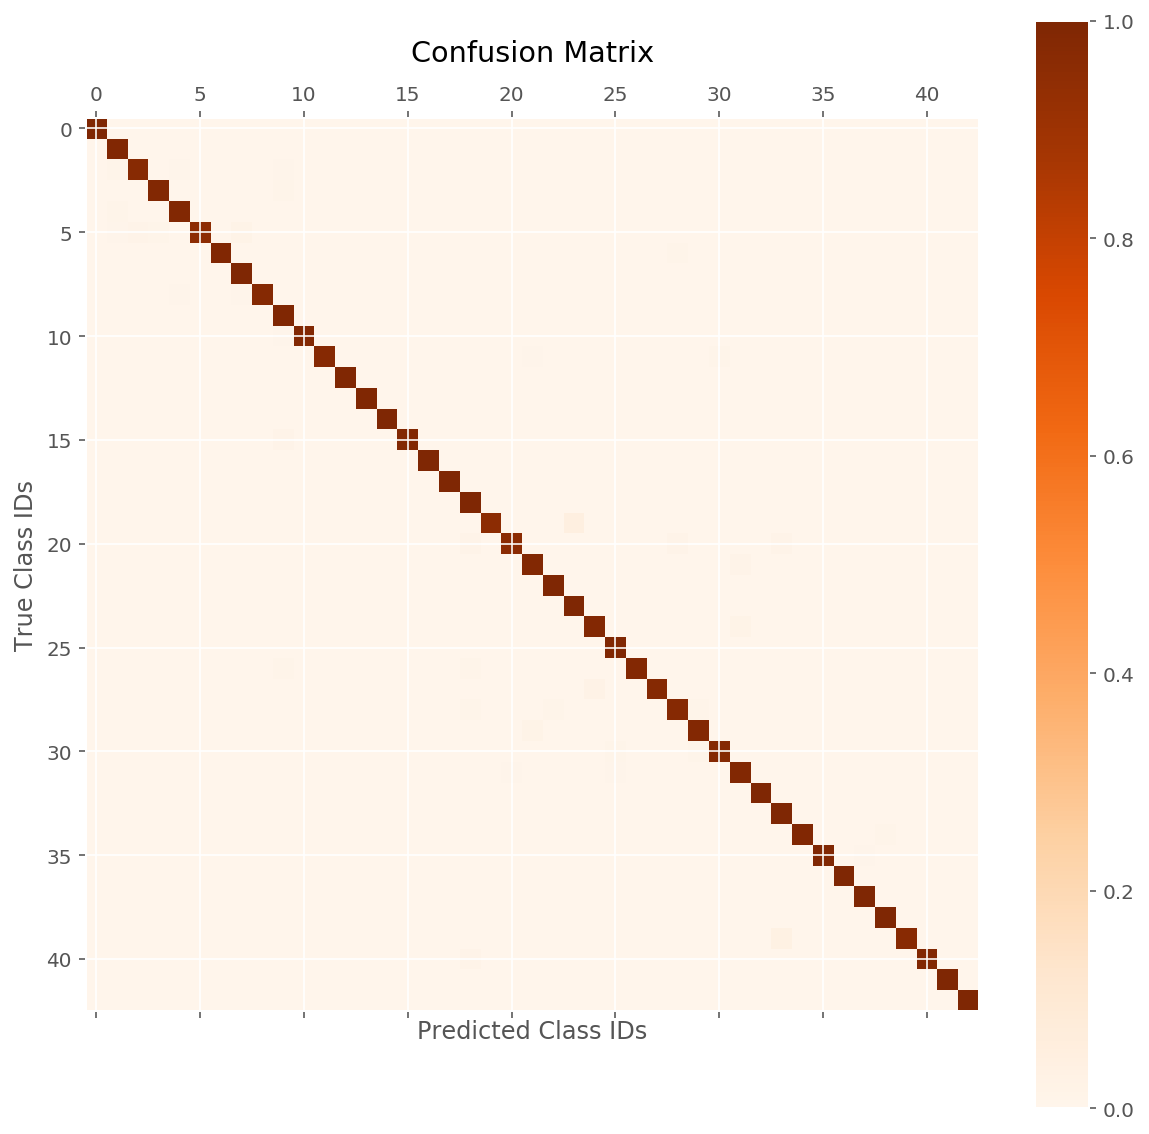

 0 Speed limit (20km/h)                               100.00%  167
 7 Speed limit (100km/h)                              100.00% 1146
14 Stop                                               100.00%  621
16 Vehicles over 3.5 metric tons prohibited           100.00%  334
17 No entry                                           100.00%  884
18 General caution                                    100.00%  955
22 Bumpy road                                         100.00%  310
23 Slippery road                                      100.00%  406
32 End of all speed and passing limits                100.00%  191
33 Turn right ahead                                   100.00%  548
36 Go straight or right                               100.00%  310
37 Go straight or left                                100.00%  167
38 Keep right                                         100.00% 1648
41 End of no passing                                  100.00%  191
42 End of no passing by vehicles over 3.5 metric tons 100.00% 

In [44]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network3_epochs-20_lr-0.5e-3.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

**Observation**:

The performance is almost the same  or slightly better.  The learning curve looks much smoother.  The average accuracy per class is slightly better, too.  Overall, I believe the smaller learning rate was a worthy change.

## Network3 average pool

In [26]:
def make_network3_avg(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24]) # <== doubled
            .avg_pool()
            .relu()
            .conv([5, 5, 64]) # <== doubled
            .avg_pool()
            .relu()
            .flatten()
            .dense(480)  # <== doubled
            .relu()
            .dense(N_CLASSES))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Epoch:   0 Train Score: 0.768 Evaluation Score: 0.772
Epoch:   1 Train Score: 0.879 Evaluation Score: 0.872
Epoch:   2 Train Score: 0.909 Evaluation Score: 0.908
Epoch:   3 Train Score: 0.925 Evaluation Score: 0.918
Epoch:   4 Train Score: 0.949 Evaluation Score: 0.948
Epoch:   5 Train Score: 0.956 Evaluation Score: 0.948
Epoch:   6 Train Score: 0.956 Evaluation Score: 0.952
Epoch:   7 Train Score: 0.974 Evaluation Score: 0.969
Epoch:   8 Train Score: 0.970 Evaluation Score: 0.967
Epoch:   9 Train Score: 0.969 Evaluation Score: 0.962
Epoch:  10 Train Score: 0.977 Evaluation Score: 0.970
Epoch:  11 Train Score: 0.974 Evaluation Score: 0.972
Epoch:  12 Train Score: 0.984 Evaluation Score: 0.978
Epoch:  13 Train Score: 0.978 Evaluation Score: 0.972
Epoch:  14 Train Score: 0.979 Evaluation Score: 0.977
E

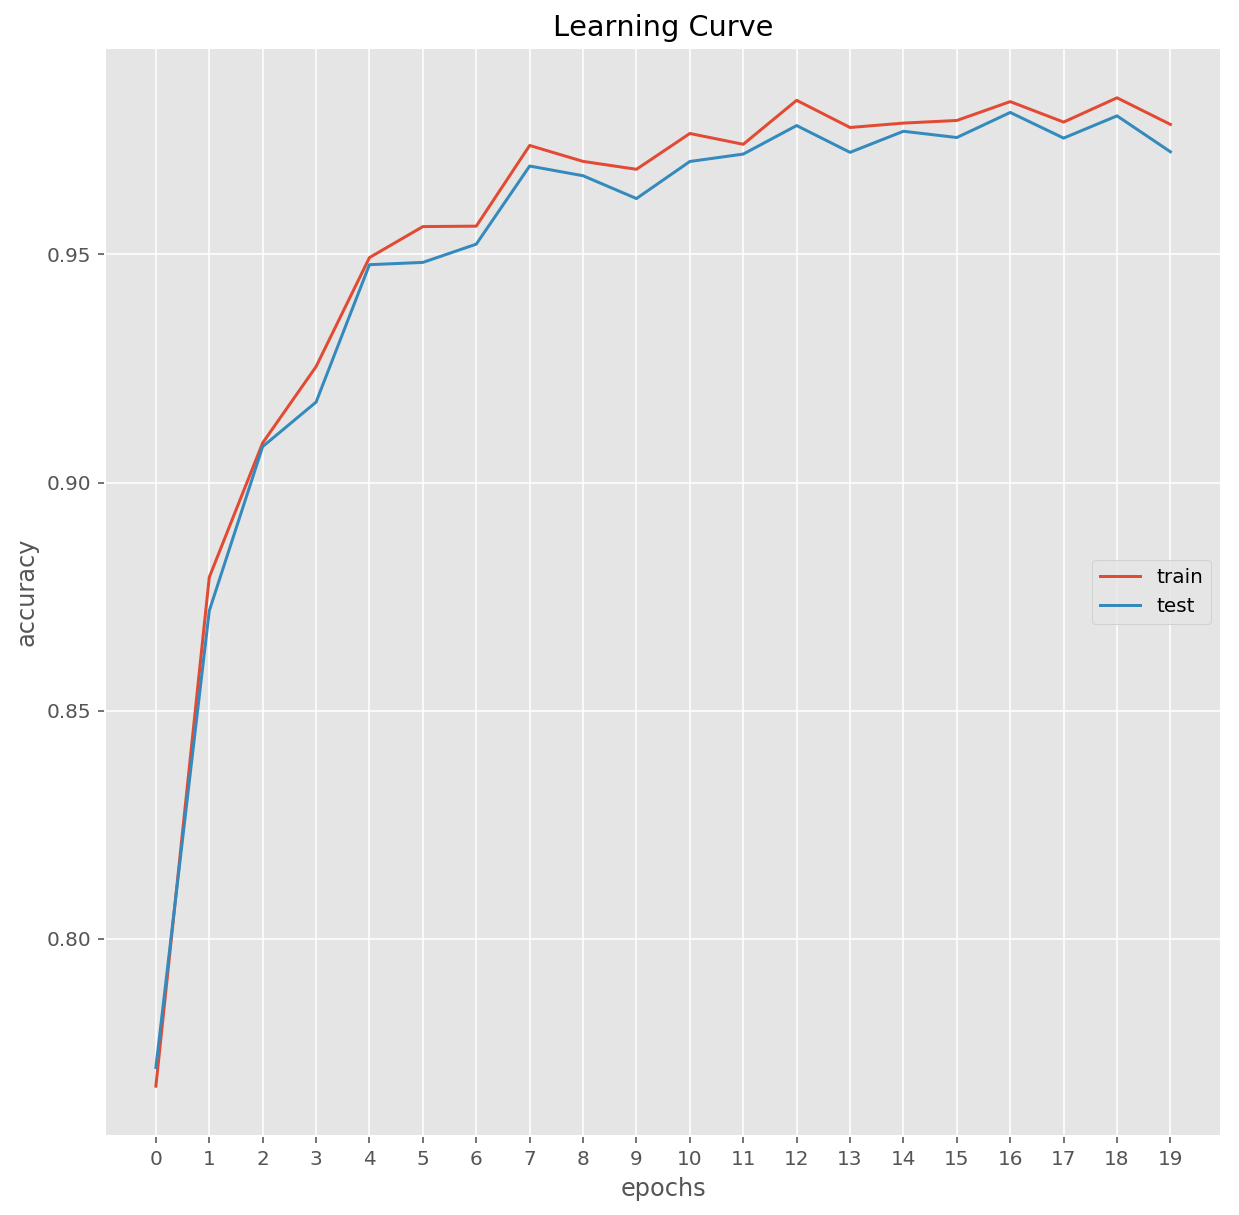

In [27]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3_avg(), make_adam(0.5e-3)) # <== lower learning rate
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network3_epochs-20_lr-0.5e-3_avg.ckpt')
    
show_learning_curve(learning_curve)

### Netowrk 3 Even Smaller Learning Rate

Epoch:   0 Train Score: 0.555 Evaluation Score: 0.548
Epoch:   1 Train Score: 0.715 Evaluation Score: 0.715
Epoch:   2 Train Score: 0.805 Evaluation Score: 0.795
Epoch:   3 Train Score: 0.848 Evaluation Score: 0.846
Epoch:   4 Train Score: 0.873 Evaluation Score: 0.868
Epoch:   5 Train Score: 0.902 Evaluation Score: 0.899
Epoch:   6 Train Score: 0.914 Evaluation Score: 0.905
Epoch:   7 Train Score: 0.928 Evaluation Score: 0.927
Epoch:   8 Train Score: 0.941 Evaluation Score: 0.935
Epoch:   9 Train Score: 0.947 Evaluation Score: 0.937
Epoch:  10 Train Score: 0.957 Evaluation Score: 0.949
Epoch:  11 Train Score: 0.964 Evaluation Score: 0.960
Epoch:  12 Train Score: 0.966 Evaluation Score: 0.958
Epoch:  13 Train Score: 0.965 Evaluation Score: 0.958
Epoch:  14 Train Score: 0.971 Evaluation Score: 0.966
Epoch:  15 Train Score: 0.974 Evaluation Score: 0.967
Epoch:  16 Train Score: 0.973 Evaluation Score: 0.965
Epoch:  17 Train Score: 0.977 Evaluation Score: 0.971
Epoch:  18 Train Score: 0.97

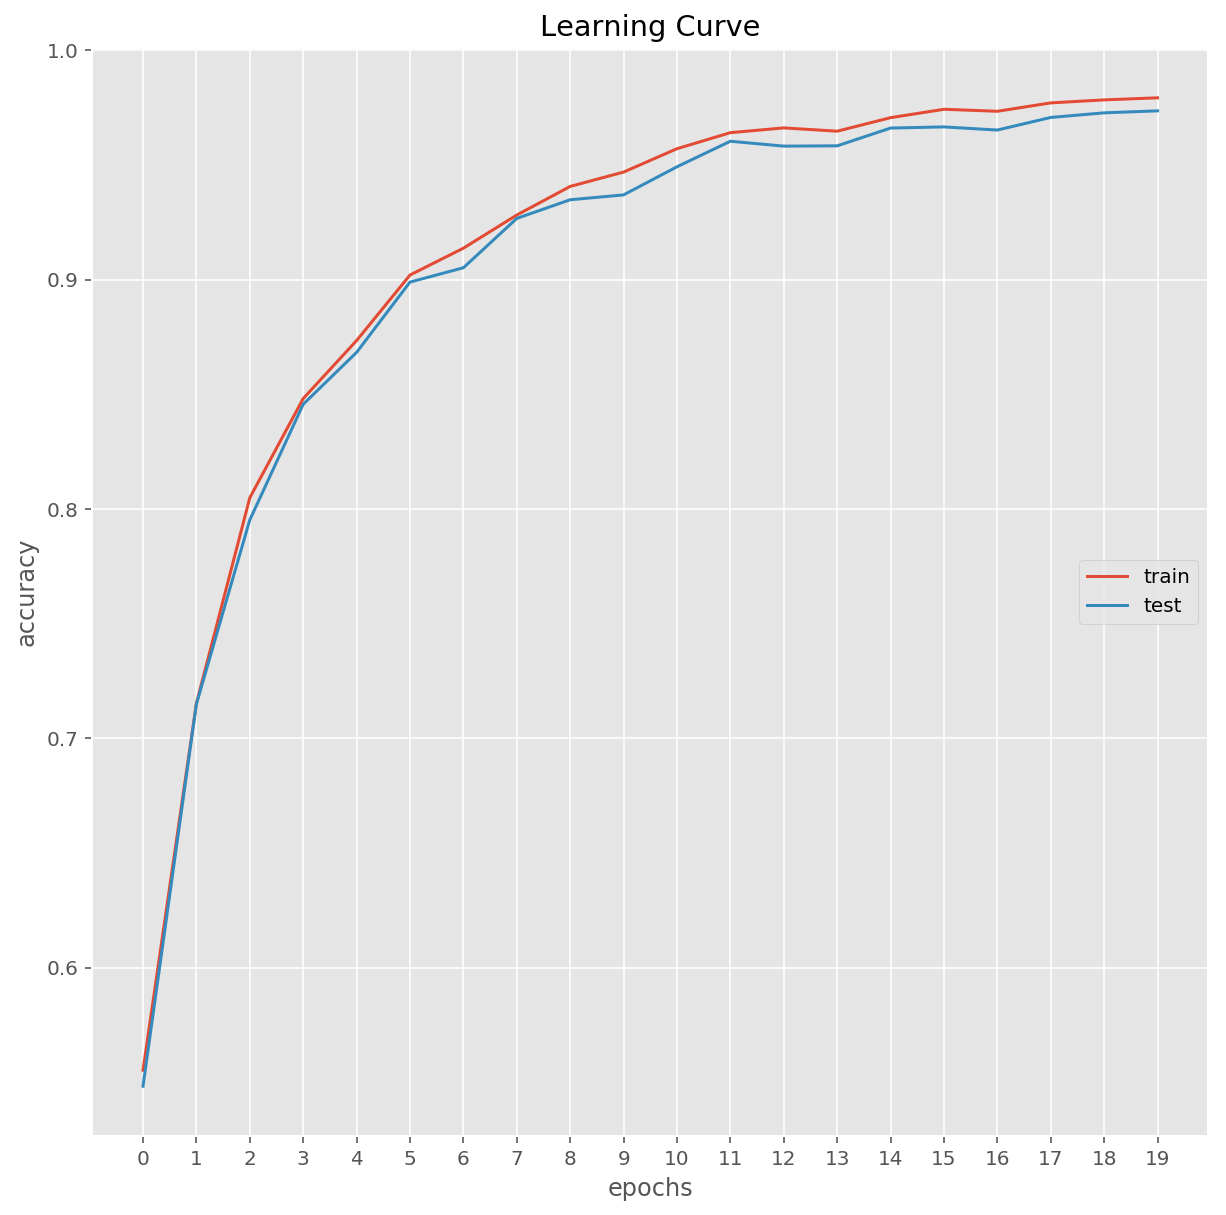

In [45]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(1.0e-4)) # <== lower learning rate
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network3_epochs-20_lr-1.0e-4.ckpt')
    
show_learning_curve(learning_curve)

INFO:tensorflow:Restoring parameters from checkpoint/network3_epochs-20_lr-1.0e-4.ckpt


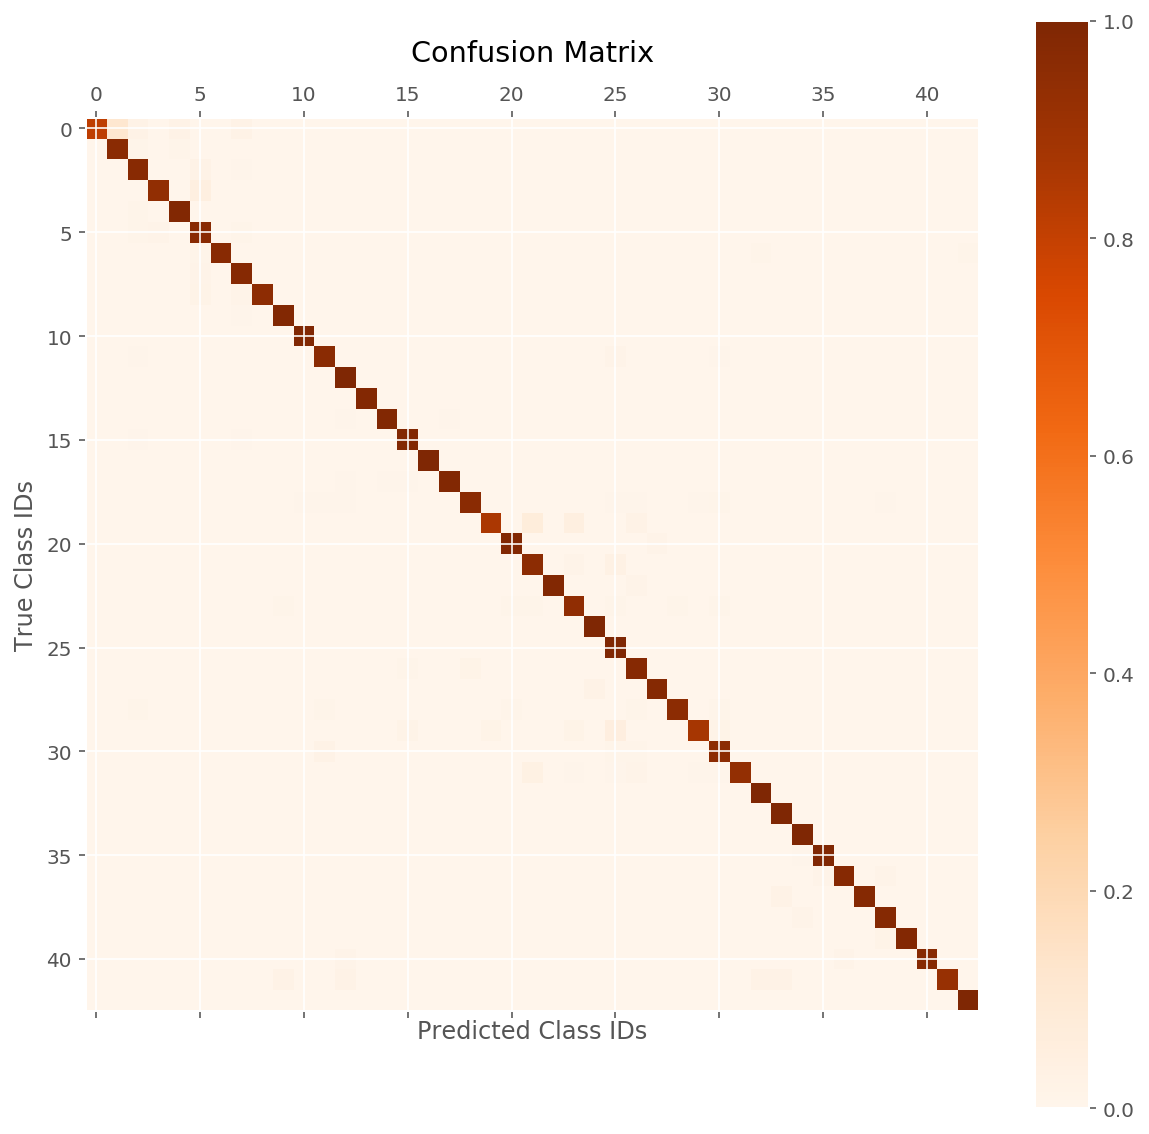

16 Vehicles over 3.5 metric tons prohibited           100.00%  334
24 Road narrows on the right                          100.00%  215
32 End of all speed and passing limits                100.00%  191
33 Turn right ahead                                   100.00%  548
34 Turn left ahead                                    100.00%  334
42 End of no passing by vehicles over 3.5 metric tons 100.00%  191
12 Priority road                                       99.77% 1672
25 Road work                                           99.67% 1194
35 Ahead only                                          99.59%  955
10 No passing for vehicles over 3.5 metric tons        99.27% 1600
22 Bumpy road                                          98.75%  310
14 Stop                                                98.74%  621
17 No entry                                            98.67%  884
 9 No passing                                          98.67% 1170
20 Dangerous curve to the right                        98.63% 

In [46]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network3_epochs-20_lr-1.0e-4.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

**Observation**:

- The performance is worse and it seems to show some overfitting in the end.  
- The learning curve is much more smoother.
- The mean accuracy per class is worse and its standard devaition is bigger.

Let's stick with the previous learning rate for the time being.

## Network 4

Let's try leaky ReLU (to avoid dead ReLU issue if any)

In [30]:
def make_network4(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu(leak_ratio=0.01) # <== leaky ReLU
            .conv([5, 5, 64])
            .max_pool()
            .relu(leak_ratio=0.01) # <== leaky ReLU
            .flatten()
            .dense(480)
            .relu(leak_ratio=0.01) # <== leaky ReLU
            .dense(N_CLASSES))


Epoch:   0 Train Score: 0.833 Evaluation Score: 0.825
Epoch:   1 Train Score: 0.917 Evaluation Score: 0.907
Epoch:   2 Train Score: 0.954 Evaluation Score: 0.943
Epoch:   3 Train Score: 0.968 Evaluation Score: 0.961
Epoch:   4 Train Score: 0.969 Evaluation Score: 0.963
Epoch:   5 Train Score: 0.972 Evaluation Score: 0.971
Epoch:   6 Train Score: 0.981 Evaluation Score: 0.979
Epoch:   7 Train Score: 0.980 Evaluation Score: 0.981
Epoch:   8 Train Score: 0.982 Evaluation Score: 0.979
Epoch:   9 Train Score: 0.984 Evaluation Score: 0.981
Epoch:  10 Train Score: 0.980 Evaluation Score: 0.976
Epoch:  11 Train Score: 0.986 Evaluation Score: 0.981
Epoch:  12 Train Score: 0.979 Evaluation Score: 0.975
Epoch:  13 Train Score: 0.989 Evaluation Score: 0.988
Epoch:  14 Train Score: 0.992 Evaluation Score: 0.988
Epoch:  15 Train Score: 0.988 Evaluation Score: 0.985
Epoch:  16 Train Score: 0.989 Evaluation Score: 0.987
Epoch:  17 Train Score: 0.988 Evaluation Score: 0.984
Epoch:  18 Train Score: 0.99

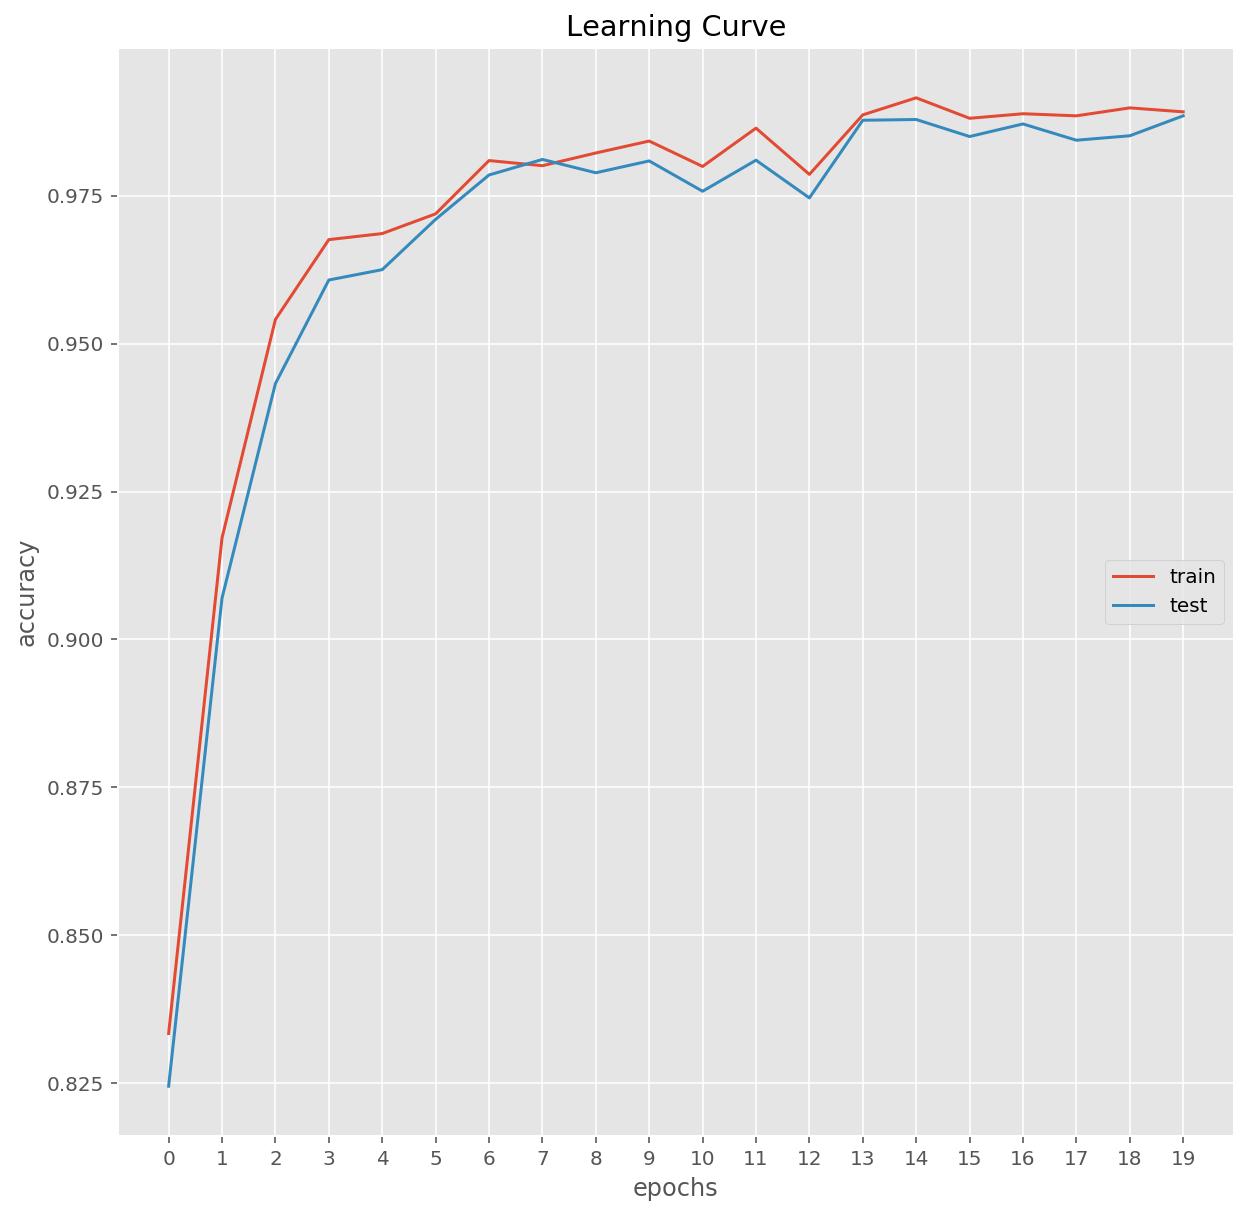

In [ ]:

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network4(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network4.ckpt')

show_learning_curve(learning_curve)

INFO:tensorflow:Restoring parameters from checkpoint/network4.ckpt


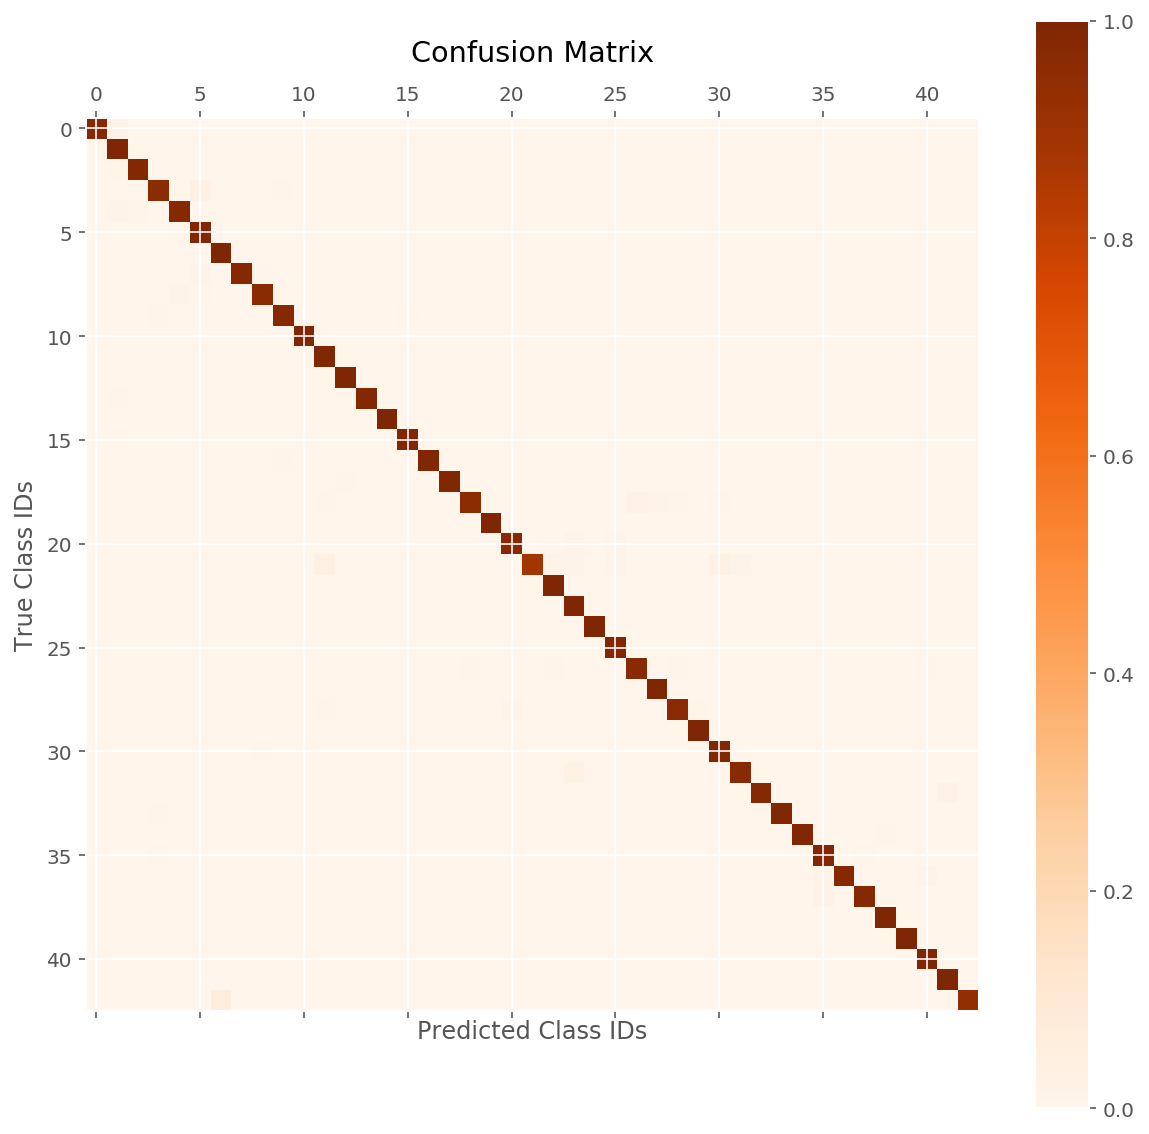

 6 End of speed limit (80km/h)                        100.00%  334
12 Priority road                                      100.00% 1672
14 Stop                                               100.00%  621
19 Dangerous curve to the left                        100.00%  167
22 Bumpy road                                         100.00%  310
23 Slippery road                                      100.00%  406
24 Road narrows on the right                          100.00%  215
27 Pedestrians                                        100.00%  191
29 Bicycles crossing                                  100.00%  215
38 Keep right                                         100.00% 1648
39 Keep left                                          100.00%  239
40 Roundabout mandatory                               100.00%  287
41 End of no passing                                  100.00%  191
 1 Speed limit (30km/h)                                99.78% 1767
17 No entry                                            99.56% 

In [31]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network4())
    session.load('checkpoint/network4.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

In [32]:
def make_network4_1(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .sigmoid() 
            .conv([5, 5, 64])
            .max_pool()
            .sigmoid() 
            .flatten()
            .dense(480)
            .sigmoid() 
            .dense(N_CLASSES))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Epoch:   0 Train Score: 0.588 Evaluation Score: 0.588
Epoch:   1 Train Score: 0.800 Evaluation Score: 0.800
Epoch:   2 Train Score: 0.867 Evaluation Score: 0.861
Epoch:   3 Train Score: 0.920 Evaluation Score: 0.917
Epoch:   4 Train Score: 0.932 Evaluation Score: 0.929
Epoch:   5 Train Score: 0.940 Evaluation Score: 0.937
Epoch:   6 Train Score: 0.940 Evaluation Score: 0.937
Epoch:   7 Train Score: 0.965 Evaluation Score: 0.962
Epoch:   8 Train Score: 0.969 Evaluation Score: 0.962
Epoch:   9 Train Score: 0.974 Evaluation Score: 0.968
Epoch:  10 Train Score: 0.971 Evaluation Score: 0.967
Epoch:  11 Train Score: 0.974 Evaluation Score: 0.971
Epoch:  12 Train Score: 0.979 Evaluation Score: 0.973
Epoch:  15 Train Score: 0.987 Evaluation Score: 0.983
Epoch:  16 Train Score: 0.986 Evaluation Score: 0.981
E

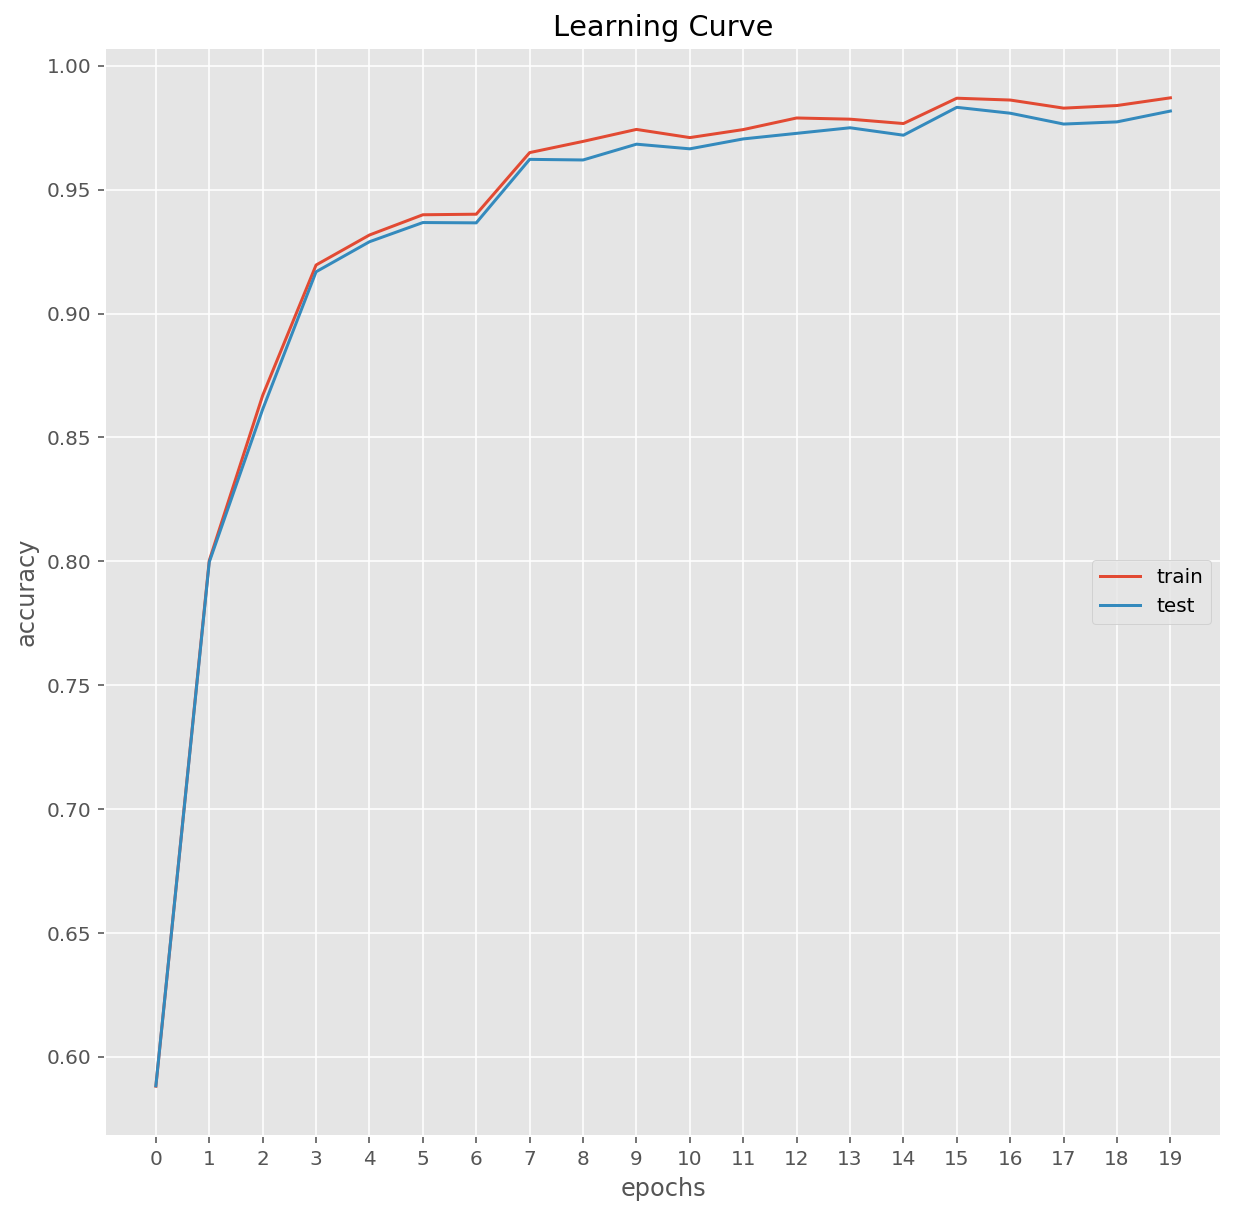

In [ ]:


with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network4_1(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network4.1.ckpt')

show_learning_curve(learning_curve)

Epoch:   0 Train Score: 0.751 Evaluation Score: 0.741
Epoch:   1 Train Score: 0.851 Evaluation Score: 0.839
Epoch:   2 Train Score: 0.902 Evaluation Score: 0.901
Epoch:   3 Train Score: 0.913 Evaluation Score: 0.903
Epoch:   4 Train Score: 0.928 Evaluation Score: 0.920
Epoch:   5 Train Score: 0.945 Evaluation Score: 0.942
Epoch:   6 Train Score: 0.947 Evaluation Score: 0.945
Epoch:   7 Train Score: 0.955 Evaluation Score: 0.953
Epoch:   8 Train Score: 0.955 Evaluation Score: 0.948
Epoch:   9 Train Score: 0.955 Evaluation Score: 0.950
Epoch:  10 Train Score: 0.958 Evaluation Score: 0.954
Epoch:  11 Train Score: 0.963 Evaluation Score: 0.958
Epoch:  12 Train Score: 0.968 Evaluation Score: 0.964
Epoch:  13 Train Score: 0.968 Evaluation Score: 0.963
Epoch:  14 Train Score: 0.966 Evaluation Score: 0.957
Epoch:  15 Train Score: 0.969 Evaluation Score: 0.967
Epoch:  16 Train Score: 0.966 Evaluation Score: 0.963
Epoch:  17 Train Score: 0.972 Evaluation Score: 0.968
Epoch:  18 Train Score: 0.97

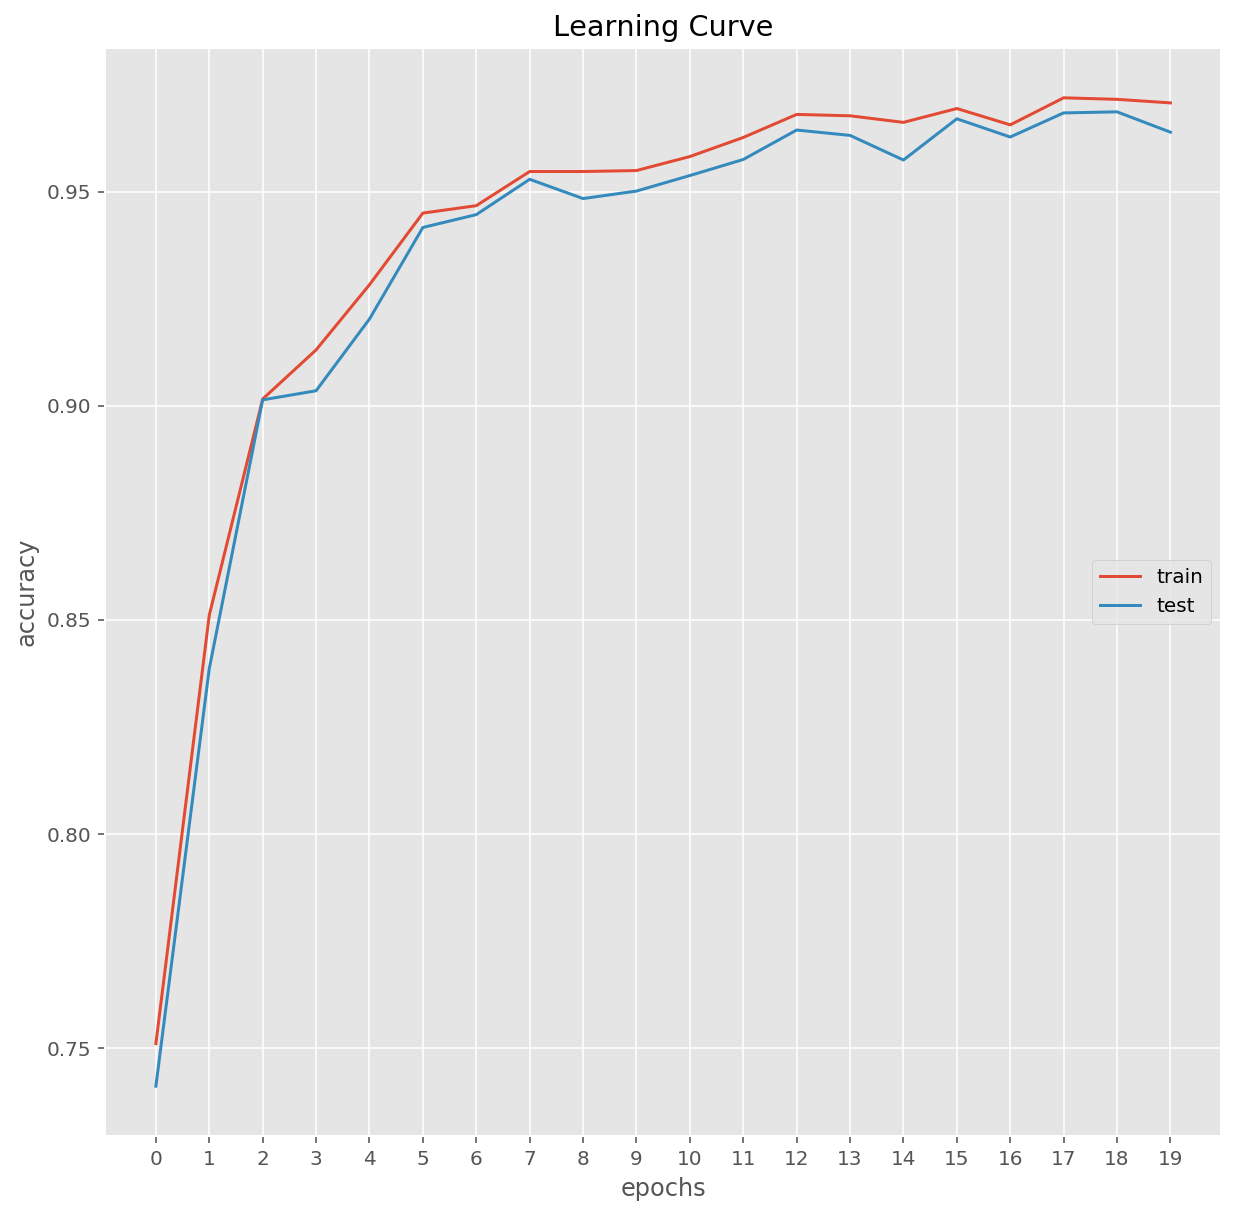

In [28]:
def make_network4_2(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .tanh() 
            .conv([5, 5, 64])
            .max_pool()
            .tanh() 
            .flatten()
            .dense(480)
            .tanh() 
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network4_2(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network4.2.ckpt')

show_learning_curve(learning_curve)

Epoch:   0 Train Score: 0.714 Evaluation Score: 0.703
Epoch:   1 Train Score: 0.837 Evaluation Score: 0.829
Epoch:   2 Train Score: 0.885 Evaluation Score: 0.880
Epoch:   3 Train Score: 0.905 Evaluation Score: 0.901
Epoch:   4 Train Score: 0.922 Evaluation Score: 0.907
Epoch:   5 Train Score: 0.927 Evaluation Score: 0.925
Epoch:   6 Train Score: 0.937 Evaluation Score: 0.929
Epoch:   7 Train Score: 0.940 Evaluation Score: 0.935
Epoch:   8 Train Score: 0.936 Evaluation Score: 0.937
Epoch:   9 Train Score: 0.955 Evaluation Score: 0.951
Epoch:  10 Train Score: 0.953 Evaluation Score: 0.950
Epoch:  11 Train Score: 0.956 Evaluation Score: 0.952
Epoch:  12 Train Score: 0.959 Evaluation Score: 0.958
Epoch:  13 Train Score: 0.961 Evaluation Score: 0.955
Epoch:  14 Train Score: 0.964 Evaluation Score: 0.958
Epoch:  15 Train Score: 0.956 Evaluation Score: 0.954
Epoch:  16 Train Score: 0.966 Evaluation Score: 0.961
Epoch:  17 Train Score: 0.966 Evaluation Score: 0.958
Epoch:  18 Train Score: 0.96

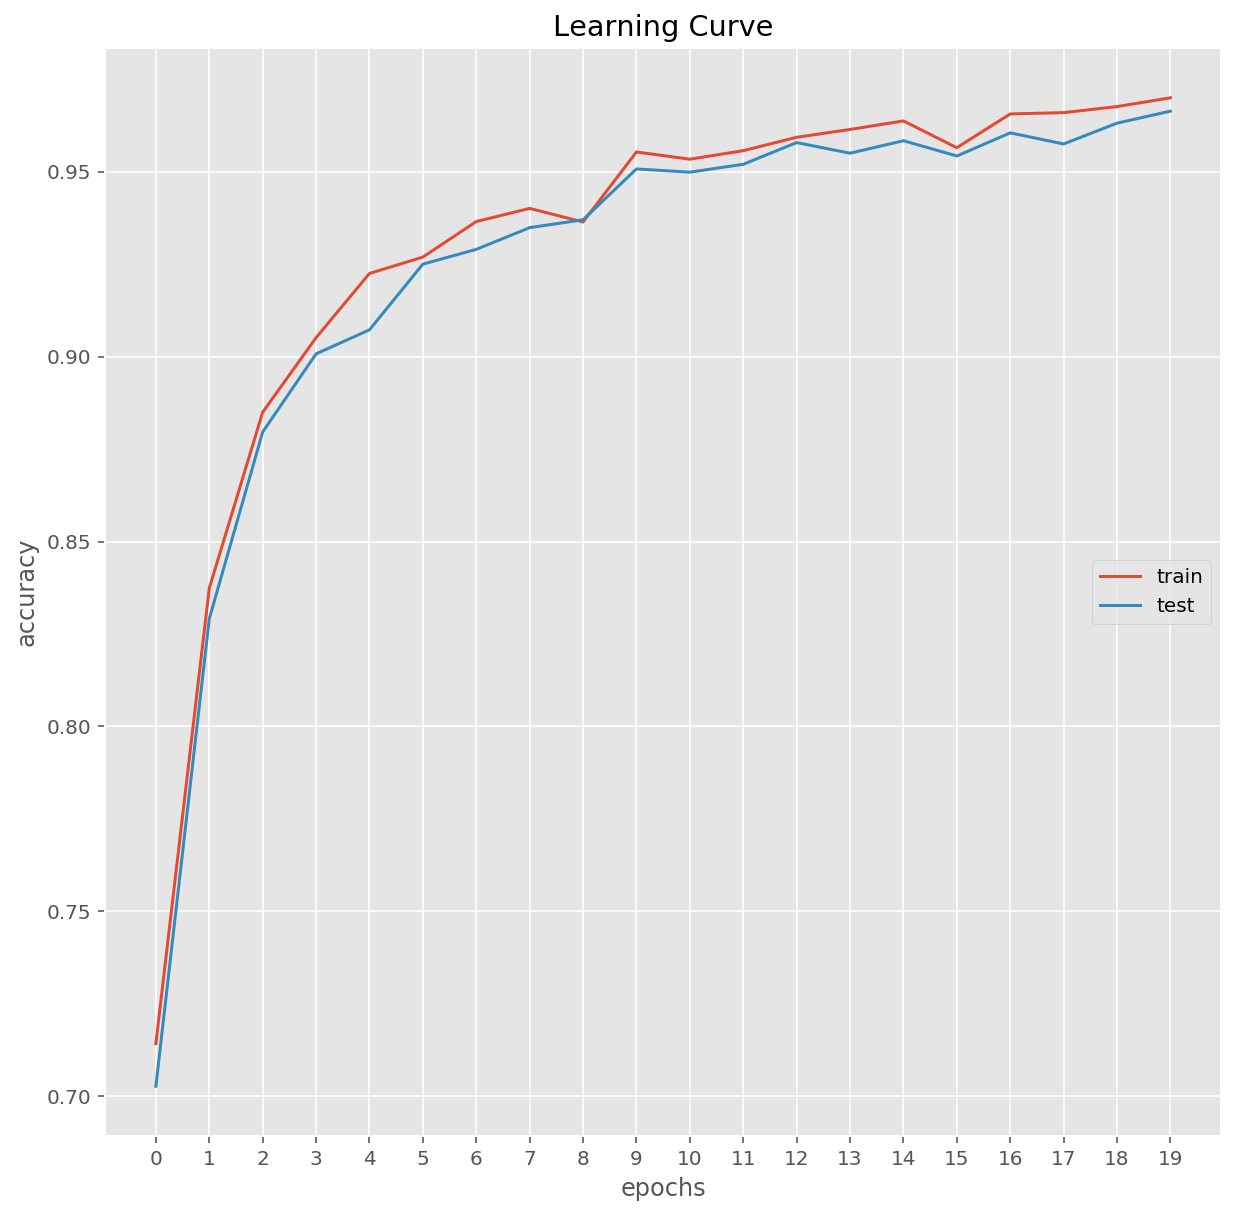

In [29]:
def make_network4_3(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .selu() 
            .conv([5, 5, 64])
            .max_pool()
            .selu() 
            .flatten()
            .dense(480)
            .selu() 
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network4_3(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network4.3.ckpt')

show_learning_curve(learning_curve)

Epoch:   0 Train Score: 0.706 Evaluation Score: 0.705
Epoch:   1 Train Score: 0.841 Evaluation Score: 0.837
Epoch:   2 Train Score: 0.860 Evaluation Score: 0.855
Epoch:   3 Train Score: 0.901 Evaluation Score: 0.892
Epoch:   4 Train Score: 0.898 Evaluation Score: 0.892
Epoch:   5 Train Score: 0.930 Evaluation Score: 0.922
Epoch:   6 Train Score: 0.935 Evaluation Score: 0.931
Epoch:   7 Train Score: 0.932 Evaluation Score: 0.925
Epoch:   8 Train Score: 0.920 Evaluation Score: 0.915
Epoch:   9 Train Score: 0.928 Evaluation Score: 0.928
Epoch:  10 Train Score: 0.941 Evaluation Score: 0.940
Epoch:  11 Train Score: 0.936 Evaluation Score: 0.932
Epoch:  12 Train Score: 0.958 Evaluation Score: 0.951
Epoch:  13 Train Score: 0.951 Evaluation Score: 0.942
Epoch:  14 Train Score: 0.959 Evaluation Score: 0.955
Epoch:  15 Train Score: 0.961 Evaluation Score: 0.956
Epoch:  16 Train Score: 0.952 Evaluation Score: 0.943
Epoch:  17 Train Score: 0.947 Evaluation Score: 0.946
Epoch:  18 Train Score: 0.96

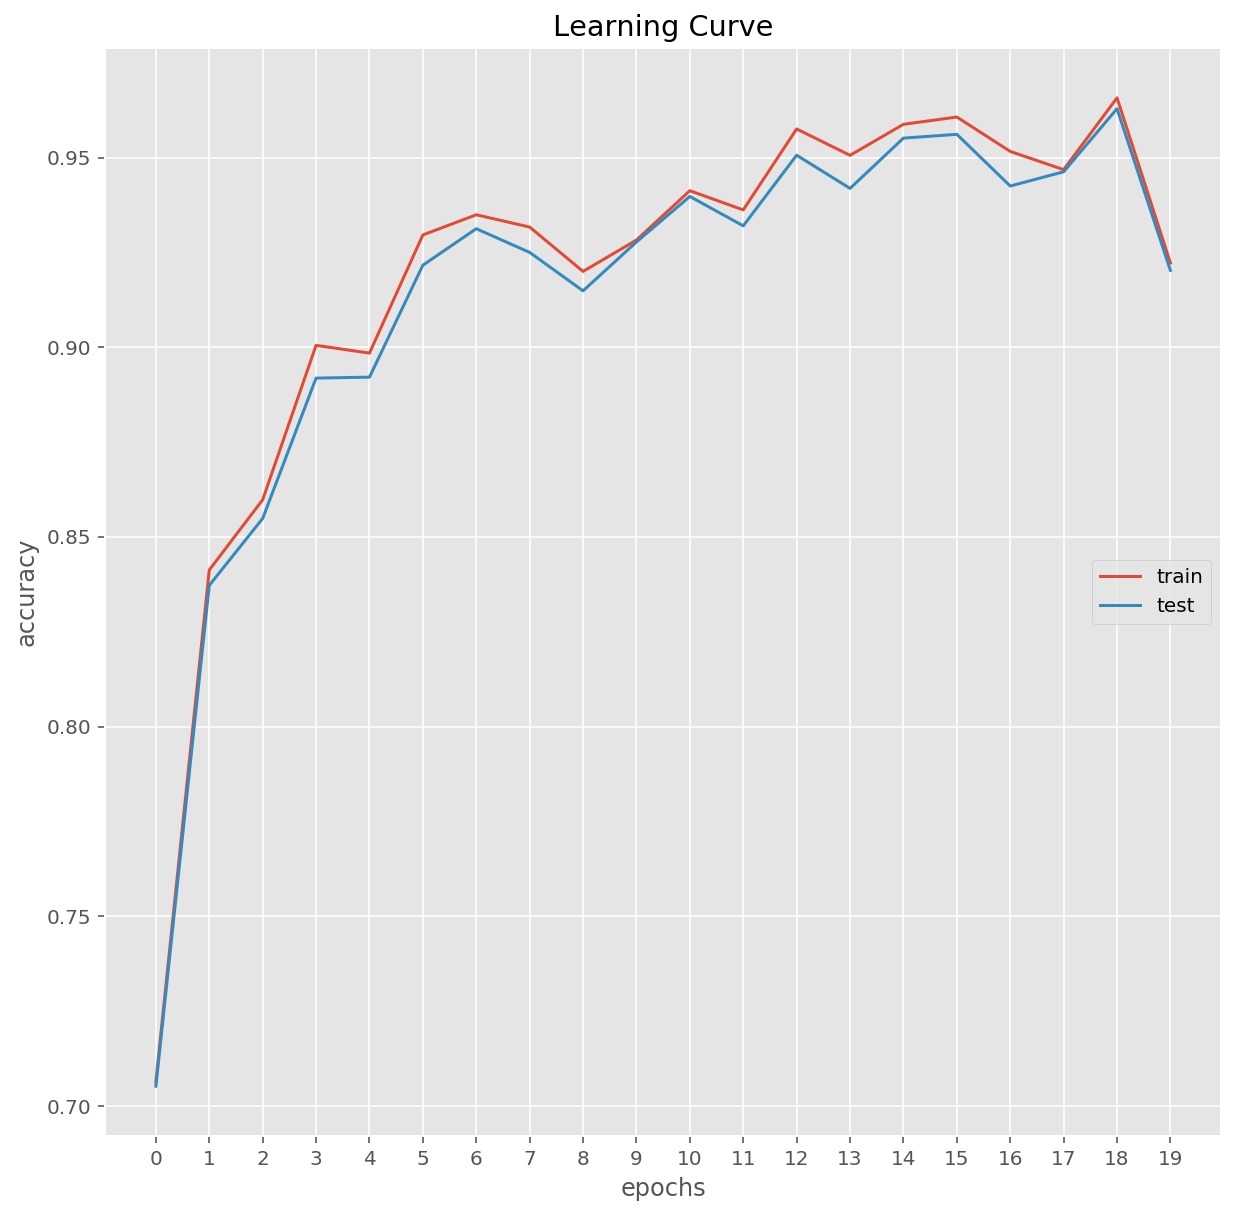

In [30]:
def make_network4_4(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .crelu() 
            .conv([5, 5, 64])
            .max_pool()
            .crelu() 
            .flatten()
            .dense(480)
            .crelu() 
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network4_4(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network4.4.ckpt')

show_learning_curve(learning_curve)

**Observation**:

No improvment.

## Network 5

ELU (Exponential Linear Unit) activation which is supposed to be faster to learn than ReLU.

Reference: http://www.picalike.com/blog/2015/11/28/relu-was-yesterday-tomorrow-comes-elu/

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Epoch:   0 Train Score: 0.791 Evaluation Score: 0.791
Epoch:   1 Train Score: 0.886 Evaluation Score: 0.883
Epoch:   2 Train Score: 0.910 Evaluation Score: 0.903
Epoch:   3 Train Score: 0.937 Evaluation Score: 0.932
Epoch:   4 Train Score: 0.943 Evaluation Score: 0.940
Epoch:   5 Train Score: 0.950 Evaluation Score: 0.944
Epoch:   6 Train Score: 0.957 Evaluation Score: 0.954
Epoch:   7 Train Score: 0.965 Evaluation Score: 0.963
Epoch:   8 Train Score: 0.964 Evaluation Score: 0.958
Epoch:   9 Train Score: 0.965 Evaluation Score: 0.961
Epoch:  10 Train Score: 0.960 Evaluation Score: 0.959
Epoch:  11 Train Score: 0.967 Evaluation Score: 0.963
Epoch:  12 Train Score: 0.971 Evaluation Score: 0.963
Epoch:  13 Train Score: 0.973 Evaluation Score: 0.971
Epoch:  14 Train Score: 0.976 Evaluation Score: 0.973
E

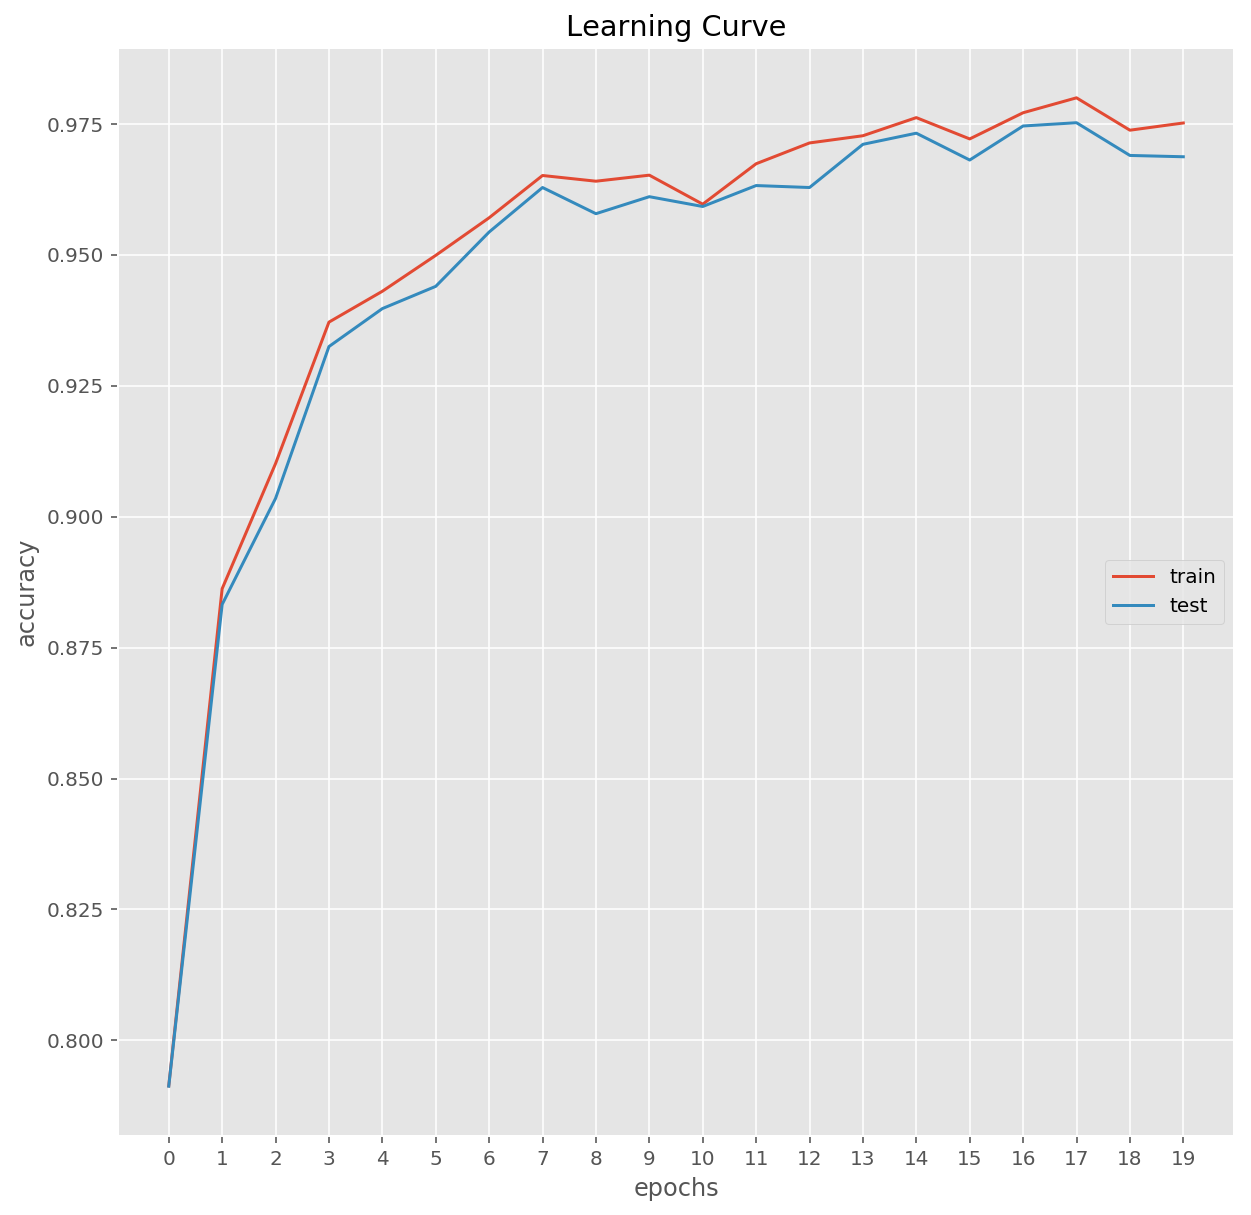

In [27]:
def make_network5(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .elu()              # <== ELU
            .conv([5, 5, 64])
            .max_pool()
            .elu()              # <== ELU
            .flatten()
            .dense(480)
            .elu()              # <== ELU
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network5(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network5.ckpt')
    
show_learning_curve(learning_curve)

**Observation**:

The permance is worse.  Also, it did not learn faster.

## Network 6

Let's try smaller initial weight value.

Epoch:   0 Train Score: 0.764 Evaluation Score: 0.760
Epoch:   1 Train Score: 0.903 Evaluation Score: 0.897
Epoch:   2 Train Score: 0.941 Evaluation Score: 0.937
Epoch:   3 Train Score: 0.954 Evaluation Score: 0.951
Epoch:   4 Train Score: 0.951 Evaluation Score: 0.946
Epoch:   5 Train Score: 0.964 Evaluation Score: 0.961
Epoch:   6 Train Score: 0.973 Evaluation Score: 0.969
Epoch:   7 Train Score: 0.980 Evaluation Score: 0.975
Epoch:   8 Train Score: 0.977 Evaluation Score: 0.970
Epoch:   9 Train Score: 0.982 Evaluation Score: 0.978
Epoch:  10 Train Score: 0.981 Evaluation Score: 0.978
Epoch:  11 Train Score: 0.981 Evaluation Score: 0.975
Epoch:  12 Train Score: 0.978 Evaluation Score: 0.974
Epoch:  13 Train Score: 0.982 Evaluation Score: 0.978
Epoch:  14 Train Score: 0.986 Evaluation Score: 0.983
Epoch:  15 Train Score: 0.991 Evaluation Score: 0.988
Epoch:  16 Train Score: 0.986 Evaluation Score: 0.981
Epoch:  17 Train Score: 0.989 Evaluation Score: 0.984
Epoch:  18 Train Score: 0.98

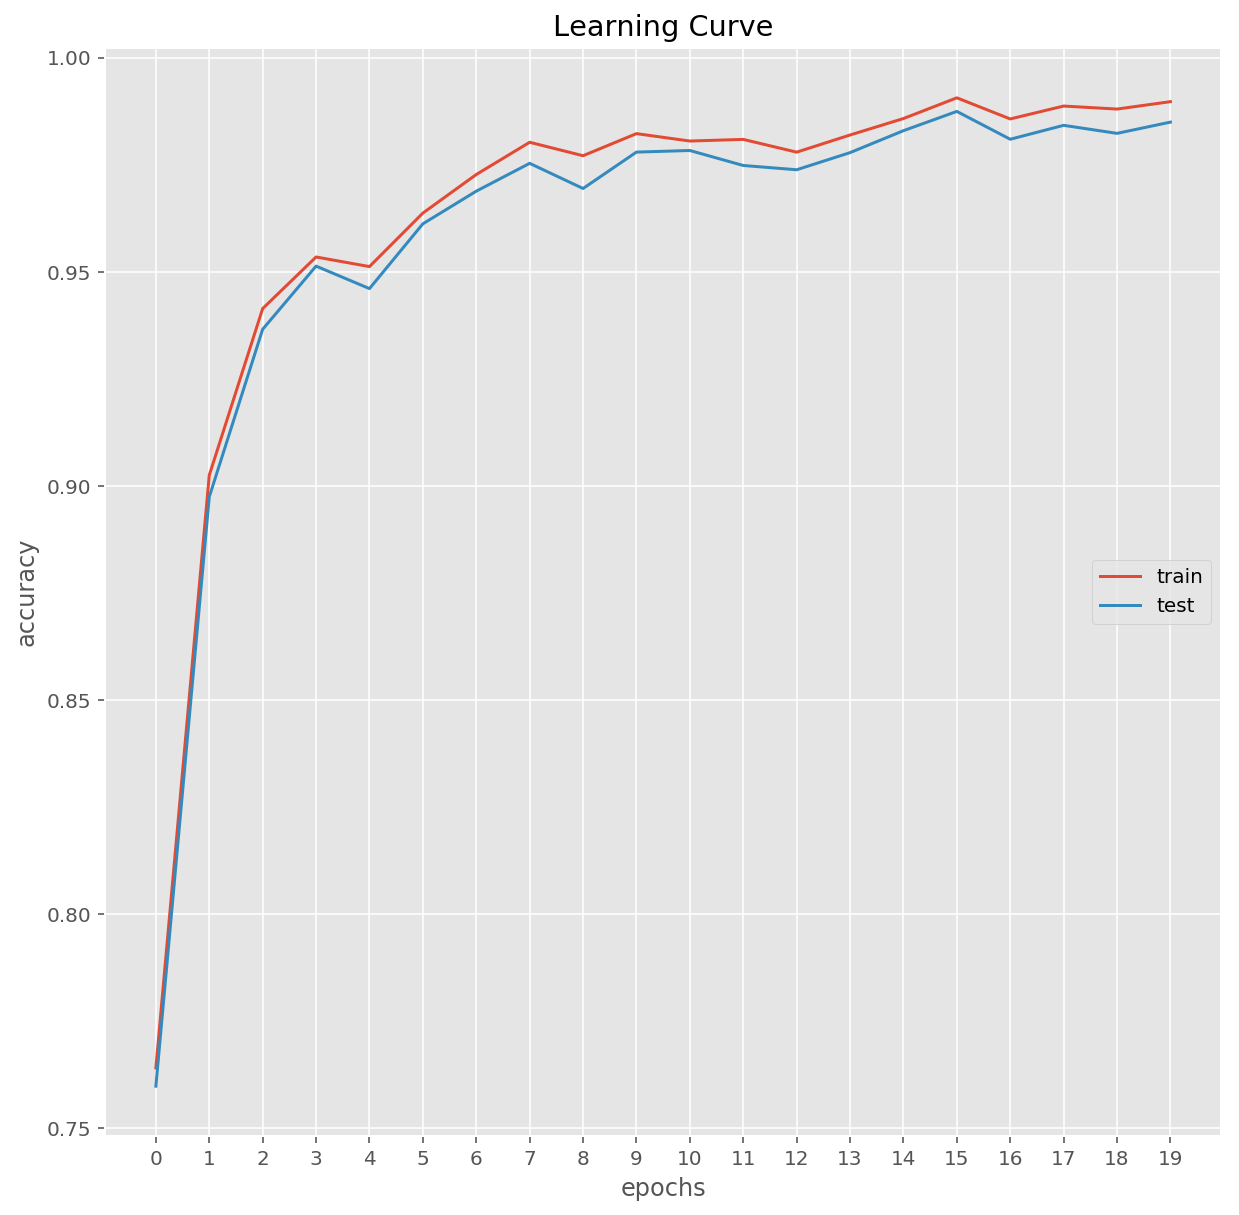

In [28]:
def make_network6(input_shape=INPUT_SHAPE):
    return (NeuralNetwork(weight_sigma=0.01) # <== smaller weight sigma
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network6(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network6.ckpt')
    
show_learning_curve(learning_curve)

**Observation**:

Not an improvement - a bit worse.

## Network 7

Adding one more dense layer.

Epoch:   0 Train Score: 0.846 Evaluation Score: 0.847
Epoch:   1 Train Score: 0.933 Evaluation Score: 0.934
Epoch:   2 Train Score: 0.947 Evaluation Score: 0.944
Epoch:   3 Train Score: 0.967 Evaluation Score: 0.968
Epoch:   4 Train Score: 0.968 Evaluation Score: 0.964
Epoch:   5 Train Score: 0.978 Evaluation Score: 0.973
Epoch:   6 Train Score: 0.976 Evaluation Score: 0.974
Epoch:   7 Train Score: 0.984 Evaluation Score: 0.981
Epoch:   8 Train Score: 0.983 Evaluation Score: 0.980
Epoch:   9 Train Score: 0.977 Evaluation Score: 0.976
Epoch:  10 Train Score: 0.985 Evaluation Score: 0.984
Epoch:  11 Train Score: 0.978 Evaluation Score: 0.973
Epoch:  12 Train Score: 0.983 Evaluation Score: 0.980
Epoch:  13 Train Score: 0.984 Evaluation Score: 0.981
Epoch:  14 Train Score: 0.988 Evaluation Score: 0.985
Epoch:  15 Train Score: 0.986 Evaluation Score: 0.983
Epoch:  16 Train Score: 0.982 Evaluation Score: 0.980
Epoch:  17 Train Score: 0.988 Evaluation Score: 0.985
Epoch:  18 Train Score: 0.99

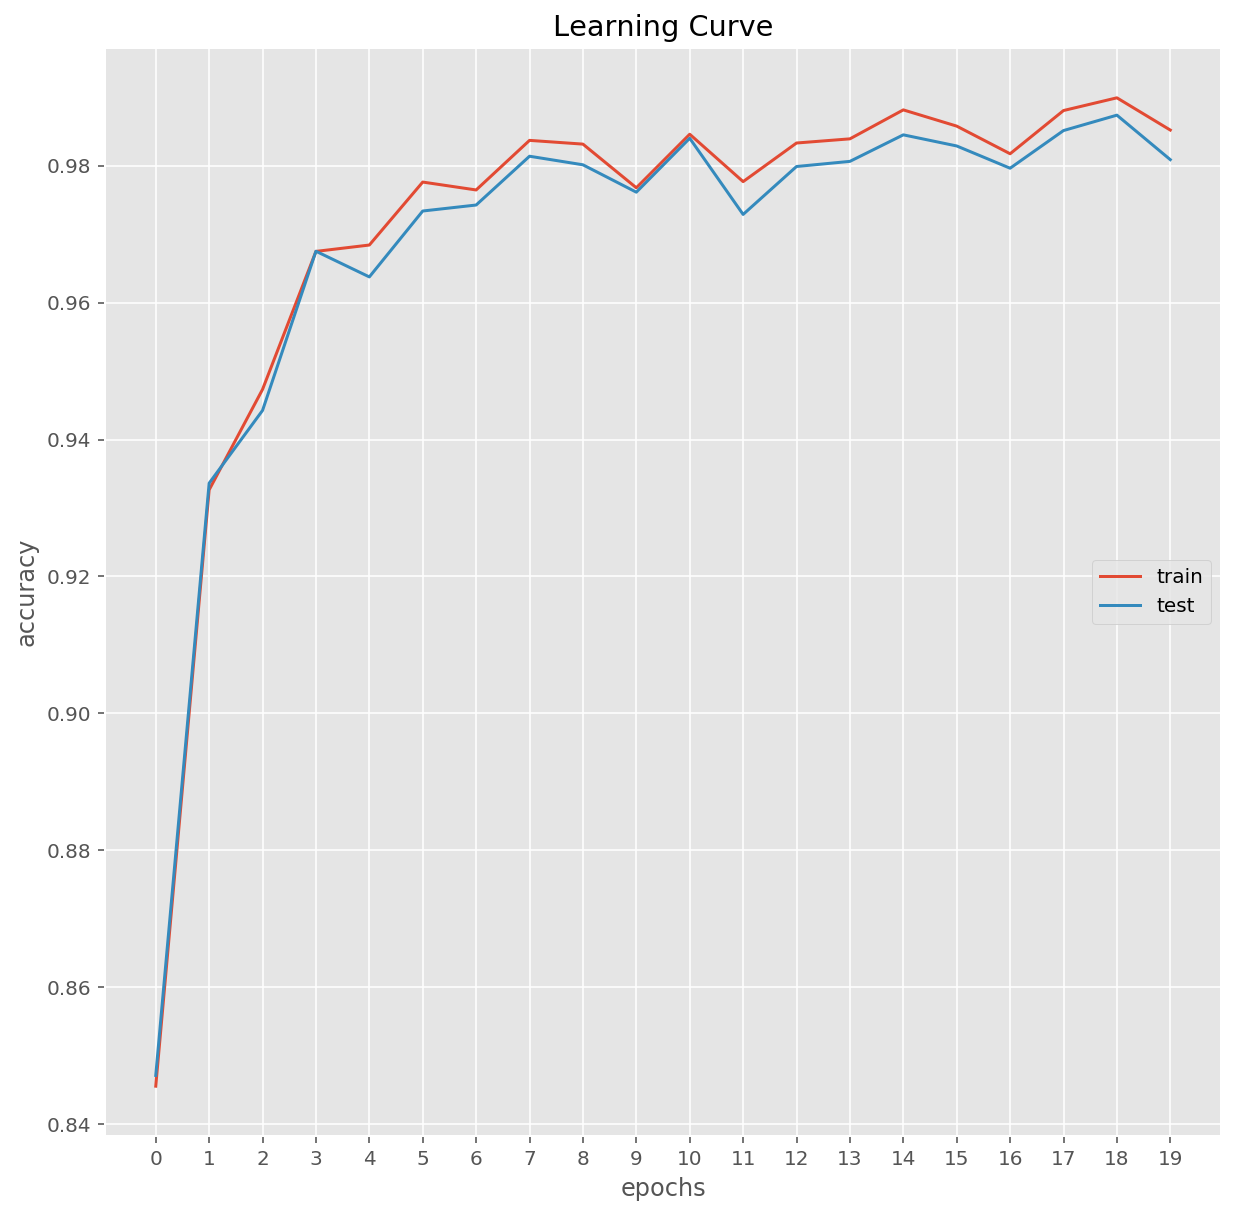

In [29]:
def make_network7(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .flatten()
            .dense(480)
            .relu()
            .dense(240) # <== one more dense layer
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network7(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network7.ckpt')
    
show_learning_curve(learning_curve)

**Observation**:

No improvment - a bit worse.

## Network 8

The same as Network 3 but using MaxPooling after ReLU.

Epoch:   0 Train Score: 0.819 Evaluation Score: 0.809
Epoch:   1 Train Score: 0.903 Evaluation Score: 0.900
Epoch:   2 Train Score: 0.946 Evaluation Score: 0.939
Epoch:   3 Train Score: 0.966 Evaluation Score: 0.961
Epoch:   4 Train Score: 0.969 Evaluation Score: 0.964
Epoch:   5 Train Score: 0.972 Evaluation Score: 0.970
Epoch:   6 Train Score: 0.978 Evaluation Score: 0.975
Epoch:   7 Train Score: 0.980 Evaluation Score: 0.976
Epoch:   8 Train Score: 0.986 Evaluation Score: 0.980
Epoch:   9 Train Score: 0.981 Evaluation Score: 0.980
Epoch:  10 Train Score: 0.985 Evaluation Score: 0.982
Epoch:  11 Train Score: 0.988 Evaluation Score: 0.987
Epoch:  12 Train Score: 0.988 Evaluation Score: 0.986
Epoch:  13 Train Score: 0.983 Evaluation Score: 0.980
Epoch:  14 Train Score: 0.989 Evaluation Score: 0.986
Epoch:  15 Train Score: 0.984 Evaluation Score: 0.983
Epoch:  16 Train Score: 0.991 Evaluation Score: 0.988
Epoch:  17 Train Score: 0.987 Evaluation Score: 0.984
Epoch:  18 Train Score: 0.98

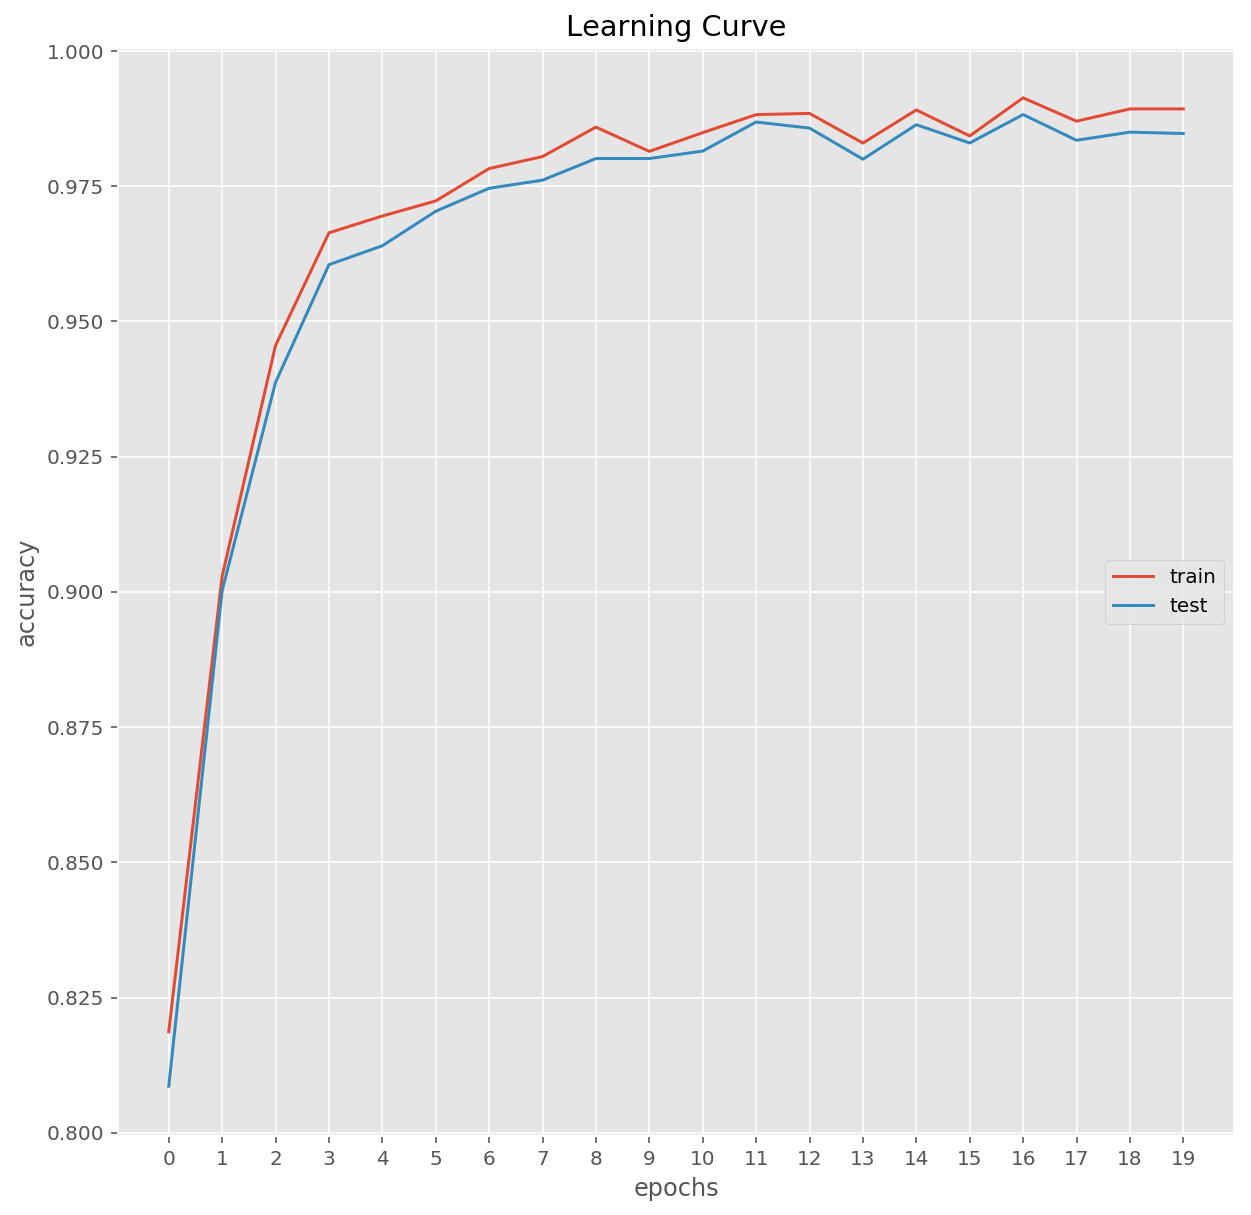

In [30]:
def make_network8(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .relu()     
            .max_pool() # <== after ReLU
            .conv([5, 5, 64])
            .relu()
            .max_pool() # <== after ReLU
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network8(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network8.ckpt')
    
show_learning_curve(learning_curve)

**Observation**:

No improvement - about the same.

## Network 9

Let's try 3 convolutional layers.

Epoch:   0 Train Score: 0.825 Evaluation Score: 0.826
Epoch:   1 Train Score: 0.916 Evaluation Score: 0.915
Epoch:   2 Train Score: 0.930 Evaluation Score: 0.926
Epoch:   3 Train Score: 0.941 Evaluation Score: 0.943
Epoch:   4 Train Score: 0.952 Evaluation Score: 0.955
Epoch:   5 Train Score: 0.972 Evaluation Score: 0.970
Epoch:   6 Train Score: 0.961 Evaluation Score: 0.958
Epoch:   7 Train Score: 0.972 Evaluation Score: 0.969
Epoch:   8 Train Score: 0.977 Evaluation Score: 0.974
Epoch:   9 Train Score: 0.968 Evaluation Score: 0.968
Epoch:  10 Train Score: 0.981 Evaluation Score: 0.979
Epoch:  11 Train Score: 0.982 Evaluation Score: 0.978
Epoch:  12 Train Score: 0.982 Evaluation Score: 0.976
Epoch:  13 Train Score: 0.983 Evaluation Score: 0.980
Epoch:  14 Train Score: 0.984 Evaluation Score: 0.979
Epoch:  15 Train Score: 0.981 Evaluation Score: 0.977
Epoch:  16 Train Score: 0.987 Evaluation Score: 0.982
Epoch:  17 Train Score: 0.987 Evaluation Score: 0.982
Epoch:  18 Train Score: 0.98

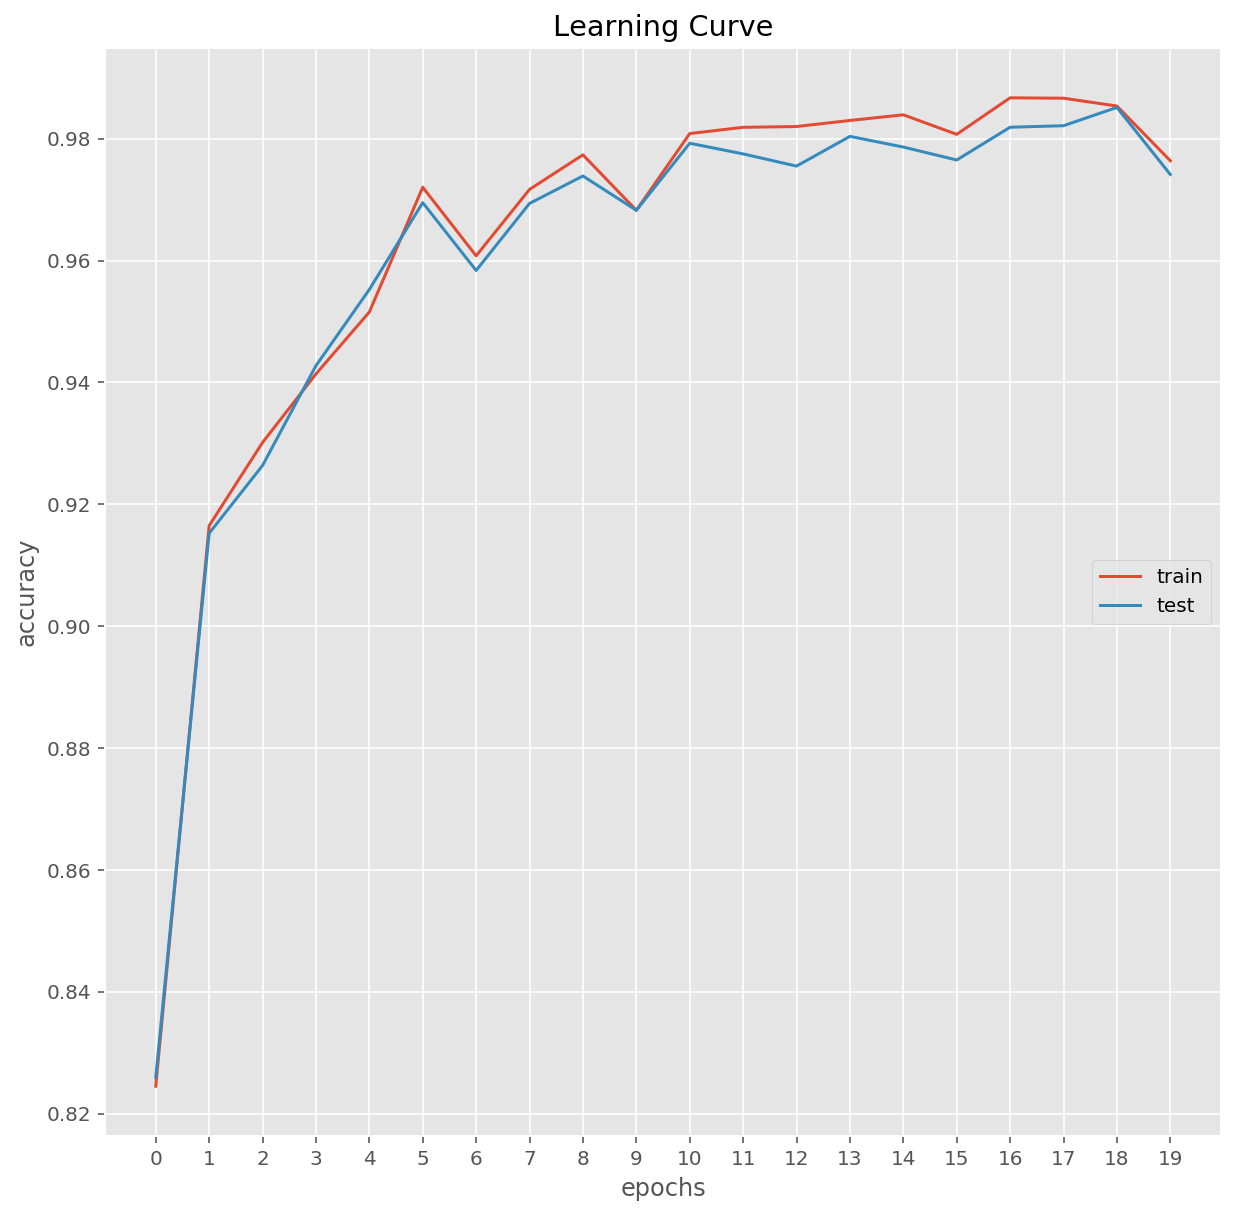

In [31]:
def make_network9(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .conv([3, 3, 64])  # <= smaller kernel here (the image is small by here)
            .max_pool()
            .relu()
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network9(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network9.ckpt')
    
show_learning_curve(learning_curve)

**Observation**

No improvment - a bit worse.

## Network 3 with Momentum Optimizer

In [ ]:
for momentum in [0.7, 0.8, 0.9]:
    with Session() as session:
        print('Momentum: {}'.format(momentum))
        optimizer = tf.train.MomentumOptimizer(learning_rate=0.5e-3, momentum=momentum)
        pipeline = build_pipeline(preprocessors, session, make_network3(), optimizer)
        train_evaluate(pipeline, epochs=20)
        session.save('checkpoint/network3_momentum_{}.ckpt'.format(momentum))
        print()

**Observation**:

Got worse.

## Network 3 with gradient decent optimizer

Epoch:   0 Train Score: 0.241 Evaluation Score: 0.239
Epoch:   1 Train Score: 0.325 Evaluation Score: 0.320
Epoch:   2 Train Score: 0.384 Evaluation Score: 0.384
Epoch:   3 Train Score: 0.430 Evaluation Score: 0.424
Epoch:   4 Train Score: 0.469 Evaluation Score: 0.455
Epoch:   5 Train Score: 0.497 Evaluation Score: 0.492
Epoch:   6 Train Score: 0.516 Evaluation Score: 0.528
Epoch:   7 Train Score: 0.552 Evaluation Score: 0.545
Epoch:   8 Train Score: 0.573 Evaluation Score: 0.571
Epoch:   9 Train Score: 0.598 Evaluation Score: 0.597
Epoch:  10 Train Score: 0.614 Evaluation Score: 0.614
Epoch:  11 Train Score: 0.629 Evaluation Score: 0.626
Epoch:  12 Train Score: 0.651 Evaluation Score: 0.648
Epoch:  13 Train Score: 0.662 Evaluation Score: 0.665
Epoch:  14 Train Score: 0.674 Evaluation Score: 0.670
Epoch:  15 Train Score: 0.694 Evaluation Score: 0.683
Epoch:  16 Train Score: 0.709 Evaluation Score: 0.706
Epoch:  17 Train Score: 0.713 Evaluation Score: 0.707
Epoch:  18 Train Score: 0.72

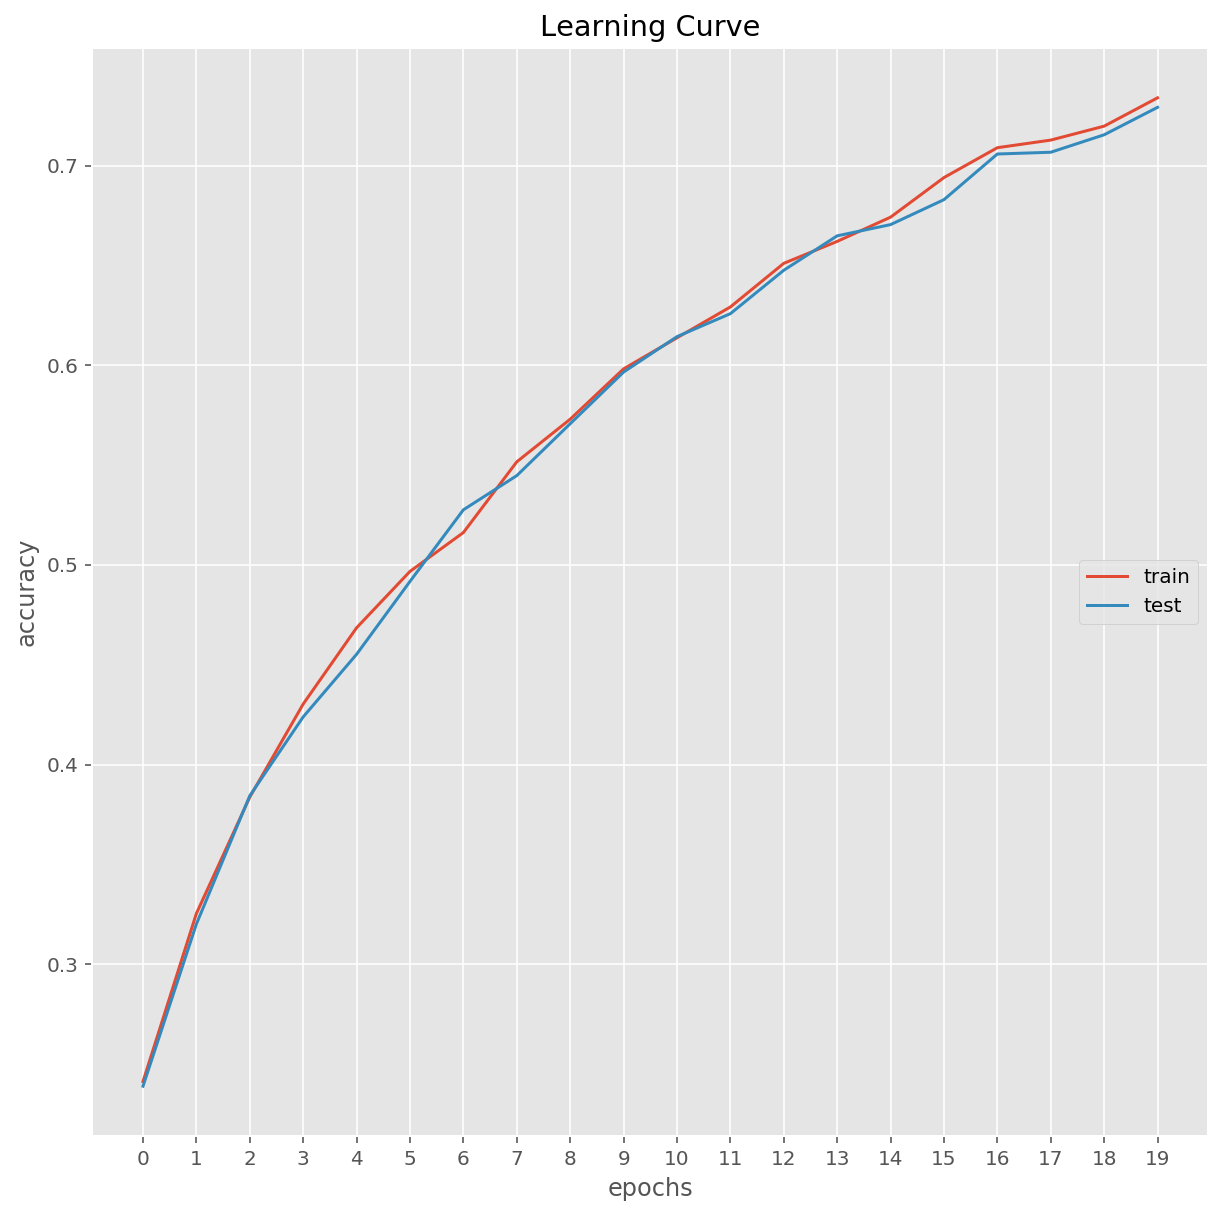

In [32]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.5e-3)
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), optimizer)
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network3_gradient_decent.ckpt')
show_learning_curve(learning_curve)

## Network 3 with Balanced Class Distribution of Training Data

Will it help to have a balanced class distribution of training data?

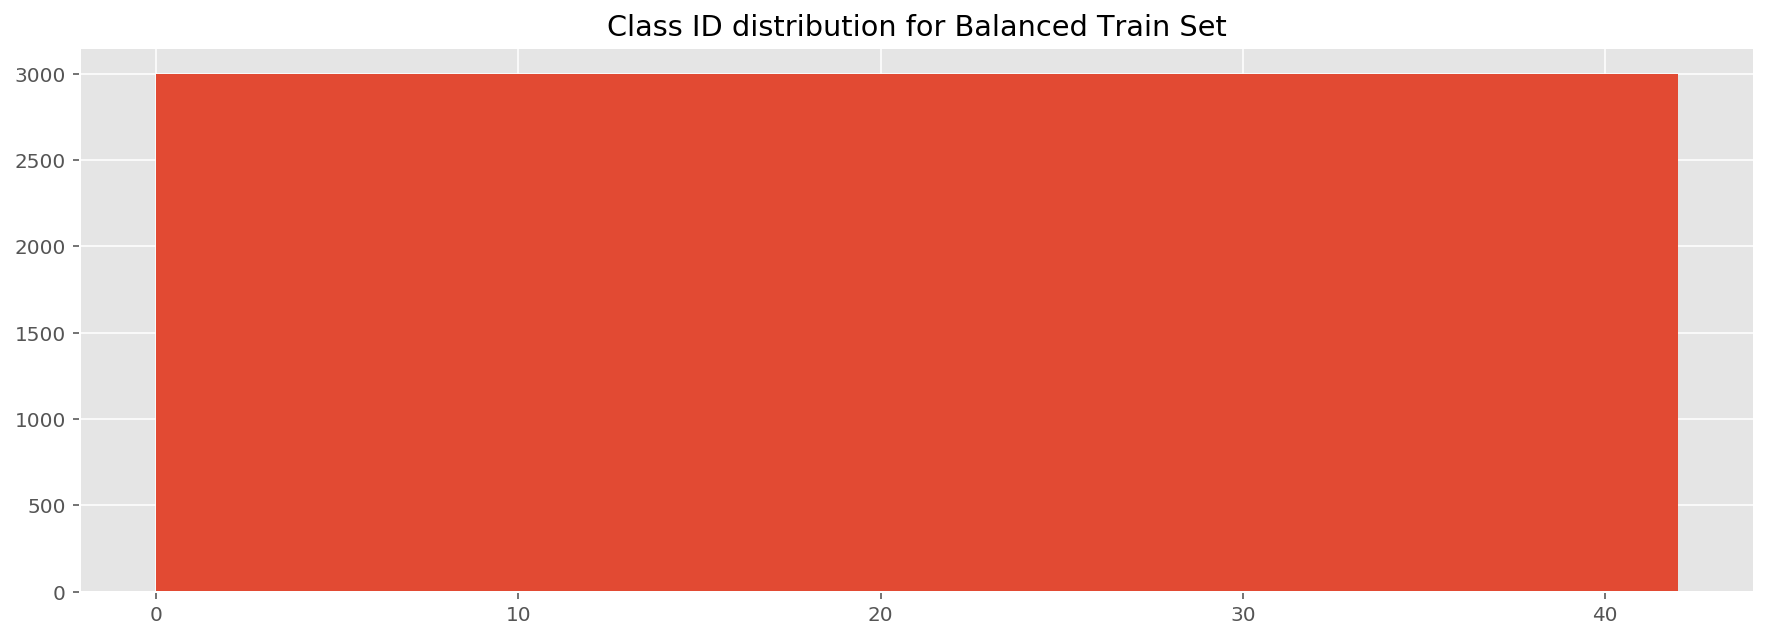

In [28]:
def balance_distribution(X, y, size):
    X_balanced = []
    y_balanced = []
    for c in range(N_CLASSES):
        data = X[y==c]
        indices = np.random.choice(sum(y==c), size)
        X_balanced.extend(X[y==c][indices])
        y_balanced.extend(y[y==c][indices])
    return np.array(X_balanced), np.array(y_balanced)

X_balanced, y_balanced = balance_distribution(X_train, y_train, 3000)

show_class_distribution(y_balanced, 'Balanced Train Set')

Let's try the balanced data set with our best pipeline (Network 3 with learning rate = 0.5e-3)

Epoch:   0 Train Score: 0.860 Evaluation Score: 0.814
Epoch:   1 Train Score: 0.923 Evaluation Score: 0.887
Epoch:   2 Train Score: 0.952 Evaluation Score: 0.932
Epoch:   3 Train Score: 0.964 Evaluation Score: 0.942
Epoch:   4 Train Score: 0.975 Evaluation Score: 0.962
Epoch:   5 Train Score: 0.971 Evaluation Score: 0.956
Epoch:   6 Train Score: 0.980 Evaluation Score: 0.969
Epoch:   7 Train Score: 0.980 Evaluation Score: 0.970
Epoch:   8 Train Score: 0.986 Evaluation Score: 0.973
Epoch:   9 Train Score: 0.980 Evaluation Score: 0.964
Epoch:  10 Train Score: 0.984 Evaluation Score: 0.980
Epoch:  11 Train Score: 0.986 Evaluation Score: 0.972
Epoch:  12 Train Score: 0.985 Evaluation Score: 0.973
Epoch:  13 Train Score: 0.987 Evaluation Score: 0.978
Epoch:  14 Train Score: 0.986 Evaluation Score: 0.976
Epoch:  15 Train Score: 0.991 Evaluation Score: 0.983
Epoch:  16 Train Score: 0.988 Evaluation Score: 0.981
Epoch:  17 Train Score: 0.985 Evaluation Score: 0.976
Epoch:  18 Train Score: 0.98

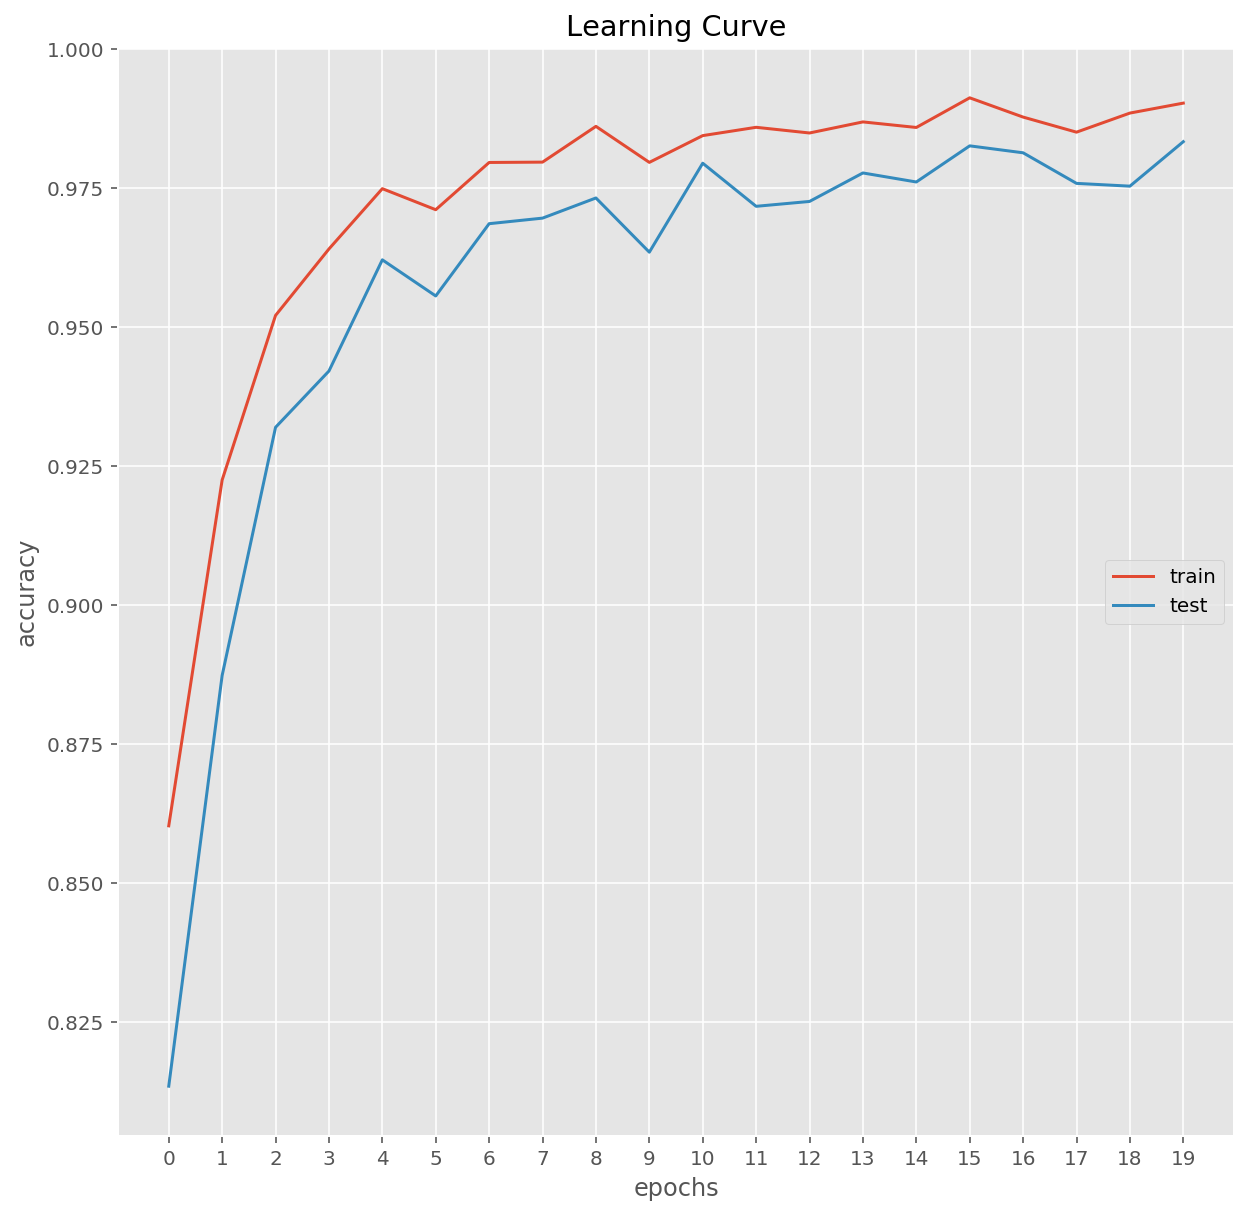

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20, train=(X_balanced, y_balanced)) # <== using the balanced train set
    session.save('checkpoint/network3_with_balanced_data.ckpt')

show_learning_curve(learning_curve)

**Observation**:

The validation accuracy is much worse than before.  This is likely because the distribution is different, indicating the network is learning the distribution which is different from the validation set.  Assuming the test set has the same kind of validation (we should not check the test set at this stage), using the balance set may not be a good idea.

Instead, we should do more epochs so that minor classes are more visible to the network.

## Network 3 with even more epochs

Let's just try with much more epochs.

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(0.5e-3)) 
    learning_curve = train_evaluate(pipeline, epochs=100)
    
show_learning_curve(learning_curve)

Epoch:   0 Train Score: 0.858 Evaluation Score: 0.853
Epoch:   1 Train Score: 0.926 Evaluation Score: 0.921
Epoch:   2 Train Score: 0.953 Evaluation Score: 0.952
Epoch:   3 Train Score: 0.964 Evaluation Score: 0.965
Epoch:   4 Train Score: 0.971 Evaluation Score: 0.967
Epoch:   5 Train Score: 0.973 Evaluation Score: 0.974
Epoch:   6 Train Score: 0.978 Evaluation Score: 0.972
Epoch:   7 Train Score: 0.985 Evaluation Score: 0.983
Epoch:   8 Train Score: 0.979 Evaluation Score: 0.976
Epoch:   9 Train Score: 0.987 Evaluation Score: 0.985
Epoch:  10 Train Score: 0.984 Evaluation Score: 0.980
Epoch:  11 Train Score: 0.985 Evaluation Score: 0.982
Epoch:  12 Train Score: 0.984 Evaluation Score: 0.980
Epoch:  13 Train Score: 0.988 Evaluation Score: 0.984
Epoch:  14 Train Score: 0.987 Evaluation Score: 0.982
Epoch:  15 Train Score: 0.987 Evaluation Score: 0.981
Epoch:  16 Train Score: 0.988 Evaluation Score: 0.984


**Observation**:

It performs much better now but the last several epochs are not really helping for the network to learn.  I should try smaller learning rate to see how it goes.

## Network 3 with even lower learning rate (and more epochs)

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(1.0e-4))
    learning_curve = train_evaluate(pipeline, epochs=500)
    session.save('checkpoint/network3_epochs-500_lr-1.0e-4.ckpt')    
    
show_learning_curve(learning_curve)

NameError: name 'make_network3' is not defined

**Observation**:

The performance has improved.  It appears that 100 epochs are enough to achieve this performance.  

Is this as good as it can get?

## Network 10 

Can we make the network more robust?  How about a dropout?

In [ ]:
def make_network10(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .dropout(keep_prob=0.5)
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network10(), make_adam(1.0e-4))
    learning_curve = train_evaluate(pipeline, epochs=500)
    session.save('checkpoint/network10.ckpt')
    
show_learning_curve(learning_curve)

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network10())
    session.load('checkpoint/network10.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

**Observation**:

The validation performance is more stable now.  500 epochs is probably overkill.

## Preprocessing (Again)

These are extra experiments to see if we can improve the pipeline further.  I did experiment with these preprocessing before the network was fully trained and the effect was sort of random (sometimes good, other times bad).  As such I discarded the idea.

But I'm re-doing it to see if it has positive effect after the network is fully trained.  

The conclusion in short is that they don't work well.  This is very likely due to the network trained without them.  It seems abundantly clear in hindsight.  

The below are a series of unfortunately experiments, proving how bad idea it was to change preprocessing after the training.


### Image Enhancement

Taking a weighted average of the original image and the blurred image to make in order to smooth out the noises.

In [ ]:
def enhance_image(image, ksize, weight):
    blurred = cv2.GaussianBlur(image, (ksize, ksize), 0)
    return cv2.addWeighted(image, weight, blurred, -weight, image.mean())

In [ ]:
for ksize in [5, 7, 9, 11]:
    for weight in [4, 6, 8, 10]:
        print('Enhancer: k={} w={}'.format(ksize, weight))
        with Session() as session:
            enhancer = lambda x: enhance_image(x, ksize, weight)
            functions = [loader, augmenter, enhancer, normalizer]
            pipeline = build_pipeline(functions, session, make_network10())
            session.load('checkpoint/network10.ckpt')
            score = pipeline.score(X_valid, y_valid)
            print('Validation Score: {}'.format(score))
        print()

In [ ]:
enhancer = lambda x: enhance_image(x, 9, 8)

In [ ]:
show_images(sample_data[10:], cols=10)
show_images(sample_data[10:], cols=10, func=enhancer)

**Observations**:

I tried these earlier and the result was pretty random.  Sometimes, it improves but not other times.  

If I do this with the pre-trained network as shown above, the result is worse as the network is already tuned for images not using the enhancements.  

Perhaps, I should try to use it during the training to see if it speed up the training or not.

However, as the network performs really well without this, my conclusion is not to use this filter at all.

## Histogram Equalizaition

In [ ]:
def equalizer(image):
    image = image.copy()
    for i in range(3):
        image[:, :, i] = cv2.equalizeHist(image[:, :, i])
    return image

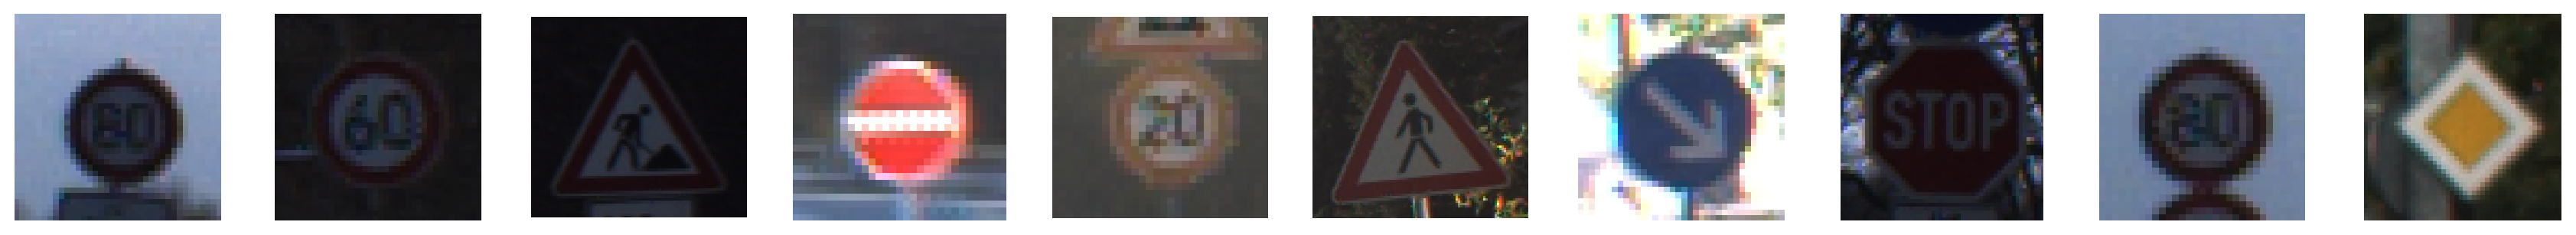

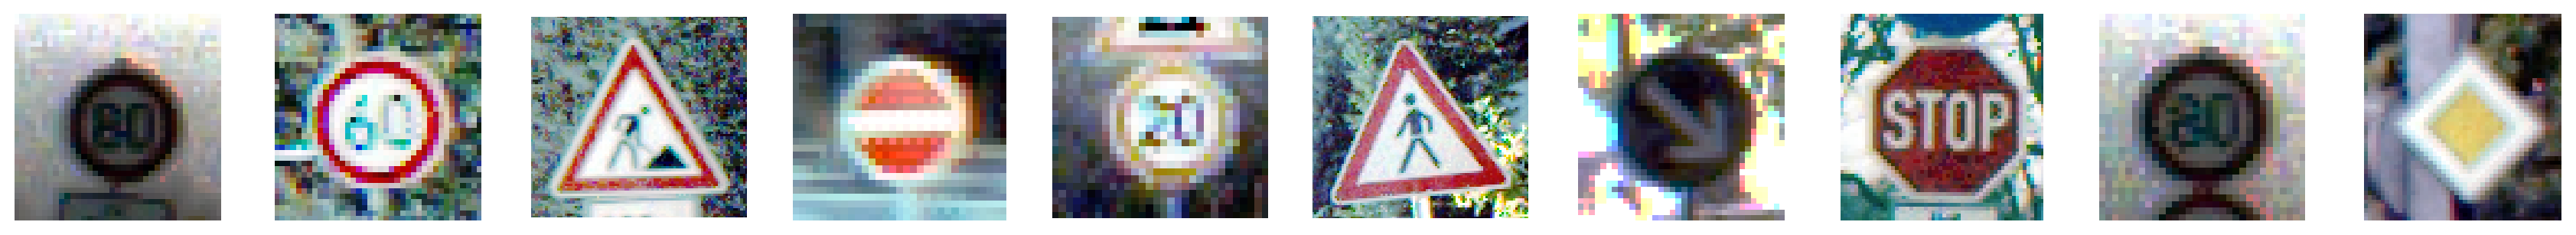

In [58]:
show_images(sample_data[10:], cols=10)
show_images(sample_data[10:], cols=10, func=equalizer)

In [59]:
with Session() as session:
    functions = [loader, augmenter, equalizer, normalizer]
    pipeline = build_pipeline(functions, session, make_network10())
    session.load('checkpoint/network10.ckpt')
    score = pipeline.score(X_valid, y_valid)
    print('Validation Score: {:.3f}'.format(score))

Validation Score: 0.904


**Observation**:

If this was tried before the network was fully trained, it might have made the learning easier.  Earlier, I played with this preprocessing before training but it was not producing better results than the enhancer.  Maybe I will re-try that one day.

How about combine the histogram equalizer and the enhancer?

In [65]:
with Session() as session:
    functions = [loader, augmenter, equalizer, enhancer, normalizer]
    pipeline = build_pipeline(functions, session, make_network10())
    session.load('checkpoint/network10.ckpt')
    score = pipeline.score(X_valid, y_valid)
    print(score)

0.67775


**Observaton**:

The histogram equalizer + enhancer does not improve.

## Min Max Normalization

http://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html#normalize

In [62]:
def min_max_norm(image):
    return cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

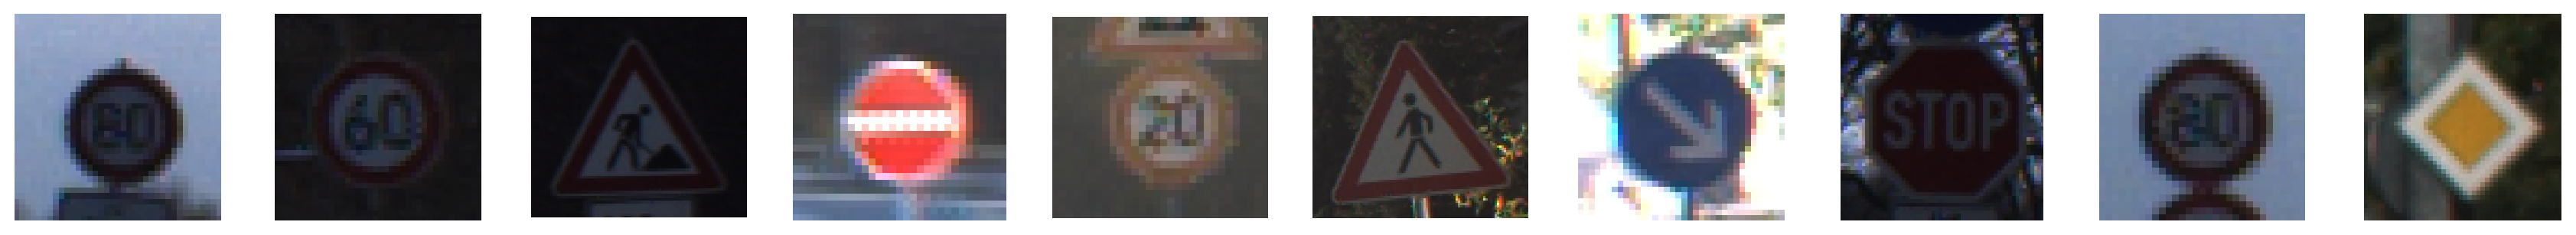

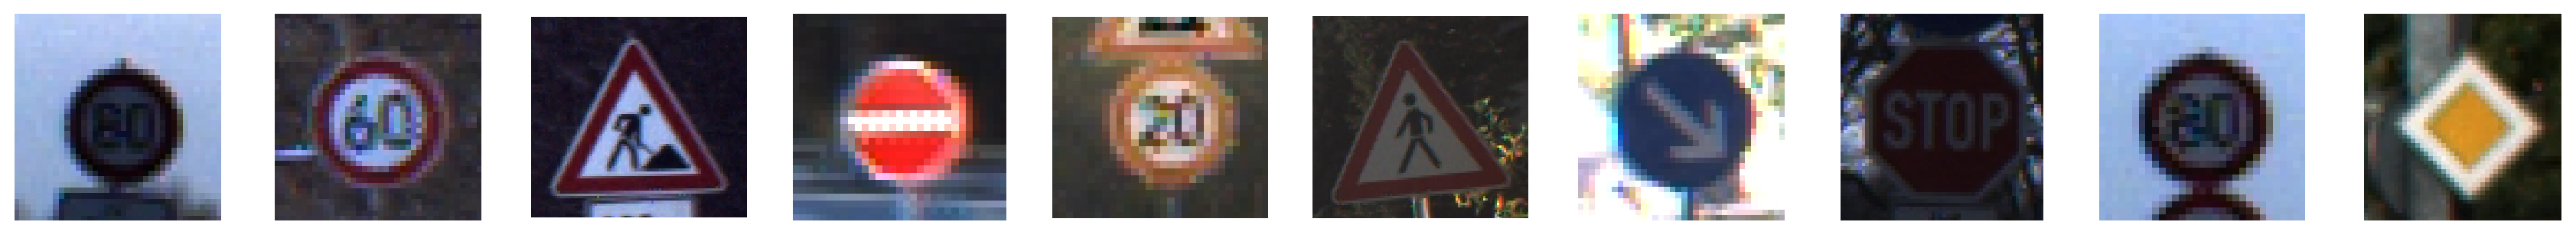

In [63]:
show_images(sample_data[10:], cols=10)
show_images(sample_data[10:], cols=10, func=min_max_norm)

In [66]:
with Session() as session:
    functions = [loader, augmenter, min_max_norm, normalizer]
    pipeline = build_pipeline(functions, session, make_network10())
    session.load('checkpoint/network10.ckpt')
    score = pipeline.score(X_valid, y_valid)
    print(score)

0.99825


**Observaton**:

I tried Min-Max normalizer before fully training the network and did not get any good results.

This experiment here is just to check if it can do any good once the network is fully trained.  It proves the otherwise.

Let's try the combination with the enhancer.

In [67]:
with Session() as session:
    functions = [loader, augmenter, min_max_norm, enhancer, normalizer]
    pipeline = build_pipeline(functions, session, make_network10())
    session.load('checkpoint/network10.ckpt')
    score = pipeline.score(X_valid, y_valid)
    print(score)

0.79925


**Observation**:

The same argument here.  I don't need this.

## Test Dataset

Test images are in one folder.  So, we can simply load them as follows:

Test images do not have category folders but all are kept in one place with one label file.

```
data
 + Final_Test
    + Images
        + 00000.ppm
        + 00001.ppm
        + ...
        + GT-final_test.csv      # Extended annotations including class ids
        + GT-final_test.test.csv
```

I also downloaded GT-final_test.csv which contains extended annotations including class ids for test images.

In [32]:
TEST_IMAGE_DIR = '/datasets/tmp/cg181fcp/data/Final_Test/Images'

# Note: GT-final_test.csv comes with class IDs (GT-final_test.test.csv does not)
test_df = pd.read_csv(os.path.join(TEST_IMAGE_DIR, 'GT-final_test.csv'), sep=';')
test_df['Filename'] = test_df['Filename'].apply(lambda x: os.path.join(TEST_IMAGE_DIR, x))
test_df.head()

Filename  Width  Height  Roi.X1  \
0  /datasets/tmp/cg181fcp/data/Final_Test/Images/...     53      54       6   
1  /datasets/tmp/cg181fcp/data/Final_Test/Images/...     42      45       5   
2  /datasets/tmp/cg181fcp/data/Final_Test/Images/...     48      52       6   
3  /datasets/tmp/cg181fcp/data/Final_Test/Images/...     27      29       5   
4  /datasets/tmp/cg181fcp/data/Final_Test/Images/...     60      57       5   

   Roi.Y1  Roi.X2  Roi.Y2  ClassId  
0       5      48      49       16  
1       5      36      40        1  
2       6      43      47       38  
3       5      22      24       33  
4       5      55      52       11

In [33]:
print("Number of test images: {:>5}".format(test_df.shape[0]))

Number of test images: 12630


In [34]:
X_test = test_df['Filename'].values
y_test = test_df['ClassId'].values

In [35]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_vgg())
    session.load('checkpoint/network_vgg_lower_learning_rate.ckpt')
    score = pipeline.score(X_test, y_test)
    print('Test Score: {}'.format(score))

INFO:tensorflow:Restoring parameters from checkpoint/network_vgg_lower_learning_rate.ckpt
Test Score: 0.9517814726840855


**Observation**:

It's about 96% accuracy.  For the simple network like this one, it did a really good work.

I probably need more complex network than this one but I'd need a better hardware to train one of those.  Even with AWS g2 instance is not fast enough to run 500 epochs.

# Testing with Random Images

In [27]:
#X_new = np.array(glob.glob('images/sign*.jpg') + 
#                 glob.gl/ob('images/sign*.png'))
X_new = np.array(glob.glob('newImage/Screen*'))

In [28]:
new_images = [plt.imread(path) for path in X_new]

--------------------------------------------------------------------------------
New Images for Random Testing
--------------------------------------------------------------------------------


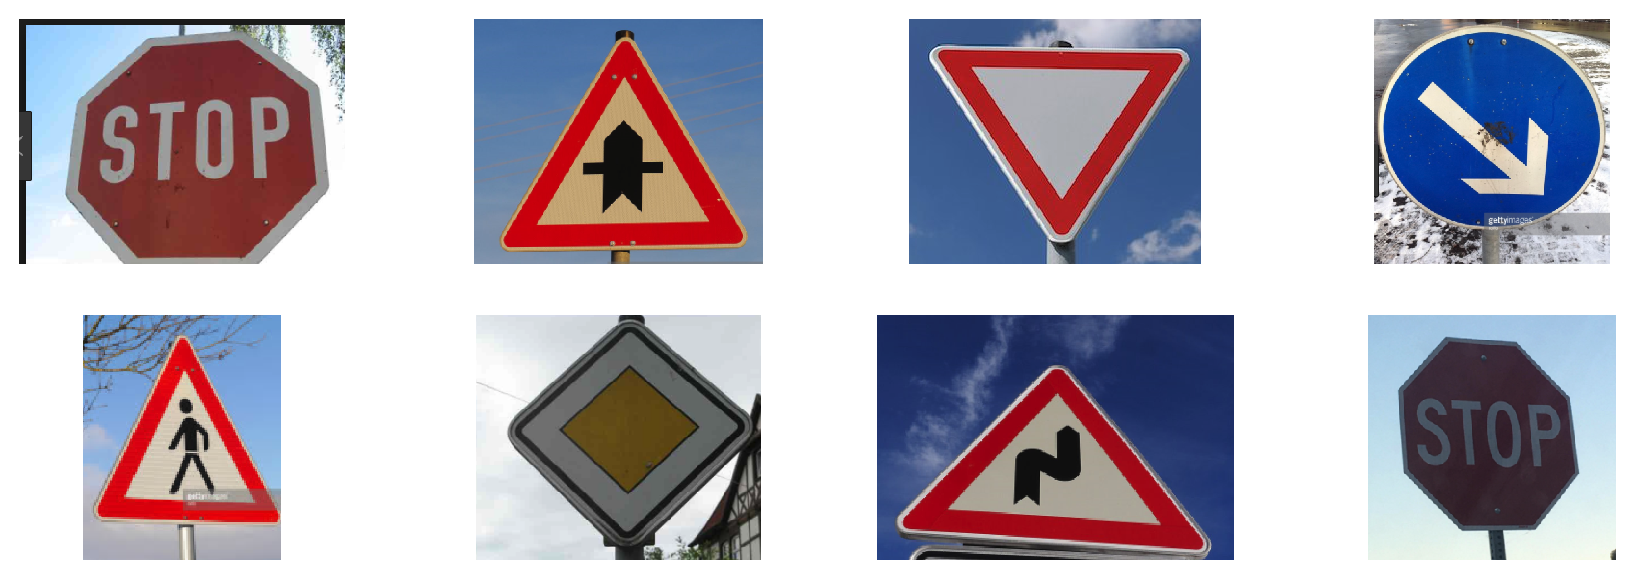

In [29]:
print('-' * 80)
print('New Images for Random Testing')
print('-' * 80)

plt.figure(figsize=(15,5))
for i, image in enumerate(new_images):
    plt.subplot(2,len(X_new)//2,i+1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])    
plt.show()

In [30]:
print('getting top 5 results')

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_vgg())
    session.load('checkpoint/network_vgg_lower_learning_rate.ckpt')  
    prob = pipeline.predict_proba(X_new)
    estimator = pipeline.steps[-1][1]
    top_5_prob, top_5_pred = estimator.top_k_

print('done')

getting top 5 results
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

INFO:tensorflow:Restoring parameters from checkpoint/network_vgg_lower_learning_rate.ckpt
done


--------------------------------------------------------------------------------
Top 5 Predictions
--------------------------------------------------------------------------------


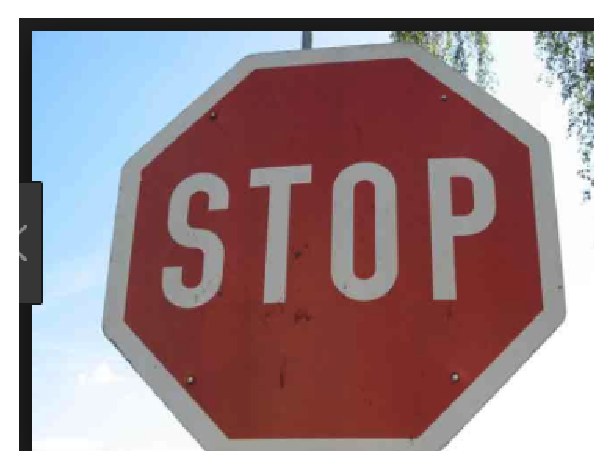

   14: Stop                                               ( 99.6611058712%)
   13: Yield                                              (  0.2470416715%)
   15: No vehicles                                        (  0.0852939731%)
    1: Speed limit (30km/h)                               (  0.0041341656%)
    5: Speed limit (80km/h)                               (  0.0007888906%)
--------------------------------------------------------------------------------


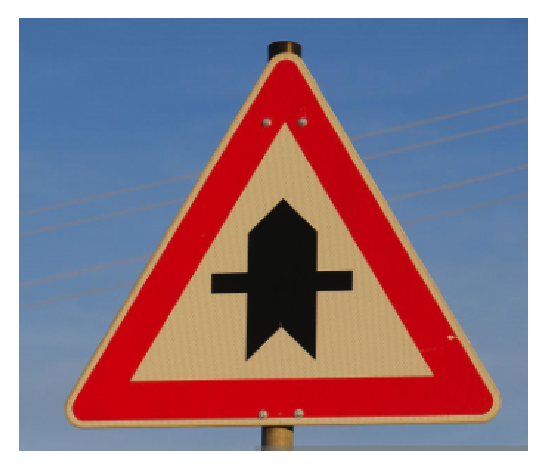

   11: Right-of-way at the next intersection              ( 99.9461352825%)
   30: Beware of ice/snow                                 (  0.0448287698%)
   28: Children crossing                                  (  0.0038639602%)
   25: Road work                                          (  0.0022605396%)
   18: General caution                                    (  0.0009283334%)
--------------------------------------------------------------------------------


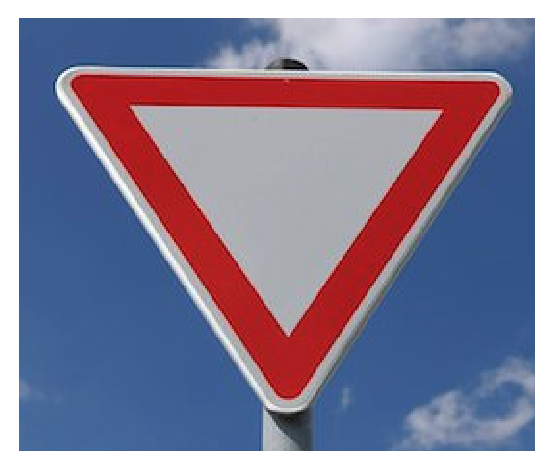

   13: Yield                                              (100.0000000000%)
   15: No vehicles                                        (  0.0000000000%)
   14: Stop                                               (  0.0000000000%)
    9: No passing                                         (  0.0000000000%)
   12: Priority road                                      (  0.0000000000%)
--------------------------------------------------------------------------------


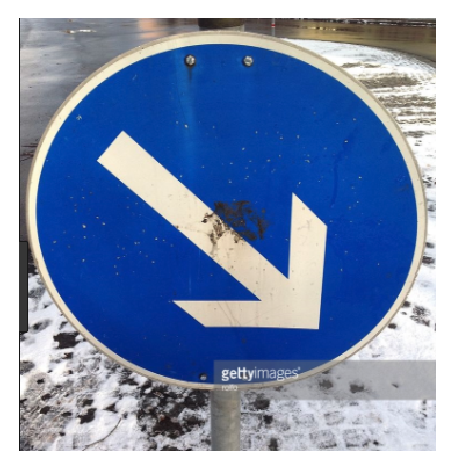

   38: Keep right                                         (100.0000000000%)
   34: Turn left ahead                                    (  0.0000000000%)
   40: Roundabout mandatory                               (  0.0000000000%)
   36: Go straight or right                               (  0.0000000000%)
    5: Speed limit (80km/h)                               (  0.0000000000%)
--------------------------------------------------------------------------------


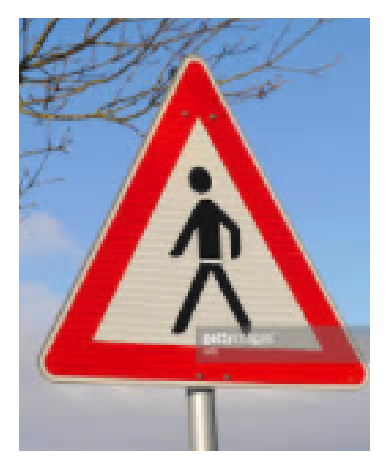

   24: Road narrows on the right                          ( 63.7713253498%)
   27: Pedestrians                                        ( 35.9920591116%)
   18: General caution                                    (  0.1654576277%)
   26: Traffic signals                                    (  0.0666863285%)
   11: Right-of-way at the next intersection              (  0.0039394774%)
--------------------------------------------------------------------------------


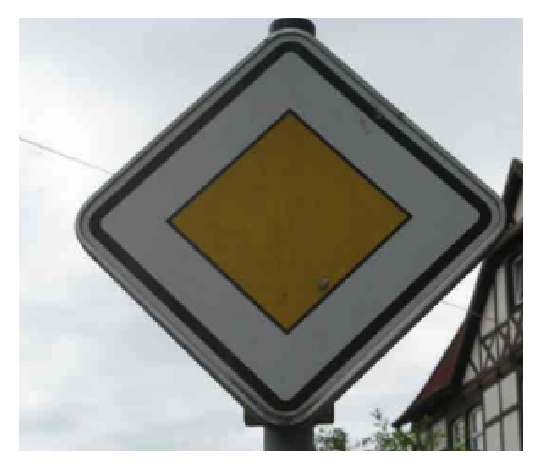

   12: Priority road                                      (100.0000000000%)
   13: Yield                                              (  0.0000000000%)
   32: End of all speed and passing limits                (  0.0000000000%)
   18: General caution                                    (  0.0000000000%)
   29: Bicycles crossing                                  (  0.0000000000%)
--------------------------------------------------------------------------------


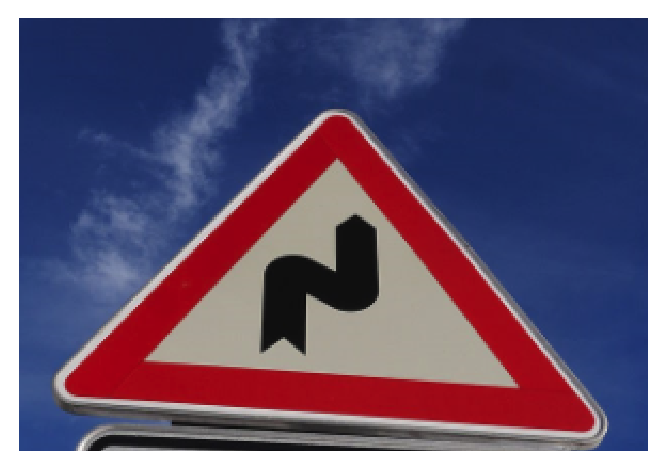

   28: Children crossing                                  ( 85.1045668125%)
   20: Dangerous curve to the right                       ( 14.5452961326%)
   23: Slippery road                                      (  0.2962090308%)
   30: Beware of ice/snow                                 (  0.0295573816%)
   11: Right-of-way at the next intersection              (  0.0177645488%)
--------------------------------------------------------------------------------


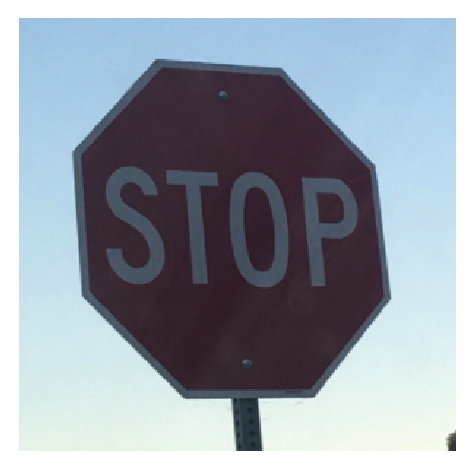

    3: Speed limit (60km/h)                               ( 99.7069716454%)
   32: End of all speed and passing limits                (  0.2697262214%)
   15: No vehicles                                        (  0.0163396166%)
   13: Yield                                              (  0.0032476139%)
    8: Speed limit (120km/h)                              (  0.0021493090%)
--------------------------------------------------------------------------------


In [31]:
print('-' * 80)
print('Top 5 Predictions')
print('-' * 80)

for i, (preds, probs, image) in enumerate(zip(top_5_pred, top_5_prob, new_images)):
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    for pred, prob in zip(preds.astype(int), probs):
        sign_name = SIGN_NAMES[pred]
        print('{:>5}: {:<50} ({:>14.10f}%)'.format(pred, sign_name, prob*100.0))
    print('-' * 80)    

**Observation**:

7 out of 10 are correct.

- The pedestrian     : This is actually not German traffic sign.
- Speed limit (80km) : The model believed it was for 30km. 
- Speed limit (100km): The model believed it was for 80km.

I can understand why it did not identify the pedestrian correctly as it's not a German traffic sign.  But it's quite similar to it.  So, a human would have recognized this.  This means that the machine learned only the shapes but not the concept, which is understandable from the way convolutional neural network works.

This also means that for every country / region, we'd need to train the classifier to recognize their traffic signs.

As for the speed limits (80km and 100km), I'm thinking it is may be due to the image distortion by the resizing operation.  We may need a better way to resize images.  But this is yet to be proven at this stage.

# Conclusion

The use of pipelines were very effective during the experimentations.  In the end, the traffic sign classifier works pretty well overall with the test set.  

However, the network did not work as good with ramdom sample images from the internet.  

Moreover, if a self-driving car needs to find traffic signs in public, it first needs to know where the traffic signs are.  It's a chicken and egg problem.

Therefore, we will need an object recognition mechanism that scan across the image with sliding windows to find the candidate signs.  This kind of detection mechanism is not covered in this project.

# References:
    
- German Traffic Sign Benchmarks: http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset
- The PPM format (Portable Pixmap, P6): http://en.wikipedia.org/wiki/Netpbm_format
- LeNet Demo (Yann LeCun): http://yann.lecun.com/exdb/lenet/
- Gradient-Based Learning Applied to Document Recognition (Yann LeCun): http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf
- Udacity: Self-Driving Car Engineer: Traffic Sign Classifier Project: https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project
